In [1]:
import sys
import scipy
import agama
import seaborn as sns

In [19]:
import configparser
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import galpy.util.coords as guc
from astropy.table import Table
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
from laspec.mpl import set_cham
import gala.coordinates as gc
from astropy.coordinates import SkyCoord
import astropy.units as units
import astropy.units as u
import astropy.coordinates as coord
from astropy.io import fits

In [43]:
stream_name = "Zhujiang"

config_file = f"/home/zyh/stream/S2808stream/config_{stream_name}_mem.ini"
config = configparser.ConfigParser()
config.read(config_file)
Config_Section = config.sections()
print(config_file)

/home/zyh/stream/S2808stream/config_Zhujiang_mem.ini


In [4]:
X_Sun = config["MilkyWayConstant"].getfloat("X_Sun")
U_Sun = config["MilkyWayConstant"].getfloat("U_Sun")
V_Sun = config["MilkyWayConstant"].getfloat("V_Sun")
W_Sun = config["MilkyWayConstant"].getfloat("W_Sun")
V_LSR = config["MilkyWayConstant"].getfloat("V_LSR")

### read the extinction parameters
A_G = config["extinction"].getfloat("lambda_G")
A_BP = config["extinction"].getfloat("lambda_bp")
A_RP = config["extinction"].getfloat("lambda_rp")
print(A_G, A_BP, A_RP)

2.489 3.161 1.858


In [5]:
pm_err = config["pm_range"].getfloat("pm_err")
min_pmra = config["pm_range"].getfloat("min_pmra")
max_pmra = config["pm_range"].getfloat("max_pmra")
min_pmdec = config["pm_range"].getfloat("min_pmdec")
max_pmdec = config["pm_range"].getfloat("max_pmdec")

min_phi = config["phi_range"].getfloat("min_phi1")
max_phi = config["phi_range"].getfloat("max_phi1")
min_phi = config["phi_range"].getfloat("min_phi1")
max_phi = config["phi_range"].getfloat("max_phi1")

print(pm_err)

0.2


In [6]:
min_phi1, max_phi1 = config["phi_range"].getfloat("min_phi1"), config["phi_range"].getfloat("max_phi1")
min_phi2, max_phi2 = config["phi_range"].getfloat("min_phi2"), config["phi_range"].getfloat("max_phi2")

min_hist_phi1, max_hist_phi1, n_hist_phi1 = config["phi_range"].getfloat("min_hist_phi1"), config["phi_range"].getfloat("max_hist_phi1"), config["phi_range"].getint("n_hist_phi1")
min_hist_phi2, max_hist_phi2, n_hist_phi2 = config["phi_range"].getfloat("min_hist_phi2"), config["phi_range"].getfloat("max_hist_phi2"), config["phi_range"].getint("n_hist_phi2")

In [7]:
RA_shift = config["Coord_Conversion"].getboolean("RA_shift")
Check_by_RRL = config["RRL_DistanceValidation"].getboolean("Check_by_RRL")
Check_by_BHB = config["BHB_DistanceValidation"].getboolean("Check_by_BHB")
Check_by_GC = config["GC_DistanceValidation"].getboolean("Check_by_GlobularCluster")
Check_by_iso = config["isochrone"].getboolean("Check_by_isochrone")

print(f"RA_shift is set {RA_shift}")
if Check_by_RRL:
    dist_tracer = "RRL"
    abs_Gmag_RRL = config["RRL_DistanceValidation"].getfloat("abs_Gmag_RRL")
elif Check_by_GC:
    dist_tracer = "GC"
    DM_GC = config["GC_DistanceValidation"].getfloat("DM_GC") # distance module of the chosen globular cluster
    fn_GC = config["GC_DistanceValidation"]["fn_GC"]
    DM_Stream = config["GC_DistanceValidation"].getfloat("DM_Stream")
else:
    dist_tracer = "BHB"
    DM_Stream = config["BHB_DistanceValidation"].getfloat("DM_Stream")
    min_bprp_BHB = config["BHB_DistanceValidation"].getfloat("min_bprp")
    max_bprp_BHB = config["BHB_DistanceValidation"].getfloat("max_bprp")
    min_Gmag_BHB = config["BHB_DistanceValidation"].getfloat("min_Gmag")
    max_Gmag_BHB = config["BHB_DistanceValidation"].getfloat("max_Gmag")
    print(f"Check the CMD with {dist_tracer}")
print("-----------------------------------------------------------------------")

RA_shift is set None
Check the CMD with BHB
-----------------------------------------------------------------------


In [8]:
# Check_by_iso
##  isochrone should be shifted by Gabs+0.2 dex


if Check_by_GC:
    dt_gc = fits.open(fn_GC)
    data_gc = dt_gc[1].data
    ra_gc = data_gc["ra"]
    dec_gc = data_gc["dec"]
    llbb_gc = guc.radec_to_lb(ra_gc,dec_gc,degree=True)
    ll_gc = llbb_gc[:,0]
    bb_gc = llbb_gc[:,1]
    coords_gc = SkyCoord(ll_gc*units.deg, bb_gc*units.deg, distance=(np.zeros_like(bb_gc)+10**(DM_GC/5.0)/100)*units.kpc, frame="galactic")
    ebv_gc = 0.31 #planck(coords_gc)
    BPRP_gc = data_gc["phot_bp_mean_mag"]-data_gc["phot_rp_mean_mag"]-ebv_gc*(A_BP-A_RP)
    Gmag_gc = data_gc["phot_g_mean_mag"]- DM_GC - A_G*ebv_gc  # EBV from Vasiliev et al GC list
    plt.plot(BPRP_gc,Gmag_gc,'k.')
    plt.ylim([2,-7])
    print(DM_GC)
if Check_by_iso:
    age = config["isochrone"].getfloat("age")
    MH = config["isochrone"].getfloat("MH")
    print(f"MH:{MH:.2f}---age:{age:.3f}")
    fn_iso = "/home/zyh/stream/S2808stream/iso_lib.dat"
    data_iso = np.loadtxt(fn_iso,skiprows=1)
    T_MH = MH
    T_logT = age
    DM_iso = config["isochrone"].getfloat("DM_iso")
    ind_iso = (np.abs(data_iso[:,1]-T_MH)<0.06) & (np.abs(data_iso[:,2]-T_logT)<0.06)
    RPmag_iso = data_iso[:,-1][ind_iso]
    BPmag_iso = data_iso[:,-2][ind_iso]
    BPRP_iso = BPmag_iso-RPmag_iso
    Gmag_iso = data_iso[:,-3][ind_iso]

MH:-2.00---age:10.114


In [159]:
# read the points for conversion

ra1 = config["Coord_Conversion"].getfloat("ra1")
dec1 = config["Coord_Conversion"].getfloat("dec1")

ra2 = config["Coord_Conversion"].getfloat("ra2")
dec2 = config["Coord_Conversion"].getfloat("dec2")

print(f"ra1={ra1},dec1={dec1}")
print(f"ra2={ra2},dec2={dec2}")

ra1=-0.5,dec1=9.0
ra2=30.0,dec2=-46.2


In [160]:
fn_all = f"/home/zyh/stream/sgr member/FullSkyD10_htian_astro_pme0.2.fits"
fn_RRL = f"/home/zyh/stream/sgr member/RRL_GDR3_topcat.fits"

# from dustmaps.bayestar import BayestarQuery
from dustmaps.sfd import SFDQuery
# bayestar = BayestarQuery(version='bayestar2019')
from dustmaps.planck import PlanckQuery
from dustmaps.config import config
import dustmaps
config['data_dir'] = '/home/zyh/stream/DustMaps'
# dustmaps.planck.fetch()
planck = PlanckQuery()
sfd = SFDQuery()

In [11]:
# 所有的pme0.2的gaia数据

dt = fits.open(fn_all)
data = dt[1].data
if RA_shift:
    ra = (data["ra"]+180)%360-180
else:
    ra = data["ra"]
SID = data["source_id"]
dec = data["dec"]
pmra = data["pmra"]
pmdec = data["pmdec"]
pmraerr = data["pmra_error"]
pmdecerr = data["pmdec_error"]
Gmag = data["phot_g_mean_mag"]
BPmag = data["phot_bp_mean_mag"]
RPmag = data["phot_rp_mean_mag"]
bb = data["b"]
ll = data["l"]

coords_G = SkyCoord(ll*units.deg, bb*units.deg, distance=(
    np.zeros_like(ra)+10)*units.kpc, frame="galactic")
ebv = planck(coords_G)
ebv[ebv!=ebv] = 0

In [161]:
endpoints = coord.SkyCoord(ra = [ra1, ra2]*u.deg,
                           dec = [dec1,dec2]*u.deg)

frame = gc.GreatCircleICRSFrame.from_endpoints(endpoints[0],endpoints[1])

C_gaia = coord.SkyCoord(ra=ra*u.deg,dec=dec*u.deg,
                        pm_ra_cosdec=pmra*u.mas/u.yr,
                        pm_dec=pmdec*u.mas/u.yr)
CG_fr = C_gaia.transform_to(frame)
Gphi1 = CG_fr.phi1.deg
Gphi2 = CG_fr.phi2.deg
GPM_pmphi1 = CG_fr.pm_phi1_cosphi2.value
GPM_pmphi2 = CG_fr.pm_phi2.value

In [162]:
ind_PM_1 = (pmra>min_pmra) & (pmra<max_pmra) & \
         (pmdec>min_pmdec) & (pmdec<max_pmdec)
ind_PM_2 = (pmra>-0.5) & (pmra<1) & \
         (pmdec>0.5) & (pmdec<1.5)
ind_PM = ind_PM_1 | ind_PM_2
ind_mem = (Gphi1[ind_PM]>min_phi1) & (Gphi1[ind_PM]<max_phi1) & \
          (Gphi2[ind_PM]<max_phi2) & (Gphi2[ind_PM]>min_phi2) & \
          (pmraerr[ind_PM]<0.5) & (pmdecerr[ind_PM]<0.5) 

In [163]:
output_mem = Table()
output_mem["SID"] = data["source_id"][ind_PM][ind_mem]
output_mem["ra"] = data["ra"][ind_PM][ind_mem]
output_mem["dec"] = data["dec"][ind_PM][ind_mem]
output_mem["pmra"] = data["pmra"][ind_PM][ind_mem]
output_mem["pmdec"] = data["pmdec"][ind_PM][ind_mem]
output_mem["pmraerr"] = data["pmra_error"][ind_PM][ind_mem]
output_mem["pmdecerr"] = data["pmdec_error"][ind_PM][ind_mem]
output_mem["Gmag"] = data["phot_g_mean_mag"][ind_PM][ind_mem]
output_mem["BPmag"] = data["phot_bp_mean_mag"][ind_PM][ind_mem]
output_mem["RPmag"] = data["phot_rp_mean_mag"][ind_PM][ind_mem]
output_mem["bb"] = data["b"][ind_PM][ind_mem]
output_mem["ll"] = data["l"][ind_PM][ind_mem]
output_mem["phi1"] = Gphi1[ind_PM][ind_mem]
output_mem["phi2"] = Gphi2[ind_PM][ind_mem]
output_mem["ebv"] = ebv[ind_PM][ind_mem]
output_mem.write("/home/zyh/stream/S2808stream/mem_Zhujiang_1.fits",overwrite=True)

In [164]:
fn_mem = "/home/zyh/stream/S2808stream/mem_Zhujiang_1.fits"
dt_mem = fits.open(fn_mem)
data_m = dt_mem[1].data
SID_mem = data_m["SID"]
ra_mem = data_m["ra"]
dec_mem = data_m["dec"]
pmra_mem = data_m["pmra"]
pmdec_mem = data_m["pmdec"]
pmraerr_mem = data_m["pmraerr"]
pmdecerr_mem = data_m["pmdecerr"]
Gmag_mem = data_m["Gmag"]
BPmag_mem = data_m["BPmag"]
RPmag_mem = data_m["RPmag"]
bb_mem = data_m["bb"]
ll_mem = data_m["ll"]
phi1_mem = data_m["phi1"]
phi2_mem = data_m["phi2"]
ebv_mem = data_m["ebv"]


fn_LAMOST = "/home/zyh/stream/S2808stream/mem_Zhujiang_xLAMOST.fits"
dt_L = fits.open(fn_LAMOST)
data_L = dt_L[1].data
SID_L = data_L["SID"]
ra_L = data_L["ra_1"]
dec_L = data_L["dec_1"]
pmra_L = data_L["pmra_1"]
pmdec_L = data_L["pmdec_1"]
pmraerr_L = data_L["pmraerr"]
pmdecerr_L = data_L["pmdecerr"]
Gmag_L = data_L["Gmag"]
BPmag_L = data_L["BPmag"]
RPmag_L = data_L["RPmag"]
bb_L = data_L["bb"]
ll_L = data_L["ll"]
phi1_L = data_L["phi1"]
phi2_L = data_L["phi2"]
RV_L = data_L["z"]*299792.458
RV_e_L = data_L["z_err"]*299792.458
MH_L = data_L["M_H"]
MH_e_L = data_L["M_H_err"]
coords_L = SkyCoord(ll_L*units.deg, bb_L*units.deg, distance=(np.zeros_like(ra_L)+10)*units.kpc, frame="galactic")
ebv_L = planck(coords_L)
ebv_L[ebv_L!=ebv_L] = 0

fn_DESI = "/home/zyh/stream/S2808stream/mem_Zhujiang_xDESI.fits"
dt_D = fits.open(fn_DESI)
data_D = dt_D[1].data
SID_D = data_D["SID"]
ra_D = data_D["ra"]
dec_D = data_D["dec"]
pmra_D = data_D["pmra"]
pmdec_D = data_D["pmdec"]
pmraerr_D = data_D["pmraerr"]
pmdecerr_D = data_D["pmdecerr"]
Gmag_D = data_D["Gmag"]
BPmag_D = data_D["BPmag"]
RPmag_D = data_D["RPmag"]
bb_D = data_D["bb"]
ll_D = data_D["ll"]
phi1_D = data_D["phi1"]
phi2_D = data_D["phi2"]
RV_D = data_D["VRAD"]
RV_e_D = data_D["VRAD_ERR"]
MH_D = data_D["FEH"]
coords_D = SkyCoord(ll_D*units.deg, bb_D*units.deg, distance=(np.zeros_like(ra_D)+10)*units.kpc, frame="galactic")
ebv_D = planck(coords_D)
ebv_D[ebv_D!=ebv_D] = 0


fn_S5 = "/home/zyh/stream/S2808stream/mem_Zhujiang_S5.fits"
dt_S = fits.open(fn_S5)
data_S = dt_S[1].data
SID_S = data_S["SID"]
ra_S = data_S["ra_1"]
dec_S = data_S["dec_1"]
pmra_S = data_S["pmra_1"]
pmdec_S = data_S["pmdec_1"]
pmraerr_S = data_S["pmraerr"]
pmdecerr_S = data_S["pmdecerr"]
Gmag_S = data_S["Gmag"]
BPmag_S = data_S["BPmag"]
RPmag_S = data_S["RPmag"]
bb_S = data_S["bb"]
ll_S = data_S["ll"]
phi1_S = data_S["phi1"]
phi2_S = data_S["phi2"]
RV_S = data_S["vel50"]
RV_e_S = data_S["vel_std"]
MH_S = data_S["feh50"]
MH_e_S = data_S["feh_std"]
coords_S = SkyCoord(ll_S*units.deg, bb_S*units.deg, distance=(np.zeros_like(ra_S)+10)*units.kpc, frame="galactic")
ebv_S = planck(coords_S)
ebv_S[ebv_S!=ebv_S] = 0

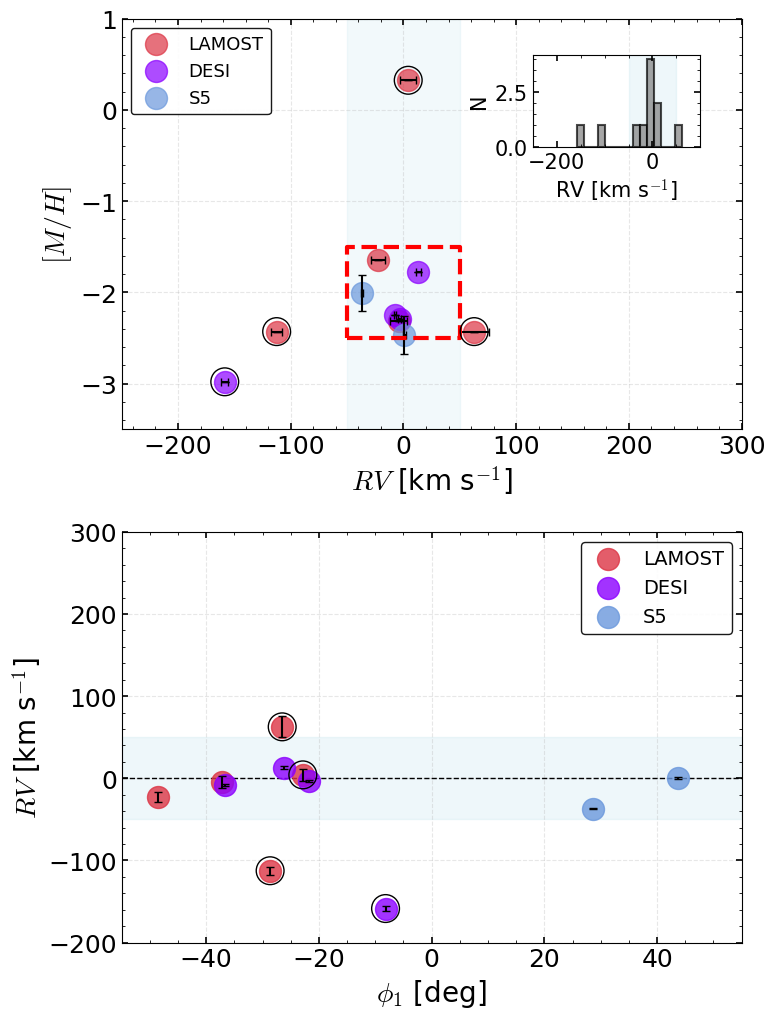

In [22]:
# 成员星
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 合并所有RV和MH数据
RV_all = np.concatenate([RV_L, RV_D, RV_S])
MH_all = np.concatenate([MH_L, MH_D, MH_S])
phi1_all_spec = np.concatenate([phi1_L, phi1_D, phi1_S])

# ============ 创建包含两个子图的figure（上下排列）============
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# ============ 上图: [M/H] vs RV ============
# 添加误差棒
ax1.errorbar(RV_L, MH_L, xerr=RV_e_L, yerr=MH_e_L,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)
ax1.errorbar(RV_D, MH_D, xerr=RV_e_D, yerr=np.zeros(len(MH_D)),
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)
ax1.errorbar(RV_S, MH_S, xerr=RV_e_S, yerr=MH_e_S,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)

# 分别绘制不同survey的数据
ax1.scatter(RV_L, MH_L, s=250, color='#DC3545', label='LAMOST', alpha=0.7, zorder=3)
ax1.scatter(RV_D, MH_D, s=250, color='#8B00FF', label='DESI', alpha=0.7, zorder=3)
ax1.scatter(RV_S, MH_S, s=250, color='#6B98DC', label='S5', alpha=0.7, zorder=3)

# ========== 添加红色选择框 ==========
# 定义选择框范围
rv_min, rv_max = -50, 50
mh_min, mh_max = -2.5,-1.5

# 方式2（可选）: 用plot画框边界
ax1.plot([rv_min, rv_max, rv_max, rv_min, rv_min],
          [mh_min, mh_min, mh_max, mh_max, mh_min],
          'r--', lw=3, zorder=5)

# ========== 找出并标记框外的星 ==========
# 判断哪些星在框外
mask_out_L = (RV_L < rv_min) | (RV_L > rv_max) | (MH_L < mh_min) | (MH_L > mh_max)
mask_out_D = (RV_D < rv_min) | (RV_D > rv_max) | (MH_D < mh_min) | (MH_D > mh_max)
mask_out_S = (RV_S < rv_min) | (RV_S > rv_max) | (MH_S < mh_min) | (MH_S > mh_max)

# 用黑色大圆圈标记框外的星
if np.any(mask_out_L):
    ax1.scatter(RV_L[mask_out_L], MH_L[mask_out_L], 
               s=400, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=6)
if np.any(mask_out_D):
    ax1.scatter(RV_D[mask_out_D], MH_D[mask_out_D], 
               s=400, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=6)
if np.any(mask_out_S):
    ax1.scatter(RV_S[mask_out_S], MH_S[mask_out_S], 
               s=400, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=6)


# 添加RV阴影区域（-50到50）- 垂直阴影
ax1.axvspan(-50, 50, alpha=0.15, color='lightblue', zorder=1)

# 创建插图显示 RV 分布
ax_inset = inset_axes(ax1, width="30%", height="25%", loc='center right',
                      bbox_to_anchor=(0.05, 0.35, 0.9, 0.9),
                      bbox_transform=ax1.transAxes)

ax_inset.axvspan(-50, 50, alpha=0.2, color='lightblue')

# 绘制 RV 直方图
counts, bins, patches = ax_inset.hist(RV_all, bins=15, 
                                       color='gray', 
                                       alpha=0.7,
                                       edgecolor='black',
                                       linewidth=1.5)

# 插图样式设置
ax_inset.set_xlabel('RV [km s$^{-1}$]', fontsize=15)
ax_inset.set_ylabel('N', fontsize=15)
ax_inset.tick_params(labelsize=15)
ax_inset.set_xlim(-250, 100)

# 上图主图设置
ax1.set_xlabel(r'$RV$ [km s$^{-1}$]', fontsize=20)
ax1.set_ylabel(r'$[M/H]$', fontsize=20)
ax1.tick_params(labelsize=18)
ax1.set_xlim(-250, 300)
ax1.set_ylim(-3.5, 1.0)
ax1.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax1.legend(fontsize=13, framealpha=0.9, edgecolor='black', loc='upper left')

# ============ 下图: phi1 vs RV ============
# 分别绘制不同survey的数据
ax2.scatter(phi1_L, RV_L, s=250, color='#DC3545', label='LAMOST', alpha=0.8, zorder=3)
ax2.scatter(phi1_D, RV_D, s=250, color='#8B00FF', label='DESI', alpha=0.8, zorder=3)
ax2.scatter(phi1_S, RV_S, s=250, color='#6B98DC', label='S5', alpha=0.8, zorder=3)

# 添加误差棒
ax2.errorbar(phi1_L, RV_L, yerr=RV_e_L,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)
ax2.errorbar(phi1_D, RV_D, yerr=RV_e_D,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)
ax2.errorbar(phi1_S, RV_S, yerr=RV_e_S,
            fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)

# ========== 在下图也标记框外的星（可选）==========
if np.any(mask_out_L):
    ax2.scatter(phi1_L[mask_out_L], RV_L[mask_out_L], 
               s=400, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=6)
if np.any(mask_out_D):
    ax2.scatter(phi1_D[mask_out_D], RV_D[mask_out_D], 
               s=400, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=6)
if np.any(mask_out_S):
    ax2.scatter(phi1_S[mask_out_S], RV_S[mask_out_S], 
               s=400, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=6)

ax2.axhspan(-50, 50, alpha=0.2, color='lightblue')

# 下图主图设置
ax2.set_xlabel(r'$\phi_1$ [deg]', fontsize=20)
ax2.set_ylabel(r'$RV$ [km s$^{-1}$]', fontsize=20)
ax2.tick_params(labelsize=18)
ax2.set_xlim(-55, 55)
ax2.set_ylim(-200, 300)
ax2.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.legend(fontsize=14, framealpha=0.9, edgecolor='black')

# 调整子图间距
plt.subplots_adjust(hspace=0.25)
plt.savefig("/home/zyh/stream/palomar5_sibling/plot/feh_RV.png", bbox_inches='tight', dpi=200)
plt.show()

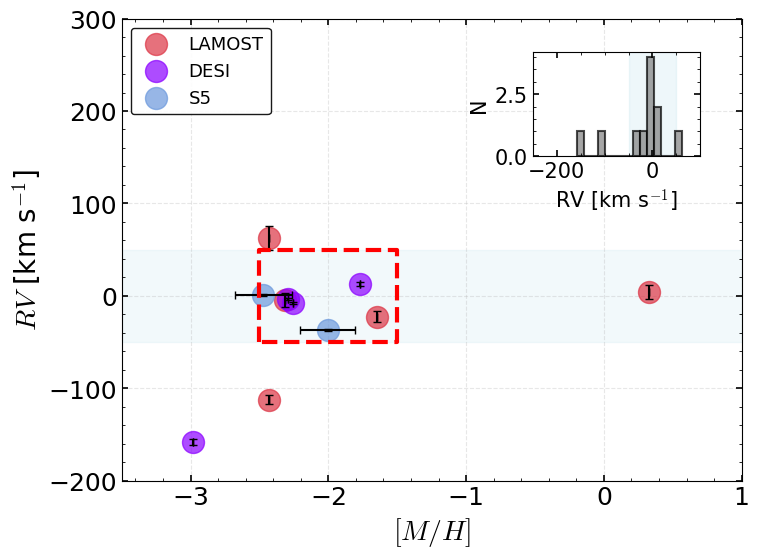

In [174]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# 添加误差棒
ax1.errorbar(MH_L, RV_L, xerr=MH_e_L, yerr=RV_e_L,
             fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)
ax1.errorbar(MH_D, RV_D, xerr=np.zeros(len(MH_D)), yerr=RV_e_D,
             fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)
ax1.errorbar(MH_S, RV_S, xerr=MH_e_S, yerr=RV_e_S,
             fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)

# 散点
ax1.scatter(MH_L, RV_L, s=250, color='#DC3545', label='LAMOST', alpha=0.7, zorder=3)
ax1.scatter(MH_D, RV_D, s=250, color='#8B00FF', label='DESI', alpha=0.7, zorder=3)
ax1.scatter(MH_S, RV_S, s=250, color='#6B98DC', label='S5', alpha=0.7, zorder=3)

# 红框
ax1.plot([mh_min, mh_min, mh_max, mh_max, mh_min],
         [rv_min, rv_max, rv_max, rv_min, rv_min],
         'r--', lw=3, zorder=5)

# 阴影区
ax1.axhspan(-50, 50, alpha=0.15, color='lightblue', zorder=1)

# 插图（RV分布）
ax_inset = inset_axes(ax1, width="30%", height="25%", loc='upper right',
                      bbox_to_anchor=(0.05, 0.05, 0.9, 0.9),
                      bbox_transform=ax1.transAxes)
ax_inset.axvspan(-50, 50, alpha=0.2, color='lightblue')
ax_inset.hist(RV_all, bins=15, color='gray', alpha=0.7,
              edgecolor='black', linewidth=1.5)
ax_inset.set_xlabel('RV [km s$^{-1}$]', fontsize=15)
ax_inset.set_ylabel('N', fontsize=15)
ax_inset.tick_params(labelsize=15)
ax_inset.set_xlim(-250, 100)

# 坐标范围统一
ax1.set_xlim(-3.5, 1.0)       # [M/H]
ax1.set_ylim(-200, 300)       # ✅ RV 统一范围
ax1.set_xlabel(r'$[M/H]$', fontsize=20)
ax1.set_ylabel(r'$RV$ [km s$^{-1}$]', fontsize=20)
ax1.tick_params(labelsize=18)
ax1.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax1.legend(fontsize=13, framealpha=0.9, edgecolor='black', loc='upper left')

plt.savefig("/home/zyh/stream/palomar5_sibling/plot/feh_RV_1.png",
            bbox_inches='tight', dpi=200)
plt.show()


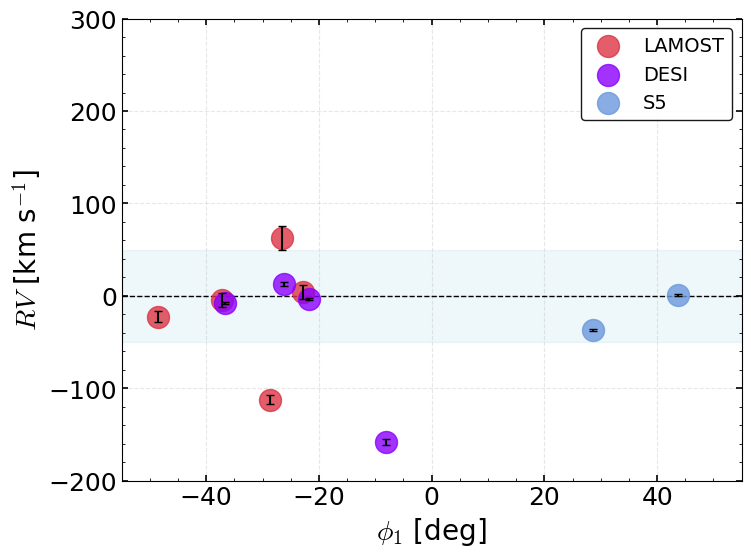

In [173]:
fig, ax2 = plt.subplots(figsize=(8, 6))

ax2.scatter(phi1_L, RV_L, s=250, color='#DC3545', label='LAMOST', alpha=0.8, zorder=3)
ax2.scatter(phi1_D, RV_D, s=250, color='#8B00FF', label='DESI', alpha=0.8, zorder=3)
ax2.scatter(phi1_S, RV_S, s=250, color='#6B98DC', label='S5', alpha=0.8, zorder=3)

# 误差棒
ax2.errorbar(phi1_L, RV_L, yerr=RV_e_L, fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)
ax2.errorbar(phi1_D, RV_D, yerr=RV_e_D, fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)
ax2.errorbar(phi1_S, RV_S, yerr=RV_e_S, fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)

# 阴影区
ax2.axhspan(-50, 50, alpha=0.2, color='lightblue')

# 坐标范围统一
ax2.set_xlim(-55, 55)
ax2.set_ylim(-200, 300)       # ✅ RV 统一范围
ax2.set_xlabel(r'$\phi_1$ [deg]', fontsize=20)
ax2.set_ylabel(r'$RV$ [km s$^{-1}$]', fontsize=20)
ax2.tick_params(labelsize=18)
ax2.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.legend(fontsize=14, framealpha=0.9, edgecolor='black')

plt.savefig("/home/zyh/stream/palomar5_sibling/plot/phi1_RV_2.png",
            bbox_inches='tight', dpi=200)
plt.show()


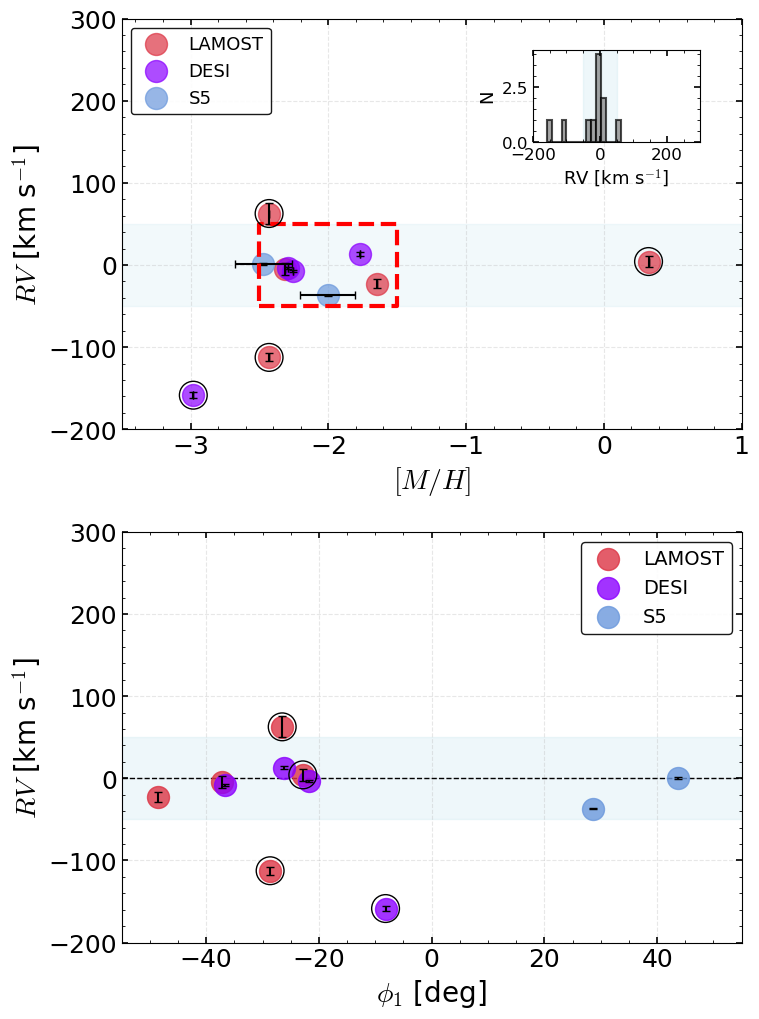

In [175]:
# RV范围统一
rv_min_plot, rv_max_plot = -200, 300

# ============ 创建包含两个子图的figure（上下排列）============
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# =========================================================
# 上图: RV vs [M/H] （横纵交换）
# =========================================================

# 添加误差棒
ax1.errorbar(MH_L, RV_L, xerr=MH_e_L, yerr=RV_e_L,
             fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)
ax1.errorbar(MH_D, RV_D, xerr=np.zeros(len(MH_D)), yerr=RV_e_D,
             fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)
ax1.errorbar(MH_S, RV_S, xerr=MH_e_S, yerr=RV_e_S,
             fmt='none', ecolor='black', elinewidth=1.5, capsize=3, alpha=1, zorder=4)

# 绘制散点
ax1.scatter(MH_L, RV_L, s=250, color='#DC3545', label='LAMOST', alpha=0.7, zorder=3)
ax1.scatter(MH_D, RV_D, s=250, color='#8B00FF', label='DESI', alpha=0.7, zorder=3)
ax1.scatter(MH_S, RV_S, s=250, color='#6B98DC', label='S5', alpha=0.7, zorder=3)

# ========== 红框（换坐标） ==========
rv_min, rv_max = -50, 50
mh_min, mh_max = -2.5, -1.5

ax1.plot([mh_min, mh_max, mh_max, mh_min, mh_min],
         [rv_min, rv_min, rv_max, rv_max, rv_min],
         'r--', lw=3, zorder=5)

# 框外星标记
mask_out_L = (RV_L < rv_min) | (RV_L > rv_max) | (MH_L < mh_min) | (MH_L > mh_max)
mask_out_D = (RV_D < rv_min) | (RV_D > rv_max) | (MH_D < mh_min) | (MH_D > mh_max)
mask_out_S = (RV_S < rv_min) | (RV_S > rv_max) | (MH_S < mh_min) | (MH_S > mh_max)

if np.any(mask_out_L):
    ax1.scatter(MH_L[mask_out_L], RV_L[mask_out_L],
                s=400, facecolors='none', edgecolors='black', linewidths=1, zorder=6)
if np.any(mask_out_D):
    ax1.scatter(MH_D[mask_out_D], RV_D[mask_out_D],
                s=400, facecolors='none', edgecolors='black', linewidths=1, zorder=6)
if np.any(mask_out_S):
    ax1.scatter(MH_S[mask_out_S], RV_S[mask_out_S],
                s=400, facecolors='none', edgecolors='black', linewidths=1, zorder=6)

# 阴影区（RV）
ax1.axhspan(-50, 50, alpha=0.15, color='lightblue', zorder=1)

# 插图：RV分布
ax_inset = inset_axes(ax1, width="30%", height="25%", loc='upper right',
                      bbox_to_anchor=(0.05, 0.05, 0.9, 0.9),
                      bbox_transform=ax1.transAxes)
ax_inset.axvspan(-50, 50, alpha=0.2, color='lightblue')
ax_inset.hist(RV_all, bins=15, color='gray', alpha=0.7,
              edgecolor='black', linewidth=1.5)
ax_inset.set_xlabel('RV [km s$^{-1}$]', fontsize=13)
ax_inset.set_ylabel('N', fontsize=13)
ax_inset.tick_params(labelsize=12)
ax_inset.set_xlim(rv_min_plot, rv_max_plot)

# 上图设置
ax1.set_xlabel(r'$[M/H]$', fontsize=20)
ax1.set_ylabel(r'$RV$ [km s$^{-1}$]', fontsize=20)
ax1.tick_params(labelsize=18)
ax1.set_xlim(-3.5, 1.0)
ax1.set_ylim(rv_min_plot, rv_max_plot)
ax1.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax1.legend(fontsize=13, framealpha=0.9, edgecolor='black', loc='upper left')

# =========================================================
# 下图: φ₁ vs RV
# =========================================================

ax2.scatter(phi1_L, RV_L, s=250, color='#DC3545', label='LAMOST', alpha=0.8, zorder=3)
ax2.scatter(phi1_D, RV_D, s=250, color='#8B00FF', label='DESI', alpha=0.8, zorder=3)
ax2.scatter(phi1_S, RV_S, s=250, color='#6B98DC', label='S5', alpha=0.8, zorder=3)

# 添加误差棒
ax2.errorbar(phi1_L, RV_L, yerr=RV_e_L,
             fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)
ax2.errorbar(phi1_D, RV_D, yerr=RV_e_D,
             fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)
ax2.errorbar(phi1_S, RV_S, yerr=RV_e_S,
             fmt='none', ecolor='black', elinewidth=1.5, capsize=3, zorder=4)

# 框外星标记（对应RV范围）
if np.any(mask_out_L):
    ax2.scatter(phi1_L[mask_out_L], RV_L[mask_out_L],
                s=400, facecolors='none', edgecolors='black', linewidths=1, zorder=6)
if np.any(mask_out_D):
    ax2.scatter(phi1_D[mask_out_D], RV_D[mask_out_D],
                s=400, facecolors='none', edgecolors='black', linewidths=1, zorder=6)
if np.any(mask_out_S):
    ax2.scatter(phi1_S[mask_out_S], RV_S[mask_out_S],
                s=400, facecolors='none', edgecolors='black', linewidths=1, zorder=6)

ax2.axhspan(-50, 50, alpha=0.2, color='lightblue')

# 下图样式
ax2.set_xlabel(r'$\phi_1$ [deg]', fontsize=20)
ax2.set_ylabel(r'$RV$ [km s$^{-1}$]', fontsize=20)
ax2.tick_params(labelsize=18)
ax2.set_xlim(-55, 55)
ax2.set_ylim(rv_min_plot, rv_max_plot)
ax2.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.legend(fontsize=14, framealpha=0.9, edgecolor='black')

# 调整布局
plt.subplots_adjust(hspace=0.25)
plt.savefig("/home/zyh/stream/palomar5_sibling/plot/feh_RV.png",
            bbox_inches='tight', dpi=200)
plt.show()


In [165]:
# 首先找到LAMOST、DESI、S5星在原始数据中的索引
# 通过source_id匹配
def find_indices_in_PM(sid_spec, sid_pm):
    """找到光谱星在ind_PM中的索引"""
    indices = []
    for sid in sid_spec:
        match = np.where(sid_pm == sid)[0]
        if len(match) > 0:
            indices.append(match[0])
    return np.array(indices)

# 找到LAMOST、DESI、S5星的索引
idx_L_in_PM = find_indices_in_PM(SID_L, SID[ind_PM])
idx_D_in_PM = find_indices_in_PM(SID_D, SID[ind_PM])
idx_S_in_PM = find_indices_in_PM(SID_S, SID[ind_PM])

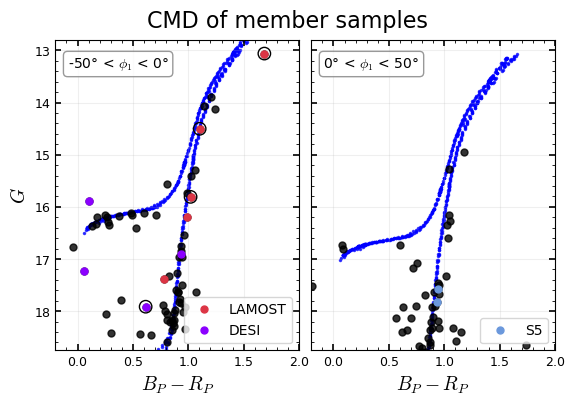

In [218]:
# 画一个没有control sample的图

# 设置参数
bin_phi1 = np.linspace(min_hist_phi1, max_hist_phi1, n_hist_phi1+1)
n_bins = len(bin_phi1) - 1

# 创建一个大图，2行n_bins列
fig, axes = plt.subplots(1, n_bins, figsize=(3*n_bins, 4))

# 如果只有一列，确保axes是2D数组
if n_bins == 1:
    axes = axes.reshape(-1, 1)

# 遍历每个φ1区间
for i_phi1 in range(n_bins):
    
    # ========== 第一行：Member Sample（成员星） ==========
    ax1 = axes[i_phi1]
    
    # 绘制成员星CMD
    # ax1.plot(BPmag_mem - RPmag_mem - (A_BP-A_RP)*ebv_mem,
    #         Gmag_mem - A_G*ebv_mem, 
    #         'o', color='black', ms=5, alpha=0.8)
    # 成员星：选择星流中心附近的星
    ind_member = (Gphi1[ind_PM]>bin_phi1[i_phi1]) & \
                 (Gphi1[ind_PM]<bin_phi1[i_phi1+1]) & \
                 (Gphi2[ind_PM]<max_phi2) & \
                 (Gphi2[ind_PM]>min_phi2) & \
                 (pmraerr[ind_PM]<0.2) & \
                 (pmdecerr[ind_PM]<0.2)
    
    # 绘制成员星CMD
    ax1.plot(BPmag[ind_PM][ind_member] - RPmag[ind_PM][ind_member] - (A_BP-A_RP)*ebv[ind_PM][ind_member],
             Gmag[ind_PM][ind_member] - A_G*ebv[ind_PM][ind_member], 
             'o', color='black', ms=5, alpha=0.8)
    
    # 叠加有光谱的星 - LAMOST (红色)
    idx_L_this_bin = np.where((phi1_L > bin_phi1[i_phi1]) & (phi1_L < bin_phi1[i_phi1+1]))[0]
    if len(idx_L_this_bin) > 0:
        ax1.plot(BPmag_L[idx_L_this_bin] - RPmag_L[idx_L_this_bin] - (A_BP-A_RP)*ebv_L[idx_L_this_bin],
                   Gmag_L[idx_L_this_bin] - A_G*ebv_L[idx_L_this_bin],
                   'o',ms=5, c='#DC3545', label='LAMOST')
    
    # 叠加有光谱的星 - DESI (紫色)
    idx_D_this_bin = np.where((phi1_D > bin_phi1[i_phi1]) & (phi1_D < bin_phi1[i_phi1+1]))[0]
    if len(idx_D_this_bin) > 0:
        ax1.plot(BPmag_D[idx_D_this_bin] - RPmag_D[idx_D_this_bin] - (A_BP-A_RP)*ebv_D[idx_D_this_bin],
                   Gmag_D[idx_D_this_bin] - A_G*ebv_D[idx_D_this_bin],
                   'o',ms=5, c='#8B00FF', label='DESI')
    
    # 叠加有光谱的星 - S5 (蓝色)
    idx_S_this_bin = np.where((phi1_S > bin_phi1[i_phi1]) & (phi1_S < bin_phi1[i_phi1+1]))[0]
    if len(idx_S_this_bin) > 0:
        ax1.plot(BPmag_S[idx_S_this_bin] - RPmag_S[idx_S_this_bin] - (A_BP-A_RP)*ebv_S[idx_S_this_bin],
                   Gmag_S[idx_S_this_bin] - A_G*ebv_S[idx_S_this_bin],
                   'o',ms=5, c='#6B98DC', label='S5')
        
    # ========== 用黑色圆圈标记框外的星 ==========
    # LAMOST 框外星
    idx_L_out = np.where((phi1_L > bin_phi1[i_phi1]) & 
                         (phi1_L < bin_phi1[i_phi1+1]) & 
                         mask_out_L)[0]
    if len(idx_L_out) > 0:
        ax1.scatter(BPmag_L[idx_L_out] - RPmag_L[idx_L_out] - (A_BP-A_RP)*ebv_L[idx_L_out],
                   Gmag_L[idx_L_out] - A_G*ebv_L[idx_L_out],
                   s=80, facecolors='none', edgecolors='black', 
                   linewidths=1, zorder=10)
    
    # DESI 框外星
    idx_D_out = np.where((phi1_D > bin_phi1[i_phi1]) & 
                         (phi1_D < bin_phi1[i_phi1+1]) & 
                         mask_out_D)[0]
    if len(idx_D_out) > 0:
        ax1.scatter(BPmag_D[idx_D_out] - RPmag_D[idx_D_out] - (A_BP-A_RP)*ebv_D[idx_D_out],
                   Gmag_D[idx_D_out] - A_G*ebv_D[idx_D_out],
                   s=80, facecolors='none', edgecolors='black', 
                   linewidths=1, zorder=10)
    
    # S5 框外星
    idx_S_out = np.where((phi1_S > bin_phi1[i_phi1]) & 
                         (phi1_S < bin_phi1[i_phi1+1]) & 
                         mask_out_S)[0]
    if len(idx_S_out) > 0:
        ax1.scatter(BPmag_S[idx_S_out] - RPmag_S[idx_S_out] - (A_BP-A_RP)*ebv_S[idx_S_out],
                   Gmag_S[idx_S_out] - A_G*ebv_S[idx_S_out],
                   s=80, facecolors='none', edgecolors='black', 
                   linewidths=1, zorder=10)
    
    # 添加等龄线（每个区间偏移一点）
    if Check_by_iso:
        ax1.plot(BPRP_iso, Gmag_iso + DM_iso + i_phi1*0.53, 
                '.', color='blue', ms=3, zorder=1, alpha=0.7)
    
    #ax1.axhline(y=17.6, ls='--', color='gray', lw=1, alpha=0.7)
    
    # 在图内添加φ1范围文本（左上角）
    ax1.text(0.05, 0.95, f"{int(bin_phi1[i_phi1])}° < $\\phi_1$ < {int(bin_phi1[i_phi1+1])}°",
             transform=ax1.transAxes, fontsize=10, va='top', ha='left',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
 
    ax1.legend(loc='lower right', fontsize=10)
    
    # 设置坐标轴
    ax1.set_xlim(-0.2, 2.0)
    ax1.set_ylim(18.75, 12.8)
    ax1.tick_params(labelsize=9)
    ax1.grid(alpha=0.2)
    
    # 只在最左边显示y轴标签
    if i_phi1 == 0:
        ax1.set_ylabel('$G$', fontsize=14)
    else:
        ax1.set_yticklabels([])
    
    ax1.set_xlabel('$B_P - R_P$', fontsize=14)


# 添加每一行的总标题（居中）
fig.text(0.5, 1.02, 'CMD of member samples', ha='center', va='top', 
         fontsize=16 )

# 调整子图间距
plt.tight_layout()
plt.subplots_adjust(hspace=0.15, wspace=0.05)
plt.savefig("/home/zyh/stream/palomar5_sibling/plot/isochrone.png", dpi = 200, bbox_inches='tight')
plt.show()

In [26]:
def Correct_PM_From_Solar_Motion(ra, dec, pmra, pmdec, dist, degree=True, kpc=True,
                                 radec=True, X_Sun=8.34, UVW_Sun=[11.1, 12.24, 7.25], V_LSR=232):
    """
    This is used to correct the proper motions from the solar motion,
    the default values are
    X_Sun=8.34, UVW_Sun=[11.1, 12.24, 7.25], V_LSR=232
    return the corrected proper motion along l and b
    """
    import galpy.util.coords as gub
    import numpy as np
    # convert the proper motion along ra dec to those along l b
    if radec:
        llbb = gub.radec_to_lb(ra, dec, degree=True)
        ll = llbb[:, 0]
        bb = llbb[:, 1]
        pmllbb = gub.pmrapmdec_to_pmllpmbb(pmra, pmdec, ra, dec, degree=True)
        pmll = pmllbb[:, 0]
        pmbb = pmllbb[:, 1]
    else:
        ll = ra * 1.
        bb = dec * 1.
        pmll = pmra * 1.
        pmbb = pmdec * 1.

    rvpm = gub.vxvyvz_to_vrpmllpmbb(dist * 0 - UVW_Sun[0], dist * 0 - (V_LSR + UVW_Sun[1]), dist * 0 - UVW_Sun[2],
                                    ll, bb, dist, XYZ=False, degree=True)
    pmlMC = pmll - rvpm[:, 1]
    pmbMC = pmbb - rvpm[:, 2]
    pmradecMC = gub.pmllpmbb_to_pmrapmdec(pmlMC, pmbMC, ll, bb, degree=True)
    return pmlMC, pmbMC, pmradecMC[:, 0], pmradecMC[:, 1]

In [28]:
# get the bright stars with G>17
# 我改成了17.6
bin_phi1 = np.linspace(min_hist_phi1, max_hist_phi1, n_hist_phi1+1)
for i_phi1 in range(n_hist_phi1):
    ind_pm_phi1      = (Gphi1[ind_PM]>bin_phi1[i_phi1]) & (Gphi1[ind_PM]<bin_phi1[i_phi1+1]) & \
                        (Gphi2[ind_PM]<max_phi2) & (Gphi2[ind_PM]>min_phi2)
    
    ind_pm_phi1_perr = (Gphi1[ind_PM]>bin_phi1[i_phi1]) & (Gphi1[ind_PM]<bin_phi1[i_phi1+1]) & \
                        (Gphi2[ind_PM]<max_phi2) & (Gphi2[ind_PM]>min_phi2) & \
                        (pmraerr[ind_PM]<0.2) & (pmdecerr[ind_PM]<0.2) 

ind_G17 = Gmag[ind_PM][ind_pm_phi1]<18
dist_iso = 10**(DM_iso*0.2)/100
dist_iso_2 = 10**((DM_iso+0.53)*0.2)/100
print(dist_iso,dist_iso_2)

14.25607593602188 18.197008586099845


In [29]:
S_pmlMC, S_pmbMC, S_pmraMC, S_pmdecMC = Correct_PM_From_Solar_Motion(ra[ind_PM][ind_mem], dec[ind_PM][ind_mem],
                                                                     pmra[ind_PM][ind_mem], pmdec[ind_PM][ind_mem],
                                                                     ra[ind_PM][ind_mem]*0+dist_iso,
                                                                     degree=True, radec=True)

C_RRL_PM = coord.SkyCoord(ra=ra[ind_PM][ind_mem]*u.deg,
                          dec=dec[ind_PM][ind_mem]*u.deg,
                          pm_ra_cosdec=S_pmraMC*u.mas/u.yr,
                          pm_dec=S_pmdecMC*u.mas/u.yr)
CRPM_fr = C_RRL_PM.transform_to(frame)
RPMphi1 = CRPM_fr.phi1.deg
RPMphi2 = CRPM_fr.phi2.deg
RPM_pmphi1 = CRPM_fr.pm_phi1_cosphi2.value
RPM_pmphi2 = CRPM_fr.pm_phi2.value


# # convert the coords for LAMOST data
S_pmlMC_L, S_pmbMC_L, S_pmraMC_L, S_pmdecMC_L = Correct_PM_From_Solar_Motion(
    ra_L, dec_L, pmra_L, pmdec_L, 
    ra_L*0 + dist_iso,
    degree=True, radec=True
)

# C_L_PM = coord.SkyCoord(ra=ra_L[ind_mem_L]*u.deg,
#                         dec=dec_L[ind_mem_L]*u.deg,
#                         pm_ra_cosdec=L_pmraMC*u.mas/u.yr,
#                         pm_dec=L_pmdecMC*u.mas/u.yr)
# CLPM_fr = C_L_PM.transform_to(frame)
# LPMphi1 = CLPM_fr.phi1.deg
# LPMphi2 = CLPM_fr.phi2.deg
# LPM_pmphi1 = CLPM_fr.pm_phi1_cosphi2.value
# LPM_pmphi2 = CLPM_fr.pm_phi2.value


# # convert the coords for DESI data
S_pmlMC_D, S_pmbMC_D, S_pmraMC_D, S_pmdecMC_D = Correct_PM_From_Solar_Motion(
    ra_D, dec_D, pmra_D, pmdec_D, 
    ra_D*0 + dist_iso,
    degree=True, radec=True
)

# C_D_PM = coord.SkyCoord(ra=ra_D*u.deg,
#                         dec=dec_D*u.deg,
#                         pm_ra_cosdec=D_pmraMC*u.mas/u.yr,
#                         pm_dec=D_pmdecMC*u.mas/u.yr)
# CDPM_fr = C_D_PM.transform_to(frame)
# DPMphi1 = CDPM_fr.phi1.deg
# DPMphi2 = CDPM_fr.phi2.deg
# DPM_pmphi1 = CDPM_fr.pm_phi1_cosphi2.value
# DPM_pmphi2 = CDPM_fr.pm_phi2.value

# # convert the coords for S5 data
S_pmlMC_S, S_pmbMC_S, S_pmraMC_S, S_pmdecMC_S = Correct_PM_From_Solar_Motion(
    ra_S, dec_S, pmra_S, pmdec_S, 
    ra_S*0 + dist_iso_2,
    degree=True, radec=True
)

In [30]:
# left segment
ind_mem_1 = (Gphi1[ind_PM]>min_phi1) & (Gphi1[ind_PM]<0) & \
          (Gphi2[ind_PM]<max_phi2) & (Gphi2[ind_PM]>min_phi2) & \
          (pmraerr[ind_PM]<0.5) & (pmdecerr[ind_PM]<0.5) 

S_pmlMC_1, S_pmbMC_1, S_pmraMC_1, S_pmdecMC_1 = Correct_PM_From_Solar_Motion(ra[ind_PM][ind_mem_1], dec[ind_PM][ind_mem_1],
                                                                     pmra[ind_PM][ind_mem_1], pmdec[ind_PM][ind_mem_1],
                                                                     ra[ind_PM][ind_mem_1]*0+dist_iso,
                                                                     degree=True, radec=True)

C_RRL_PM_1 = coord.SkyCoord(ra=ra[ind_PM][ind_mem_1]*u.deg,
                          dec=dec[ind_PM][ind_mem_1]*u.deg,
                          pm_ra_cosdec=S_pmraMC_1*u.mas/u.yr,
                          pm_dec=S_pmdecMC_1*u.mas/u.yr)

CRPM_fr_1 = C_RRL_PM_1.transform_to(frame)
RPMphi1_1 = CRPM_fr_1.phi1.deg
RPMphi2_1 = CRPM_fr_1.phi2.deg
RPM_pmphi1_1 = CRPM_fr_1.pm_phi1_cosphi2.value
RPM_pmphi2_1 = CRPM_fr_1.pm_phi2.value

#right segment
ind_mem_2 = (Gphi1[ind_PM]>min_phi1) & (Gphi1[ind_PM]<max_phi1) & \
          (Gphi2[ind_PM]<max_phi2) & (Gphi2[ind_PM]>min_phi2) & \
          (pmraerr[ind_PM]<0.5) & (pmdecerr[ind_PM]<0.5) 

S_pmlMC_2, S_pmbMC_2, S_pmraMC_2, S_pmdecMC_2 = Correct_PM_From_Solar_Motion(ra[ind_PM][ind_mem_2], dec[ind_PM][ind_mem_2],
                                                                     pmra[ind_PM][ind_mem_2], pmdec[ind_PM][ind_mem_2],
                                                                     ra[ind_PM][ind_mem_2]*0+dist_iso_2,
                                                                     degree=True, radec=True)

C_RRL_PM_2 = coord.SkyCoord(ra=ra[ind_PM][ind_mem_2]*u.deg,
                          dec=dec[ind_PM][ind_mem_2]*u.deg,
                          pm_ra_cosdec=S_pmraMC_2*u.mas/u.yr,
                          pm_dec=S_pmdecMC_2*u.mas/u.yr)

CRPM_fr_2 = C_RRL_PM_2.transform_to(frame)
RPMphi1_2 = CRPM_fr_2.phi1.deg
RPMphi2_2 = CRPM_fr_2.phi2.deg
RPM_pmphi1_2 = CRPM_fr_2.pm_phi1_cosphi2.value
RPM_pmphi2_2 = CRPM_fr_2.pm_phi2.value

In [262]:
def create_mock_data(min_phi1, max_phi1, min_phi2, max_phi2, 
                     min_pmra, max_pmra, min_pmdec, max_pmdec,
                     dist, frame, mock_n=10000):
    """生成并处理 mock 数据"""
    
    mock_pmra = np.random.uniform(min_pmra, max_pmra, mock_n)
    mock_pmdec = np.random.uniform(min_pmdec, max_pmdec, mock_n)
    mock_phi1 = np.linspace(min_phi1, max_phi1, 101)
    mock_dist = np.zeros_like(mock_phi1) + dist
    mock_phi2 = np.random.uniform(min_phi2, max_phi2, mock_n)
    
    min_vphi1_mock = np.zeros_like(mock_phi1)
    max_vphi1_mock = np.zeros_like(mock_phi1)
    min_vphi2_mock = np.zeros_like(mock_phi1)
    max_vphi2_mock = np.zeros_like(mock_phi1)
    
    for i_mock_phi1 in range(len(mock_phi1)):
        mock_fr = gc.GreatCircleICRSFrame(
            phi1=(np.zeros_like(mock_phi2) + mock_phi1[i_mock_phi1])*u.degree,
            phi2=mock_phi2*u.degree,
            pole=frame.pole,
            origin=frame.origin
        )
        mock_equ = mock_fr.transform_to(coord.ICRS())
        mock_ra = mock_equ.ra.deg
        mock_dec = mock_equ.dec.deg

        mock_pmlMC, mock_pmbMC, mock_pmraMC, mock_pmdecMC = Correct_PM_From_Solar_Motion(
            mock_ra, mock_dec,
            mock_pmra, mock_pmdec,
            mock_ra*0 + mock_dist[i_mock_phi1],
            degree=True, radec=True
        )

        mock_coord = coord.SkyCoord(
            ra=mock_ra*u.deg,
            dec=mock_dec*u.deg,
            pm_ra_cosdec=mock_pmraMC*u.mas/u.yr,
            pm_dec=mock_pmdecMC*u.mas/u.yr
        )
        
        mock_fr = mock_coord.transform_to(frame)
        cmock_pmphi1 = mock_fr.pm_phi1_cosphi2.value
        cmock_pmphi2 = mock_fr.pm_phi2.value
        
        min_vphi1_mock[i_mock_phi1] = np.min(cmock_pmphi1 * mock_dist[i_mock_phi1] * 4.74)
        max_vphi1_mock[i_mock_phi1] = np.max(cmock_pmphi1 * mock_dist[i_mock_phi1] * 4.74)
        
        min_vphi2_mock[i_mock_phi1] = np.min(cmock_pmphi2 * mock_dist[i_mock_phi1] * 4.74)
        max_vphi2_mock[i_mock_phi1] = np.max(cmock_pmphi2 * mock_dist[i_mock_phi1] * 4.74)
    
    return min_vphi1_mock, max_vphi1_mock, min_vphi2_mock, max_vphi2_mock

# ========== 处理左段 mock 数据 ==========
min_vphi1_mock_1, max_vphi1_mock_1, min_vphi2_mock_1, max_vphi2_mock_1 = create_mock_data(
    min_phi1, 0,  # 左段：min_phi1 到 0
    min_phi2, max_phi2,
    min_pmra, 1, 0.5, max_pmdec,
    dist_iso, frame, mock_n=10000
)

# ========== 处理右段 mock 数据 ==========
min_vphi1_mock_2, max_vphi1_mock_2, min_vphi2_mock_2, max_vphi2_mock_2 = create_mock_data(
    min_phi1, max_phi1,  # 右段：min_phi1 到 max_phi1
    min_phi2, max_phi2,
    min_pmra, 1, 0.5, max_pmdec,
    dist_iso_2, frame, mock_n=10000
)

# ========== 生成对应的 phi1 数组 ==========
mock_phi1_1 = np.linspace(min_phi1, 0, 101)
mock_phi1_2 = np.linspace(0, max_phi1, 101)  

# 如果要合并成完整的
mock_phi1_all = np.concatenate([mock_phi1_1[:-1], mock_phi1_2])  # 避免在 0 点重复
min_vphi1_mock_all = np.concatenate([min_vphi1_mock_1[:-1], min_vphi1_mock_2])
max_vphi1_mock_all = np.concatenate([max_vphi1_mock_1[:-1], max_vphi1_mock_2])
min_vphi2_mock_all = np.concatenate([min_vphi2_mock_1[:-1], min_vphi2_mock_2])
max_vphi2_mock_all = np.concatenate([max_vphi2_mock_1[:-1], max_vphi2_mock_2])

<>:34: SyntaxWarning: invalid escape sequence '\m'

<>:38: SyntaxWarning: invalid escape sequence '\m'

<>:55: SyntaxWarning: invalid escape sequence '\p'

<>:58: SyntaxWarning: invalid escape sequence '\p'

<>:82: SyntaxWarning: invalid escape sequence '\m'

<>:86: SyntaxWarning: invalid escape sequence '\m'

<>:102: SyntaxWarning: invalid escape sequence '\p'

<>:105: SyntaxWarning: invalid escape sequence '\p'

<>:34: SyntaxWarning: invalid escape sequence '\m'

<>:38: SyntaxWarning: invalid escape sequence '\m'

<>:55: SyntaxWarning: invalid escape sequence '\p'

<>:58: SyntaxWarning: invalid escape sequence '\p'

<>:82: SyntaxWarning: invalid escape sequence '\m'

<>:86: SyntaxWarning: invalid escape sequence '\m'

<>:102: SyntaxWarning: invalid escape sequence '\p'

<>:105: SyntaxWarning: invalid escape sequence '\p'

/tmp/ipykernel_2640498/4074029944.py:34: SyntaxWarning: invalid escape sequence '\m'
  facecolor="#DC3545", alpha=0.2, ec=None, label='Mock $\mu_{\phi_1}^*$ range')

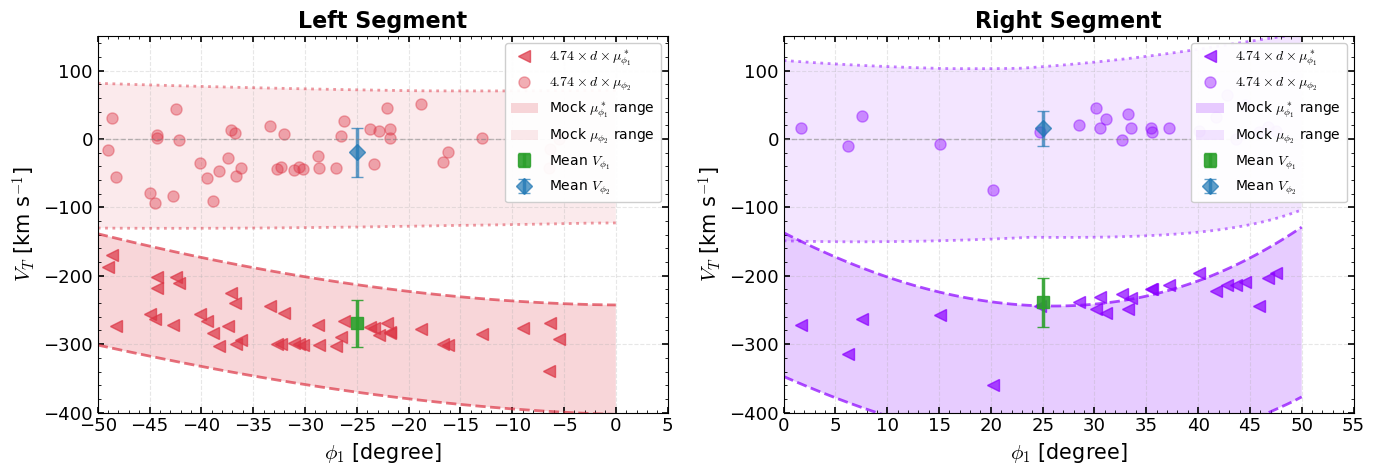

In [60]:
# ========== 准备数据 ==========
ind_G18 = Gmag[ind_PM][ind_mem]<18
bin_phi1_vphi = np.linspace(min_phi1, max_phi1, n_hist_phi1+1)

mean_Vphi1 = np.zeros_like(bin_phi1_vphi[1:])
std_Vphi1 = np.zeros_like(bin_phi1_vphi[1:])
mean_Vphi2 = np.zeros_like(bin_phi1_vphi[1:])
std_Vphi2 = np.zeros_like(bin_phi1_vphi[1:])

for i_vphi1 in range(len(bin_phi1_vphi)-1):
    ind_phi1_tmp = (RPMphi1[ind_G18]>bin_phi1_vphi[i_vphi1]) & (RPMphi1[ind_G18]<bin_phi1_vphi[i_vphi1+1])
    mean_Vphi1[i_vphi1] = np.mean(4.74*RPM_pmphi1[ind_G18][ind_phi1_tmp]*dist_iso)
    std_Vphi1[i_vphi1] = np.std(4.74*RPM_pmphi1[ind_G18][ind_phi1_tmp]*dist_iso)
    mean_Vphi2[i_vphi1] = np.mean(4.74*RPM_pmphi2[ind_G18][ind_phi1_tmp]*dist_iso)
    std_Vphi2[i_vphi1] = np.std(4.74*RPM_pmphi2[ind_G18][ind_phi1_tmp]*dist_iso)

# ========== 分别处理左右段数据 ==========
ind_G18_1 = ind_G18 & (RPMphi1 > min_phi1) & (RPMphi1 < 0)
ind_G18_2 = ind_G18 & (RPMphi1 > 0) & (RPMphi1 < max_phi1)

# ========== 创建两个并排的图 ==========
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ========== 左段图 ==========
ax1.plot(RPMphi1[ind_G18_1], 4.74*RPM_pmphi1[ind_G18_1]*dist_iso, 
         "<", color="#DC3545", label=r"$4.74 \times d \times \mu_{\phi_1}^*$", ms=8, alpha=0.7)
ax1.plot(RPMphi1[ind_G18_1], 4.74*RPM_pmphi2[ind_G18_1]*dist_iso, 
         "o", color="#DC3545", label=r"$4.74 \times d \times \mu_{\phi_2}$", ms=8, alpha=0.4)

# 左段 Mock 数据
ax1.fill_between(x=mock_phi1_1,
                 y1=min_vphi1_mock_1,
                 y2=max_vphi1_mock_1, 
                 facecolor="#DC3545", alpha=0.2, ec=None, label='Mock $\mu_{\phi_1}^*$ range')
ax1.fill_between(x=mock_phi1_1,
                 y1=min_vphi2_mock_1,
                 y2=max_vphi2_mock_1, 
                 facecolor="#DC3545", alpha=0.1, ec=None, label='Mock $\mu_{\phi_2}$ range')

ax1.plot(mock_phi1_1, min_vphi1_mock_1, '--', color="#DC3545", alpha=0.7, linewidth=2)
ax1.plot(mock_phi1_1, max_vphi1_mock_1, '--', color="#DC3545", alpha=0.7, linewidth=2)
ax1.plot(mock_phi1_1, min_vphi2_mock_1, ':', color="#DC3545", alpha=0.5, linewidth=2)
ax1.plot(mock_phi1_1, max_vphi2_mock_1, ':', color="#DC3545", alpha=0.5, linewidth=2)

# 左段 binned 数据
bin_center = (bin_phi1_vphi[1:]+bin_phi1_vphi[:-1])/2
bin_center_1 = bin_center[bin_center < 0]
mean_Vphi1_1 = mean_Vphi1[:len(bin_center_1)]
std_Vphi1_1 = std_Vphi1[:len(bin_center_1)]
mean_Vphi2_1 = mean_Vphi2[:len(bin_center_1)]
std_Vphi2_1 = std_Vphi2[:len(bin_center_1)]

ax1.errorbar(bin_center_1, mean_Vphi1_1, yerr=std_Vphi1_1, 
             color="#2ca02c", capsize=4, lw=2.5, fmt='s', 
             label='Mean $V_{\phi_1}$', alpha=0.9, markersize=8)
ax1.errorbar(bin_center_1, mean_Vphi2_1, yerr=std_Vphi2_1, 
             color="#1f77b4", capsize=4, lw=2.5, fmt='D', 
             label='Mean $V_{\phi_2}$', alpha=0.7, markersize=8)

ax1.hlines(y=0, xmin=min_phi1, xmax=0, color="gray", ls="--", linewidth=1, alpha=0.5)
ax1.set_xlim([min_phi1, 0])
ax1.set_ylim([-400, 150])
ax1.set_xticks(np.arange(min_phi1, 10, 5))
ax1.set_yticks(np.arange(-400, 200, 100))
ax1.tick_params(labelsize=13)
ax1.set_xlabel(r"$\phi_1$ [degree]", fontsize=15)
ax1.set_ylabel(r"$V_T$ [km s$^{-1}$]", fontsize=15)
ax1.set_title("Left Segment", fontsize=16, fontweight='bold')
ax1.legend(fontsize=10, loc='best', framealpha=0.95)
ax1.grid(alpha=0.3, linestyle='--')

# ========== 右段图 ==========
ax2.plot(RPMphi1[ind_G18_2], 4.74*RPM_pmphi1[ind_G18_2]*dist_iso, 
         "<", color="#8B00FF", label=r"$4.74 \times d \times \mu_{\phi_1}^*$", ms=8, alpha=0.7)
ax2.plot(RPMphi1[ind_G18_2], 4.74*RPM_pmphi2[ind_G18_2]*dist_iso, 
         "o", color="#8B00FF", label=r"$4.74 \times d \times \mu_{\phi_2}$", ms=8, alpha=0.4)

# 右段 Mock 数据
ax2.fill_between(x=mock_phi1_2,
                 y1=min_vphi1_mock_2,
                 y2=max_vphi1_mock_2, 
                 facecolor="#8B00FF", alpha=0.2, ec=None, label='Mock $\mu_{\phi_1}^*$ range')
ax2.fill_between(x=mock_phi1_2,
                 y1=min_vphi2_mock_2,
                 y2=max_vphi2_mock_2, 
                 facecolor="#8B00FF", alpha=0.1, ec=None, label='Mock $\mu_{\phi_2}$ range')

ax2.plot(mock_phi1_2, min_vphi1_mock_2, '--', color="#8B00FF", alpha=0.7, linewidth=2)
ax2.plot(mock_phi1_2, max_vphi1_mock_2, '--', color="#8B00FF", alpha=0.7, linewidth=2)
ax2.plot(mock_phi1_2, min_vphi2_mock_2, ':', color="#8B00FF", alpha=0.5, linewidth=2)
ax2.plot(mock_phi1_2, max_vphi2_mock_2, ':', color="#8B00FF", alpha=0.5, linewidth=2)

# 右段 binned 数据
bin_center_2 = bin_center[bin_center > 0]
mean_Vphi1_2 = mean_Vphi1[len(bin_center_1):]
std_Vphi1_2 = std_Vphi1[len(bin_center_1):]
mean_Vphi2_2 = mean_Vphi2[len(bin_center_1):]
std_Vphi2_2 = std_Vphi2[len(bin_center_1):]

ax2.errorbar(bin_center_2, mean_Vphi1_2, yerr=std_Vphi1_2, 
             color="#2ca02c", capsize=4, lw=2.5, fmt='s', 
             label='Mean $V_{\phi_1}$', alpha=0.9, markersize=8)
ax2.errorbar(bin_center_2, mean_Vphi2_2, yerr=std_Vphi2_2, 
             color="#1f77b4", capsize=4, lw=2.5, fmt='D', 
             label='Mean $V_{\phi_2}$', alpha=0.7, markersize=8)

ax2.hlines(y=0, xmin=0, xmax=max_phi1, color="gray", ls="--", linewidth=1, alpha=0.5)
ax2.set_xlim([0, max_phi1])
ax2.set_ylim([-400, 150])
ax2.set_xticks(np.arange(0, max_phi1+10, 5))
ax2.set_yticks(np.arange(-400, 200, 100))
ax2.tick_params(labelsize=13)
ax2.set_xlabel(r"$\phi_1$ [degree]", fontsize=15)
ax2.set_ylabel(r"$V_T$ [km s$^{-1}$]", fontsize=15)
ax2.set_title("Right Segment", fontsize=16, fontweight='bold')
ax2.legend(fontsize=10, loc='best', framealpha=0.95)
ax2.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

Bin  [deg]    N    sigma(V_phi1)  err    sigma(V_phi2)  err
 -50 to -40   11      36.88     8.25       47.11    10.53
 -40 to -30   15      26.38     4.98       30.87     5.83
 -30 to -20   11      12.15     2.72       29.61     6.62
 -20 to -10    4      11.26     4.60       36.72    14.99
 -10 to  0    4      31.58    12.89       18.04     7.36


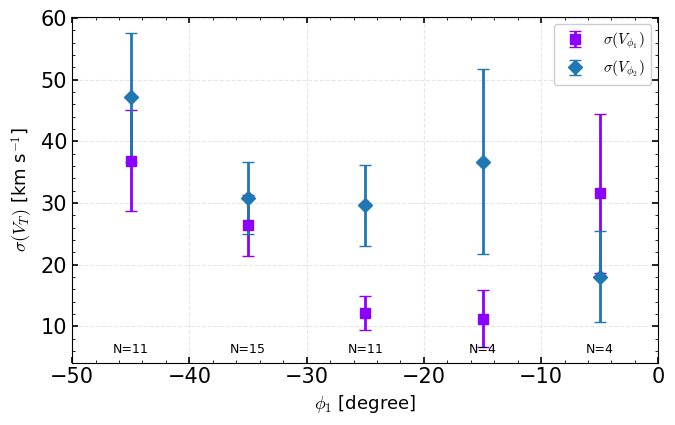

In [271]:
# ----------------------------
# 1) 数据与筛选（左段、亮星）
# ----------------------------
ind_G18 = (Gmag[ind_PM][ind_mem] < 18)        # 亮星
phi1     = RPMphi1[ind_G18]
pmphi1   = RPM_pmphi1[ind_G18]
pmphi2   = RPM_pmphi2[ind_G18]

# 若 dist_iso 是标量，下面会自动广播；若为每颗星的数组，请同样切片：
# dist_use = dist_iso if np.ndim(dist_iso)==0 else dist_iso[ind_G18]
dist_use = dist_iso

# 只取左段 [-50,0]
mask_left = (phi1 >= -50) & (phi1 <= 0)
phi1 = phi1[mask_left]
pmphi1 = pmphi1[mask_left]
pmphi2 = pmphi2[mask_left]
if np.ndim(dist_use) != 0:
    dist_use = dist_use[mask_left]

# 切向速度 (km/s)
vt1 = 4.74 * pmphi1 * dist_use
vt2 = 4.74 * pmphi2 * dist_use

# 去掉 NaN/Inf
finite = np.isfinite(phi1) & np.isfinite(vt1) & np.isfinite(vt2)
phi1, vt1, vt2 = phi1[finite], vt1[finite], vt2[finite]

# ----------------------------
# 2) 分箱：每 10 度一段
#    边界：[-50, -40, -30, -20, -10, 0]
# ----------------------------
bin_edges   = np.arange(-50, 0 + 10, 10)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

sigma_vt1   = np.full(len(bin_centers), np.nan)
sigma_vt2   = np.full(len(bin_centers), np.nan)
sigma_err1  = np.full(len(bin_centers), np.nan)  # std 的标准误
sigma_err2  = np.full(len(bin_centers), np.nan)
counts      = np.zeros(len(bin_centers), dtype=int)

for i in range(len(bin_centers)):
    lo, hi = bin_edges[i], bin_edges[i+1]
    # 最后一箱包含右端点
    if i < len(bin_centers) - 1:
        sel = (phi1 >= lo) & (phi1 < hi)
    else:
        sel = (phi1 >= lo) & (phi1 <= hi)

    v1, v2 = vt1[sel], vt2[sel]
    n = len(v1)
    counts[i] = n
    if n >= 2:
        # 无偏标准差 (ddof=1)
        s1 = np.nanstd(v1, ddof=1)
        s2 = np.nanstd(v2, ddof=1)
        sigma_vt1[i], sigma_vt2[i] = s1, s2
        # std 的标准误 ~ s / sqrt(2*(n-1))
        sigma_err1[i] = s1 / np.sqrt(2*(n-1))
        sigma_err2[i] = s2 / np.sqrt(2*(n-1))

# ----------------------------
# 3) 打印结果表
# ----------------------------
print("Bin  [deg]    N    sigma(V_phi1)  err    sigma(V_phi2)  err")
for i in range(len(bin_centers)):
    print(f"{bin_edges[i]:>4.0f} to {bin_edges[i+1]:>2.0f}  {counts[i]:>3d}   "
          f"{sigma_vt1[i]:8.2f}   {sigma_err1[i]:6.2f}    "
          f"{sigma_vt2[i]:8.2f}   {sigma_err2[i]:6.2f}")

# ----------------------------
# 4) 画图：弥散 vs. ϕ1
# ----------------------------
fig, ax = plt.subplots(figsize=(7,4.5))
ax.errorbar(bin_centers, sigma_vt1, yerr=sigma_err1, fmt='s', ms=7, lw=2,
            capsize=4, color='#8B00FF', label=r'$\sigma(V_{\phi_1})$')
ax.errorbar(bin_centers, sigma_vt2, yerr=sigma_err2, fmt='D', ms=7, lw=2,
            capsize=4, color="#1f77b4", label=r'$\sigma(V_{\phi_2})$')

# 把每个 bin 的样本数标在底部
for x, n in zip(bin_centers, counts):
    ax.text(x, 0.02, f"N={n}", ha='center', va='bottom', transform=ax.get_xaxis_transform(), fontsize=9)

ax.set_xlabel(r'$\phi_1$ [degree]', fontsize=13)
ax.set_ylabel(r'$\sigma(V_T)$ [km s$^{-1}$]', fontsize=13)
ax.set_xlim(-50, 0)
ax.grid(alpha=0.3, ls='--')
ax.legend(framealpha=0.95, fontsize=11)
plt.tight_layout()
plt.show()


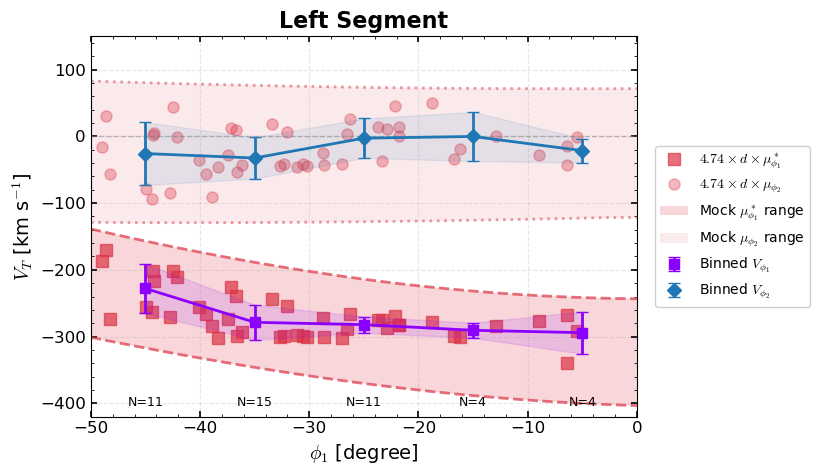

In [270]:

# ================== 可调参数 ==================
phi1_min, phi1_max = -50, 0       # 左段范围
bin_width = 10                    # 每 10° 一段
ms_data   = 8                     # 数据点大小

# ================== 数据筛选 ==================
# 亮星（可按需修改）
ind_G18 = (Gmag[ind_PM][ind_mem] < 18)

# 左段掩码（在 ind_G18 基础上）
mask_left_all = ind_G18 & (RPMphi1 >= phi1_min) & (RPMphi1 <= phi1_max)

# 提取左段数据
phi1_l = RPMphi1[mask_left_all]
pm1_l  = RPM_pmphi1[mask_left_all]
pm2_l  = RPM_pmphi2[mask_left_all]

# 距离（支持标量或数组）
if np.ndim(dist_iso) == 0:
    d_l = np.full_like(phi1_l, dist_iso, dtype=float)
else:
    d_l = dist_iso[mask_left_all]

# 切向速度 (km/s)
vt1_l = 4.74 * pm1_l * d_l
vt2_l = 4.74 * pm2_l * d_l

# 去除 NaN/Inf
finite = np.isfinite(phi1_l) & np.isfinite(vt1_l) & np.isfinite(vt2_l)
phi1_l, vt1_l, vt2_l = phi1_l[finite], vt1_l[finite], vt2_l[finite]

# ================== 分箱统计 ==================
bin_edges   = np.arange(phi1_min, phi1_max + bin_width, bin_width)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

mean_v1 = np.full(len(bin_centers), np.nan)
std_v1  = np.full(len(bin_centers), np.nan)
mean_v2 = np.full(len(bin_centers), np.nan)
std_v2  = np.full(len(bin_centers), np.nan)
counts  = np.zeros(len(bin_centers), dtype=int)

for i in range(len(bin_centers)):
    lo, hi = bin_edges[i], bin_edges[i+1]
    sel = (phi1_l >= lo) & ((phi1_l < hi) if i < len(bin_centers)-1 else (phi1_l <= hi))
    v1, v2 = vt1_l[sel], vt2_l[sel]
    n = v1.size
    counts[i] = n
    if n >= 2:
        mean_v1[i] = np.nanmean(v1)
        std_v1[i]  = np.nanstd(v1, ddof=1)  # 无偏标准差
        mean_v2[i] = np.nanmean(v2)
        std_v2[i]  = np.nanstd(v2, ddof=1)

# ================== 作图 ==================
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

# 原始散点
ax1.plot(phi1_l, vt1_l, "s", color="#DC3545", label=r"$4.74 \times d \times \mu_{\phi_1}^*$",
         ms=ms_data, alpha=0.7)
ax1.plot(phi1_l, vt2_l, "o", color="#DC3545", label=r"$4.74 \times d \times \mu_{\phi_2}$",
         ms=ms_data, alpha=0.35)

# Mock 区间（左段）
ax1.fill_between(x=mock_phi1_1, y1=min_vphi1_mock_1, y2=max_vphi1_mock_1,
                 facecolor="#DC3545", alpha=0.20, ec=None, label='Mock $\\mu_{\\phi_1}^*$ range')
ax1.fill_between(x=mock_phi1_1, y1=min_vphi2_mock_1, y2=max_vphi2_mock_1,
                 facecolor="#DC3545", alpha=0.10, ec=None, label='Mock $\\mu_{\\phi_2}$ range')
ax1.plot(mock_phi1_1, min_vphi1_mock_1, '--', color="#DC3545", alpha=0.7, lw=2)
ax1.plot(mock_phi1_1, max_vphi1_mock_1, '--', color="#DC3545", alpha=0.7, lw=2)
ax1.plot(mock_phi1_1, min_vphi2_mock_1, ':',  color="#DC3545", alpha=0.5, lw=2)
ax1.plot(mock_phi1_1, max_vphi2_mock_1, ':',  color="#DC3545", alpha=0.5, lw=2)

# 分箱均值 ±1σ 阴影 + 误差棒 + 连线
# V_phi1（绿色）
ax1.fill_between(bin_centers, mean_v1-std_v1, mean_v1+std_v1,
                 color='#8B00FF', alpha=0.12, zorder=2)
ax1.errorbar(bin_centers, mean_v1, yerr=std_v1, fmt='s', ms=7, lw=2, capsize=4,
             color='#8B00FF', label='Binned $V_{\\phi_1}$', zorder=3)
ax1.plot(bin_centers, mean_v1, '-', color='#8B00FF', lw=2, zorder=3)

# V_phi2（蓝色）
ax1.fill_between(bin_centers, mean_v2-std_v2, mean_v2+std_v2,
                 color="#1f77b4", alpha=0.10, zorder=2)
ax1.errorbar(bin_centers, mean_v2, yerr=std_v2, fmt='D', ms=7, lw=2, capsize=4,
             color="#1f77b4", label='Binned $V_{\\phi_2}$', zorder=3)
ax1.plot(bin_centers, mean_v2, '-', color="#1f77b4", lw=2, zorder=3)

# 在底部标注样本数
for x, n in zip(bin_centers, counts):
    ax1.text(x, 0.02, f"N={n}", ha='center', va='bottom',
             transform=ax1.get_xaxis_transform(), fontsize=9, color='k')

# 轴与标题
ax1.hlines(y=0, xmin=phi1_min, xmax=phi1_max, color="gray", ls="--", lw=1, alpha=0.5)
ax1.set_xlim([phi1_min, 0])
ax1.set_ylim([-420, 150])
ax1.tick_params(labelsize=12)
ax1.set_xlabel(r"$\phi_1$ [degree]", fontsize=14)
ax1.set_ylabel(r"$V_T$ [km s$^{-1}$]", fontsize=14)
ax1.set_title("Left Segment", fontsize=16, fontweight='bold')
ax1.grid(alpha=0.3, linestyle='--')

# 去重图例（同 label 只保留一次）
handles, labels = ax1.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax1.legend(unique.values(), unique.keys(),
           fontsize=10, framealpha=0.95,
           loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()


In [61]:
mock_n = 10000
#mock_pmra=np.random.uniform(min_pmra,max_pmra,mock_n)
mock_pmra=np.random.uniform(min_pmra,1,mock_n)
mock_pmdec=np.random.uniform(0.5,max_pmdec,mock_n)
mock_phi1 = np.linspace(min_phi1,max_phi1,201)
mock_dist = np.zeros_like(mock_phi1)+dist_iso #dist_phi1(mock_phi1)

# 按phi1的值分段
#transition_phi1 = (min_phi1 + max_phi1) / 2  # 或者你指定的具体phi1值
#mock_dist = np.where(mock_phi1 < transition_phi1, dist_iso, dist_iso_2)

mock_phi2 = np.random.uniform(min_phi2, max_phi2, mock_n)
min_vphi1_mock = np.zeros_like(mock_phi1)
max_vphi1_mock = np.zeros_like(mock_phi1)
min_vphi2_mock = np.zeros_like(mock_phi1)
max_vphi2_mock = np.zeros_like(mock_phi1)
for i_mock_phi1 in range(len(mock_phi1)):
# for i_mock_phi1 in range(1):
    mock_fr = gc.GreatCircleICRSFrame(
        phi1=(np.zeros_like(mock_phi2)+mock_phi1[i_mock_phi1])*u.degree,
        phi2=mock_phi2*u.degree,
        pole=frame.pole,
        origin=frame.origin
    )
    mock_equ = mock_fr.transform_to(coord.ICRS())
    mock_ra = mock_equ.ra.deg
    mock_dec = mock_equ.dec.deg

    mock_pmlMC, mock_pmbMC, mock_pmraMC, mock_pmdecMC = Correct_PM_From_Solar_Motion(mock_ra, mock_dec,
                                                                                     mock_pmra, mock_pmdec,
                                                                                     mock_ra*0+mock_dist[i_mock_phi1],
                                                                                     degree=True, radec=True)

    mock_coord = coord.SkyCoord(ra=mock_ra*u.deg,
                                dec=mock_dec*u.deg,
                                pm_ra_cosdec=mock_pmraMC*u.mas/u.yr,
                                pm_dec=mock_pmdecMC*u.mas/u.yr)
    
    mock_fr = mock_coord.transform_to(frame)
    cmock_phi1 = mock_fr.phi1.deg
    cmock_phi2 = mock_fr.phi2.deg
    cmock_pmphi1 = mock_fr.pm_phi1_cosphi2.value
    cmock_pmphi2 = mock_fr.pm_phi2.value
    
    min_vphi1_mock[i_mock_phi1] = np.min(cmock_pmphi1*mock_dist[i_mock_phi1]*4.74)
    max_vphi1_mock[i_mock_phi1] = np.max(cmock_pmphi1*mock_dist[i_mock_phi1]*4.74)
    
    min_vphi2_mock[i_mock_phi1] = np.min(cmock_pmphi2*mock_dist[i_mock_phi1]*4.74)
    max_vphi2_mock[i_mock_phi1] = np.max(cmock_pmphi2*mock_dist[i_mock_phi1]*4.74)
    
# here below is used to check the conversion
# c_mock = coord.SkyCoord(ra=mock_ra*u.deg,
#                         dec=mock_dec*u.deg,
#                         pm_ra_cosdec=mock_pmra*u.mas/u.yr,
#                         pm_dec=mock_pmdec*u.mas/u.yr)
# fr_mock = c_mock.transform_to(frame)
# plt.plot(mock_phi2, fr_mock.phi2.deg,'k.',ms=1)

In [31]:
ind_G18_1 = Gmag[ind_PM][ind_mem_1]<18
ind_G18_2 = Gmag[ind_PM][ind_mem_2]<18

bin_phi1_vphi = np.linspace(min_phi1,max_phi1,n_hist_phi1+1)
bin_phi1_vphi[1:]

mean_Vphi1 = np.zeros_like(bin_phi1_vphi[1:])
std_Vphi1 = np.zeros_like(bin_phi1_vphi[1:])
mean_Vphi2 = np.zeros_like(bin_phi1_vphi[1:])
std_Vphi2 = np.zeros_like(bin_phi1_vphi[1:])

ind_phi1_tmp_1 = (RPMphi1_1[ind_G18_1]>-50) & (RPMphi1_1[ind_G18_1]<0)
mean_Vphi1[0] = np.mean(4.74*RPM_pmphi1_1[ind_G18_1][ind_phi1_tmp_1]*dist_iso)
std_Vphi1[0] = np.std(4.74*RPM_pmphi1_1[ind_G18_1][ind_phi1_tmp_1]*dist_iso)
mean_Vphi2[0] = np.mean(4.74*RPM_pmphi2_1[ind_G18_1][ind_phi1_tmp_1]*dist_iso)
std_Vphi2[0] = np.std(4.74*RPM_pmphi2_1[ind_G18_1][ind_phi1_tmp_1]*dist_iso)

ind_phi1_tmp_2 = (RPMphi1_2[ind_G18_2]>-50) & (RPMphi1_2[ind_G18_2]<0)
mean_Vphi1[1] = np.mean(4.74*RPM_pmphi1_2[ind_G18_2][ind_phi1_tmp_2]*dist_iso_2)
std_Vphi1[1] = np.std(4.74*RPM_pmphi1_2[ind_G18_2][ind_phi1_tmp_2]*dist_iso_2)
mean_Vphi2[1] = np.mean(4.74*RPM_pmphi1_2[ind_G18_2][ind_phi1_tmp_2]*dist_iso_2)
std_Vphi2[1] = np.std(4.74*RPM_pmphi2_2[ind_G18_2][ind_phi1_tmp_2]*dist_iso_2)


In [32]:
# 定义选择框范围
rv_min, rv_max = -50, 50
mh_min, mh_max = -2.5, -1.5

# 计算哪些星在框外
mask_out_L = (RV_L < rv_min) | (RV_L > rv_max) | (MH_L < mh_min) | (MH_L > mh_max)
mask_out_D = (RV_D < rv_min) | (RV_D > rv_max) | (MH_D < mh_min) | (MH_D > mh_max)
mask_out_S = (RV_S < rv_min) | (RV_S > rv_max) | (MH_S < mh_min) | (MH_S > mh_max)

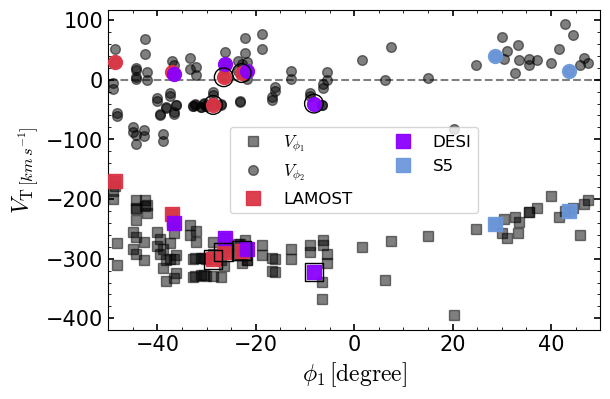

In [33]:
# ========== 转换到流坐标系 ==========
# LAMOST
Lcoord = coord.SkyCoord(
    ra=ra_L*u.deg,
    dec=dec_L*u.deg,
    pm_ra_cosdec=S_pmraMC_L*u.mas/u.yr,
    pm_dec=S_pmdecMC_L*u.mas/u.yr
)
Lfr = Lcoord.transform_to(frame)
LPMphi1 = Lfr.phi1.deg
LPM_pmphi1 = Lfr.pm_phi1_cosphi2.value
LPM_pmphi2 = Lfr.pm_phi2.value

# DESI
Dcoord = coord.SkyCoord(
    ra=ra_D*u.deg,
    dec=dec_D*u.deg,
    pm_ra_cosdec=S_pmraMC_D*u.mas/u.yr,
    pm_dec=S_pmdecMC_D*u.mas/u.yr
)
Dfr = Dcoord.transform_to(frame)
DPMphi1 = Dfr.phi1.deg
DPM_pmphi1 = Dfr.pm_phi1_cosphi2.value
DPM_pmphi2 = Dfr.pm_phi2.value

# S5
Scoord = coord.SkyCoord(
    ra=ra_S*u.deg,
    dec=dec_S*u.deg,
    pm_ra_cosdec=S_pmraMC_S*u.mas/u.yr,
    pm_dec=S_pmdecMC_S*u.mas/u.yr
)
Sfr = Scoord.transform_to(frame)
SPMphi1 = Sfr.phi1.deg
SPM_pmphi1 = Sfr.pm_phi1_cosphi2.value
SPM_pmphi2 = Sfr.pm_phi2.value

# ========== 绘图 ==========

fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.15,0.18, 0.82, 0.8])

# 灰色阴影区域
# plt.fill_between(x=mock_phi1,
#                  y1=min_vphi1_mock,
#                  y2=max_vphi1_mock,
#                  facecolor="#1f77b4", alpha=0.2, ec=None, zorder=1)
# 
# plt.fill_between(x=mock_phi1,
#                  y1=min_vphi2_mock,
#                  y2=max_vphi2_mock,
#                  facecolor="#ff7f0e", alpha=0.2, ec=None, zorder=1)

# plt.plot(mock_phi1, min_vphi1_mock, '--', color="#1f77b4", lw=2, zorder=2)
# plt.plot(mock_phi1, max_vphi1_mock, '--', color="#1f77b4", lw=2, zorder=2)
# plt.plot(mock_phi1, min_vphi2_mock, ':', color="#ff7f0e", lw=2, zorder=2)
# plt.plot(mock_phi1, max_vphi2_mock, ':', color="#ff7f0e", lw=2, zorder=2)

# 零线
plt.hlines(y=0, xmin=-100, xmax=100, color="gray", ls="--", zorder=1)

# Gaia 主样本（黑色小点）
plt.plot(RPMphi1_1[ind_G18_1], 4.74*RPM_pmphi1_1[ind_G18_1]*dist_iso, 
         "ks", label=r"$V_{\phi_1}$", ms=7, alpha=0.5, zorder=2)
plt.plot(RPMphi1_1[ind_G18_1], 4.74*RPM_pmphi2_1[ind_G18_1]*dist_iso, 
         "ko", label=r"$V_{\phi_2}$", ms=7, alpha=0.5, zorder=2)

plt.plot(RPMphi1_2[ind_G18_2], 4.74*RPM_pmphi1_2[ind_G18_2]*dist_iso_2, 
         "ks", ms=7, alpha=0.5, zorder=2)
plt.plot(RPMphi1_2[ind_G18_2], 4.74*RPM_pmphi2_2[ind_G18_2]*dist_iso_2, 
         "ko", ms=7, alpha=0.5, zorder=2)

# 光谱巡天数据（彩色大点）
# LAMOST
plt.plot(LPMphi1, 4.74*LPM_pmphi1*dist_iso, 
           "s", color='#DC3545', ms=10,
           label='LAMOST', alpha=0.95, zorder=4)
plt.plot(LPMphi1, 4.74*LPM_pmphi2*dist_iso, 
           "o", color='#DC3545', ms=10,
           alpha=0.95, zorder=4)

# DESI
plt.plot(DPMphi1, 4.74*DPM_pmphi1*dist_iso, 
           "s", color='#8B00FF', ms=10,
           label='DESI', alpha=0.95, zorder=4)
plt.plot(DPMphi1, 4.74*DPM_pmphi2*dist_iso, 
           "o", color='#8B00FF', ms=10,
           alpha=0.95, zorder=4)

# S5
plt.plot(SPMphi1, 4.74*SPM_pmphi1*dist_iso_2, 
           "s", color='#6B98DC', ms=10,
           label='S5', alpha=0.95, zorder=4)
plt.plot(SPMphi1, 4.74*SPM_pmphi2*dist_iso_2, 
           "o", color='#6B98DC', ms=10,
           alpha=0.95, zorder=4)

# ========== 用黑色圆圈标记框外的星 ==========
# LAMOST 框外星 - 需要同时标记 phi1 和 phi2 方向
if np.any(mask_out_L):
    plt.scatter(LPMphi1[mask_out_L], 4.74*LPM_pmphi1[mask_out_L]*dist_iso,
               s=180, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=10, marker='s')
    plt.scatter(LPMphi1[mask_out_L], 4.74*LPM_pmphi2[mask_out_L]*dist_iso,
               s=180, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=10, marker='o')

# DESI 框外星
if np.any(mask_out_D):
    plt.scatter(DPMphi1[mask_out_D], 4.74*DPM_pmphi1[mask_out_D]*dist_iso,
               s=180, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=10, marker='s')
    plt.scatter(DPMphi1[mask_out_D], 4.74*DPM_pmphi2[mask_out_D]*dist_iso,
               s=180, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=10, marker='o')

# S5 框外星
if np.any(mask_out_S):
    plt.scatter(SPMphi1[mask_out_S], 4.74*SPM_pmphi1[mask_out_S]*dist_iso_2,
               s=180, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=10, marker='s')
    plt.scatter(SPMphi1[mask_out_S], 4.74*SPM_pmphi2[mask_out_S]*dist_iso_2,
               s=180, facecolors='none', edgecolors='black', 
               linewidths=1, zorder=10, marker='o')

# 图例和标签
plt.xlim([-50, 50])
plt.legend(loc="center", fontsize=12, ncol=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r"$\phi_1\,\mathrm{[degree]}$", fontsize=17)
plt.ylabel(r"$V_{\mathrm{T}\,[km\,s^{-1}]}$", fontsize=17)
plt.savefig("/home/zyh/stream/palomar5_sibling/plot/velocity.png", dpi=200, bbox_inches='tight')
plt.show()

In [34]:
# 计算 Gaia 主样本（灰色背景点）的速度弥散

# 收集所有 Gaia 样本的 V_phi1 (黑色方形 "ks")
v_phi1_gaia = []
v_phi1_gaia.extend(4.74 * RPM_pmphi1_1[ind_G18_1] * dist_iso)
v_phi1_gaia.extend(4.74 * RPM_pmphi1_2[ind_G18_2] * dist_iso_2)
v_phi1_gaia = np.array(v_phi1_gaia)

# 收集所有 Gaia 样本的 V_phi2 (黑色圆形 "ko")
v_phi2_gaia = []
v_phi2_gaia.extend(4.74 * RPM_pmphi2_1[ind_G18_1] * dist_iso)
v_phi2_gaia.extend(4.74 * RPM_pmphi2_2[ind_G18_2] * dist_iso_2)
v_phi2_gaia = np.array(v_phi2_gaia)

# 计算弥散
sigma_v_phi1_gaia = np.std(v_phi1_gaia, ddof=1)
mean_v_phi1_gaia = np.mean(v_phi1_gaia)

sigma_v_phi2_gaia = np.std(v_phi2_gaia, ddof=1)
mean_v_phi2_gaia = np.mean(v_phi2_gaia)

print(f"Gaia 样本 V_φ1 (方形) 弥散: σ = {sigma_v_phi1_gaia:.2f} km/s")
print(f"Gaia 样本 V_φ1 平均值: <V> = {mean_v_phi1_gaia:.2f} km/s")
print(f"样本数量: {len(v_phi1_gaia)}")

print()

print(f"Gaia 样本 V_φ2 (圆形) 弥散: σ = {sigma_v_phi2_gaia:.2f} km/s")
print(f"Gaia 样本 V_φ2 平均值: <V> = {mean_v_phi2_gaia:.2f} km/s")
print(f"样本数量: {len(v_phi2_gaia)}")

Gaia 样本 V_φ1 (方形) 弥散: σ = 42.35 km/s
Gaia 样本 V_φ1 平均值: <V> = -273.47 km/s
样本数量: 114

Gaia 样本 V_φ2 (圆形) 弥散: σ = 44.14 km/s
Gaia 样本 V_φ2 平均值: <V> = -5.92 km/s
样本数量: 114


In [35]:
ll_disk = np.linspace(0,360,10001)
bb_disk_list = np.array([17,18,19,20,21])
str_bb_disk_list = np.array(['17','18','19','20','21'])
clr_bb_disk_list = np.array(["orangered","sandybrown","dodgerblue","darkturquoise","darkviolet","deeppink"])

Phi_disk_rcd = {}
for i_bb_disk_list in range(len(str_bb_disk_list)):
    radec_disk_tmp = guc.lb_to_radec(ll_disk, ll_disk*0+bb_disk_list[i_bb_disk_list], degree=True)
    C_disk_tmp = coord.SkyCoord(ra=radec_disk_tmp[:,0]*u.deg,dec=radec_disk_tmp[:,1]*u.deg)
    C_disk_fr = C_disk_tmp.transform_to(frame)
    Phi_disk_rcd[str_bb_disk_list[i_bb_disk_list]+"_phi1"] = C_disk_fr.phi1.deg
    Phi_disk_rcd[str_bb_disk_list[i_bb_disk_list]+"_phi2"] = C_disk_fr.phi2.deg


In [36]:
Phi_disk_rcd[str_bb_disk_list[i_bb_disk_list]]=10

In [37]:
fn_sl = "/home/zyh/stream/S2808stream/GDR3_SCAN_LAW.fits"
dt_sl = fits.open(fn_sl)
data_sl = dt_sl[1].data
ra_sl = data_sl["ra_fov1"]
dec_sl = data_sl["dec_fov1"]

C_SL = coord.SkyCoord(ra=ra_sl*u.deg,dec=dec_sl*u.deg)
C_SL_fr = C_SL.transform_to(frame)
SLphi1 = C_SL_fr.phi1.deg
SLphi2 = C_SL_fr.phi2.deg
bin_phi1_sl = np.linspace(-100,100,401)
bin_phi2_sl = np.linspace(-15,15,161)
H_sl_phi, Hx_sl_phi, Hy_sl_phi = np.histogram2d(SLphi1, SLphi2, bins=(bin_phi1_sl, bin_phi2_sl))

In [38]:
from scipy.optimize import curve_fit

def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def calculate_stream_snr(phi1_data, phi2_data, phi1_min, phi1_max, phi2_min, phi2_max, n_bins):
    """计算某段星流的SNR"""
    ind_seg = (phi1_data > phi1_min) & (phi1_data < phi1_max) & \
              (phi2_data > phi2_min) & (phi2_data < phi2_max)
    
    bin_phi2 = np.linspace(phi2_min, phi2_max, n_bins+1)
    hy_phi2, hx_phi2 = np.histogram(phi2_data[ind_seg], bins=bin_phi2)
    
    # 高斯拟合
    try:
        parameters, covariance = curve_fit(gauss, (hx_phi2[1:]+hx_phi2[:-1])*0.5, hy_phi2)
        para_err = np.sqrt(np.diag(covariance))
        amplitude = parameters[1] * np.sqrt(2*np.pi) * parameters[3]
        amplitude_err = para_err[1] * np.sqrt(2*np.pi) * parameters[3]
        
        # 计算SNR
        ind_phi2_bg = np.abs((hx_phi2[1:]+hx_phi2[:-1])*0.5) > 2
        background_std = np.std(hy_phi2[ind_phi2_bg])
        SNR = amplitude / background_std if background_std > 0 else 0
        
        # 生成拟合曲线
        sxx = np.linspace(phi2_min, phi2_max, 1000)
        syy = gauss(sxx, *parameters)
        
        return {
            'ind': ind_seg,
            'bins': hx_phi2,
            'counts': hy_phi2,
            'fit_x': sxx,
            'fit_y': syy,
            'params': parameters,
            'amplitude': amplitude,
            'amplitude_err': amplitude_err,
            'SNR': SNR,
            'background_std': background_std,
            'n_stars': np.sum(ind_seg)
        }
    except:
        return None

# ========== 分段计算 ==========
phi1_split = 0  # 分割点
phi2_min = min_hist_phi2
phi2_max = max_hist_phi2
n_bins = n_hist_phi2

# 左段
left_result = calculate_stream_snr(
    Gphi1[ind_PM], Gphi2[ind_PM], 
    min_phi1, phi1_split, 
    phi2_min, phi2_max, n_bins
)

# 右段  
right_result = calculate_stream_snr(
    Gphi1[ind_PM], Gphi2[ind_PM], 
    phi1_split, max_phi1, 
    phi2_min, phi2_max, n_bins
)

# ========== 打印统计信息 ==========
if left_result:
    print("="*50)
    print("LEFT SEGMENT:")
    print(f"  N stars: {left_result['n_stars']}")
    print(f"  Amplitude: {left_result['amplitude']:.1f} ± {left_result['amplitude_err']:.1f}")
    print(f"  Background std: {left_result['background_std']:.2f}")
    print(f"  SNR: {left_result['SNR']:.1f}")
    print(f"  Width: {np.deg2rad(left_result['params'][3])*dist_iso:.3f} kpc")

if right_result:
    print("="*50)
    print("RIGHT SEGMENT:")
    print(f"  N stars: {right_result['n_stars']}")
    print(f"  Amplitude: {right_result['amplitude']:.1f} ± {right_result['amplitude_err']:.1f}")
    print(f"  Background std: {right_result['background_std']:.2f}")
    print(f"  SNR: {right_result['SNR']:.1f}")
    print(f"  Width: {np.deg2rad(right_result['params'][3])*dist_iso:.3f} kpc")
    print("="*50)

LEFT SEGMENT:
  N stars: 142
  Amplitude: 112.7 ± 12.2
  Background std: 2.92
  SNR: 38.5
  Width: 0.457 kpc
RIGHT SEGMENT:
  N stars: 156
  Amplitude: 86.0 ± 14.4
  Background std: 3.03
  SNR: 28.4
  Width: 0.596 kpc


In [39]:
# 加上箭头
# ========== 转换自行到流坐标系 ==========

# ---------- LAMOST ----------
# 太阳运动改正
S_pmlMC_L, S_pmbMC_L, S_pmraMC_L, S_pmdecMC_L = Correct_PM_From_Solar_Motion(
    ra_L, dec_L, pmra_L, pmdec_L, 
    ra_L*0 + dist_iso,
    degree=True, radec=True
)

# 转换自行到流坐标系
Lcoord = coord.SkyCoord(
    ra=ra_L*u.deg,
    dec=dec_L*u.deg,
    pm_ra_cosdec=S_pmraMC_L*u.mas/u.yr,
    pm_dec=S_pmdecMC_L*u.mas/u.yr
)
Lfr = Lcoord.transform_to(frame)
LPM_pmphi1 = Lfr.pm_phi1_cosphi2.value
LPM_pmphi2 = Lfr.pm_phi2.value

# ---------- DESI ----------
S_pmlMC_D, S_pmbMC_D, S_pmraMC_D, S_pmdecMC_D = Correct_PM_From_Solar_Motion(
    ra_D, dec_D, pmra_D, pmdec_D, 
    ra_D*0 + dist_iso,
    degree=True, radec=True
)

Dcoord = coord.SkyCoord(
    ra=ra_D*u.deg,
    dec=dec_D*u.deg,
    pm_ra_cosdec=S_pmraMC_D*u.mas/u.yr,
    pm_dec=S_pmdecMC_D*u.mas/u.yr
)
Dfr = Dcoord.transform_to(frame)
DPM_pmphi1 = Dfr.pm_phi1_cosphi2.value
DPM_pmphi2 = Dfr.pm_phi2.value

# ---------- S5 ----------
S_pmlMC_S, S_pmbMC_S, S_pmraMC_S, S_pmdecMC_S = Correct_PM_From_Solar_Motion(
    ra_S, dec_S, pmra_S, pmdec_S, 
    ra_S*0 + dist_iso,
    degree=True, radec=True
)

Scoord = coord.SkyCoord(
    ra=ra_S*u.deg,
    dec=dec_S*u.deg,
    pm_ra_cosdec=S_pmraMC_S*u.mas/u.yr,
    pm_dec=S_pmdecMC_S*u.mas/u.yr
)
Sfr = Scoord.transform_to(frame)
SPM_pmphi1 = Sfr.pm_phi1_cosphi2.value
SPM_pmphi2 = Sfr.pm_phi2.value

# ========== 合并数据用于绘制箭头 ==========
phi1_all = np.concatenate([phi1_L, phi1_D, phi1_S])
phi2_all = np.concatenate([phi2_L, phi2_D, phi2_S])
pmphi1_all = np.concatenate([LPM_pmphi1, DPM_pmphi1, SPM_pmphi1])
pmphi2_all = np.concatenate([LPM_pmphi2, DPM_pmphi2, SPM_pmphi2])

# 距离信息（统一距离）
dist_all = np.ones_like(phi1_all) * dist_iso

# survey标识（用于不同颜色/标记）
survey_label = np.concatenate([
    np.full(len(phi1_L), 0),  # LAMOST = 0
    np.full(len(phi1_D), 1),  # DESI = 1
    np.full(len(phi1_S), 2)   # S5 = 2
])

print(f"Total spectroscopic stars: {len(phi1_all)}")
print(f"  LAMOST: {len(phi1_L)}")
print(f"  DESI: {len(phi1_D)}")
print(f"  S5: {len(phi1_S)}")

Total spectroscopic stars: 11
  LAMOST: 5
  DESI: 4
  S5: 2


In [44]:
min_plot_phi1, max_plot_phi1 = config["plot_phi1_phi2"].getfloat("min_plot_phi1"), config["plot_phi1_phi2"].getfloat("max_plot_phi1")
min_plot_phi2, max_plot_phi2 = config["plot_phi1_phi2"].getfloat("min_plot_phi2"), config["plot_phi1_phi2"].getfloat("max_plot_phi2")

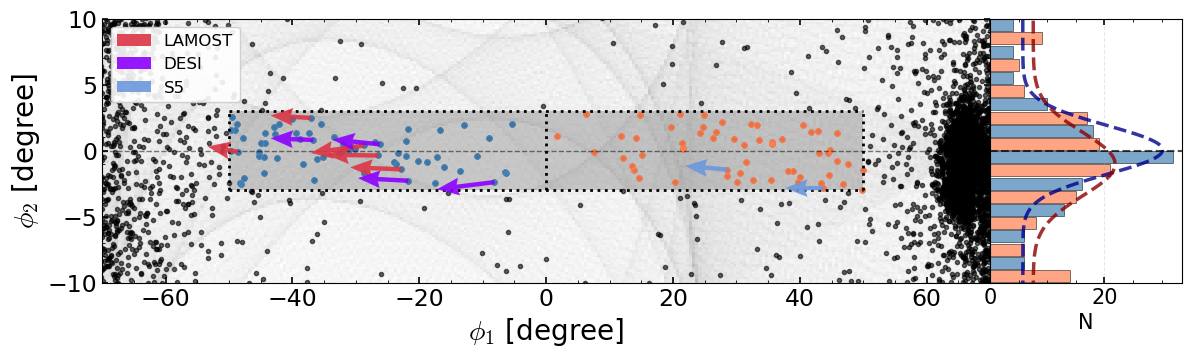

In [45]:
fig = plt.figure(figsize=(12, 4))

# 左侧主图
ax_main = fig.add_axes([0.08, 0.3, 0.74, 0.66])

plt.pcolormesh(Hx_sl_phi, Hy_sl_phi, H_sl_phi.T, cmap="binary", alpha=1)
plt.fill_between(x=[min_phi1, max_phi1],
                 y1=[min_phi2, min_phi2],
                 y2=[max_phi2, max_phi2], facecolor="gray", alpha=0.4, ec=None)

plt.vlines(x=[max_phi1, min_phi1], ymin=min_phi2, ymax=max_phi2, 
          color="k", linestyle=":", linewidth=2)
plt.hlines(y=[max_phi2, min_phi2], xmin=min_phi1, xmax=max_phi1, 
          color="k", linestyle=":", linewidth=2)
plt.plot(Gphi1[ind_PM], Gphi2[ind_PM], 'o', color="k", alpha=0.6, zorder=1, ms=3)
plt.plot(RPMphi1, RPMphi2, 'ko', ms=3, alpha=1, zorder=1)

# 成员星（更亮的点）
ind_mem_left = (RPMphi1 > min_phi1) & (RPMphi1 < phi1_split)
ind_mem_right = (RPMphi1 >= phi1_split) & (RPMphi1 < max_phi1)

ax_main.scatter(RPMphi1[ind_mem_left], RPMphi2[ind_mem_left], 
               s=15, c='steelblue', alpha=0.9)
ax_main.scatter(RPMphi1[ind_mem_right], RPMphi2[ind_mem_right], 
               s=15, c='coral', alpha=0.9)

# ========== 添加自行箭头（按survey分别绘制）==========
# LAMOST - 红色
quiver_L = ax_main.quiver(phi1_L, phi2_L, 
                          LPM_pmphi1 * 4.74 * dist_iso, 
                          LPM_pmphi2 * 4.74 * dist_iso,
                          scale=5000, width=0.005, 
                          headwidth=4, headlength=5,
                          color='#DC3545', alpha=0.9, zorder=10,
                          label="LAMOST")

# DESI - 紫色
quiver_D = ax_main.quiver(phi1_D, phi2_D, 
                          DPM_pmphi1 * 4.74 * dist_iso, 
                          DPM_pmphi2 * 4.74 * dist_iso,
                          scale=5000, width=0.005, 
                          headwidth=4, headlength=5,
                          color='#8B00FF', alpha=0.9, zorder=10,
                          label="DESI")

# S5 - 蓝色
quiver_S = ax_main.quiver(phi1_S, phi2_S, 
                          SPM_pmphi1 * 4.74 * dist_iso, 
                          SPM_pmphi2 * 4.74 * dist_iso,
                          scale=5000, width=0.005, 
                          headwidth=4, headlength=5,
                          color='#6B98DC', alpha=0.9, zorder=10,
                          label="S5")

# 分界线
ax_main.vlines(x=phi1_split, ymin=-3, ymax=3, color='k', ls=':', lw=2)
ax_main.axhline(0, color='k', ls='--', lw=1, alpha=0.5)

ax_main.set_xlim([min_plot_phi1, max_plot_phi1])
ax_main.set_ylim([-10, 10])
ax_main.set_xlabel(r'$\phi_1$ [degree]', fontsize=20)
ax_main.set_ylabel(r'$\phi_2$ [degree]', fontsize=20)
ax_main.tick_params(labelsize=17)
ax_main.legend(loc='upper left', fontsize=12, framealpha=0.9)

# 右侧对比直方图
ax_hist = fig.add_axes([0.82, 0.3, 0.16, 0.66])

if left_result and right_result:
    bin_centers = (left_result['bins'][:-1] + left_result['bins'][1:]) / 2
    bin_width = np.diff(left_result['bins'])[0]
    
    counts_left = left_result['counts']
    counts_right = right_result['counts']
    
    # 并排柱状图
    ax_hist.barh(bin_centers - bin_width/4, counts_left, 
                height=bin_width/2.2, color='steelblue', alpha=0.7, 
                edgecolor='k', linewidth=0.5)
    ax_hist.barh(bin_centers + bin_width/4, counts_right, 
                height=bin_width/2.2, color='coral', alpha=0.7, 
                edgecolor='k', linewidth=0.5)
    
    # 高斯拟合曲线
    ax_hist.plot(left_result['fit_y'], left_result['fit_x'], 
                '--', color='darkblue', lw=2.5, alpha=0.8)
    ax_hist.plot(right_result['fit_y'], right_result['fit_x'], 
                '--', color='darkred', lw=2.5, alpha=0.8)

ax_hist.axhline(0, color='k', ls='--', lw=1.5, alpha=0.7)
ax_hist.set_yticks([])
ax_hist.set_ylim([-10, 10])
ax_hist.set_xlabel('N', fontsize=15)
ax_hist.tick_params(labelsize=15)
ax_hist.grid(axis='x', alpha=0.3, ls='--')
plt.savefig("/home/zyh/stream/palomar5_sibling/plot/stream.png", dpi = 200,bbox_inches='tight')
plt.show()

In [46]:
### 运动学 & Palomar5
import galpy.util.coords as gub
from astropy.coordinates import SkyCoord
from astropy import constants as c
u_sun=11.1
v_sun=12.24
w_sun=7.25
x_sun=8.3
v_lsr=232.
Msun = 1.9884e30
Mhalo=1.25e12*Msun
Mdisk=0.065*Mhalo
Mbulge=0.01*Mhalo
rh=38.35*1.0e3*c.pc.value
b0=3.5*1.0e3*c.pc.value
c0=0.15*b0

In [47]:
GCs = fits.open(f"/home/zyh/stream/S2808stream/GC_PM_catalog_Vasiliev.fits")
GCs_data = GCs[1].data
name_gc, ra_gc, dec_gc, dist_gc, HRV_gc, pmRA_gc, pmDE_gc = GCs_data["Name"], np.array(GCs_data["RAdeg"]),np.array(GCs_data["DEdeg"]),np.array(GCs_data["Dist"]),np.array(GCs_data["HRV"]),np.array(GCs_data["pmRA"]),np.array(GCs_data["pmDE"])

In [48]:
# 匹配H99系列GCs

import pandas as pd
target_gcs = [
    "E 3", "Rup 106", "Pal 5",
    "NGC 4590", "NGC 5024", "NGC 5053", "NGC 5272", "NGC 6981",
    "NGC 5634", "NGC 5904"
]

extracted_gcs = []
for target in target_gcs:
    # 寻找匹配的星团（忽略大小写和空格差异）
    matches = [i for i, name in enumerate(name_gc) 
               if name.strip().upper() == target.strip().upper()]
    
    if matches:
        idx = matches[0]
        extracted_gcs.append({
            'Name': name_gc[idx],
            'RA': ra_gc[idx],
            'Dec': dec_gc[idx],
            'Distance': dist_gc[idx],
            'HRV': HRV_gc[idx],
            'pmRA': pmRA_gc[idx],
            'pmDE': pmDE_gc[idx]
        })

df_extracted = pd.DataFrame(extracted_gcs)

if len(extracted_gcs) > 0:
    names_target = np.array([gc['Name'] for gc in extracted_gcs])
    ra_target = np.array([gc['RA'] for gc in extracted_gcs])
    dec_target = np.array([gc['Dec'] for gc in extracted_gcs])
    dist_target = np.array([gc['Distance'] for gc in extracted_gcs])
    hrv_target = np.array([gc['HRV'] for gc in extracted_gcs])
    pmra_target = np.array([gc['pmRA'] for gc in extracted_gcs])
    pmde_target = np.array([gc['pmDE'] for gc in extracted_gcs])

print("\n" + "="*80)
print("提取的球状星团参数:")
print("="*80)
print(df_extracted.to_string(index=False))
    


提取的球状星团参数:
    Name      RA     Dec  Distance     HRV   pmRA   pmDE
     E 3 140.238 -77.282       8.1    4.93 -2.695  7.115
 Rup 106 189.667 -51.150      21.2  -38.42 -1.263  0.399
   Pal 5 229.022  -0.112      23.2  -58.60 -2.736 -2.646
NGC 4590 189.867 -26.744      10.3  -92.99 -2.752  1.762
NGC 5024 198.230  18.168      17.9  -62.85 -0.148 -1.355
NGC 5053 199.113  17.700      17.4   42.77 -0.366 -1.248
NGC 5272 205.548  28.377      10.2 -147.28 -0.142 -2.647
NGC 6981 313.365 -12.537      17.0 -331.39 -1.233 -3.290
NGC 5634 217.405  -5.976      25.2  -16.07 -1.724 -1.507
NGC 5904 229.638   2.081       7.5   53.70  4.078 -9.854


In [207]:
# LAMOST
mask_in_L = ~mask_out_L
# DESI
mask_in_D = ~mask_out_D
# S5
mask_in_S = ~mask_out_S

ra_all = np.concatenate([ra_L[mask_in_L], ra_D[mask_in_D], ra_S[mask_in_S]])
dec_all = np.concatenate([dec_L[mask_in_L], dec_D[mask_in_D], dec_S[mask_in_S]])
pmra_all = np.concatenate([pmra_L[mask_in_L], pmra_D[mask_in_D], pmra_S[mask_in_S]])
pmdec_all = np.concatenate([pmdec_L[mask_in_L], pmdec_D[mask_in_D], pmdec_S[mask_in_S]])
RV_all = np.concatenate([RV_L[mask_in_L], RV_D[mask_in_D], RV_S[mask_in_S]])

In [129]:
llbb_mem = guc.radec_to_lb(ra_all,
                           dec_all,degree=True)

llbb_mem_D = guc.radec_to_lb(ra_D[mask_in_D], dec_D[mask_in_D],degree=True)
llbb_mem_L = guc.radec_to_lb(ra_L[mask_in_L], dec_L[mask_in_L],degree=True)
llbb_mem_S = guc.radec_to_lb(ra_S[mask_in_S], dec_S[mask_in_S],degree=True)

# mass_nfw = 5.5
pot_bulge = agama.Potential(type='Dehnen', scaleRadius=1.0, gamma=1.0, mass=2e10)
pot_disk = agama.Potential(type='MiyamotoNagai', scaleRadius=3.0, scaleHeight=0.3, mass=5e10)
pot_halo = agama.Potential(type='NFW', scaleRadius=15.0, mass=1e12)
pot_total = agama.Potential(pot_bulge, pot_disk, pot_halo)

agama.setUnits(mass=1, length=1, velocity=1)
    
    Msun = 1.9884e30  # kg
    Mhalo = 1.25e12 * Msun  # kg
    
    Mdisk = 0.065 * Mhalo
    Mbulge = 0.01 * Mhalo
    
    Mhalo_unit = 1.25e12  # 太阳质量
    Mdisk_unit = 0.065 * Mhalo_unit
    Mbulge_unit = 0.01 * Mhalo_unit
    
    # 长度参数转换（假设输入是 pc，转换到 kpc）
    rh = 38.35  # kpc (从 38.35*1e3 pc 转换)
    b0 = 3.5    # kpc
    c0 = 0.15 * b0
    
    # Bulge: Dehnen 模型
    pot_bulge = agama.Potential(
        type='Dehnen',
        scaleRadius=c0,      # 核心半径
        gamma=1.0,           # 坡度参数
        mass=Mbulge_unit
    )
    
    # Disk: Miyamoto-Nagai 模型
    pot_disk = agama.Potential(
        type='MiyamotoNagai',
        scaleRadius=b0,      # 盘的标度长度
        scaleHeight=0.3,     # 盘的厚度
        mass=Mdisk_unit
    )
    
    # Halo: NFW 模型
    pot_halo = agama.Potential(
        type='NFW',
        scaleRadius=rh,      # NFW 标度半径
        mass=Mhalo_unit
    )


In [272]:
def calc_actions(ra, dec, dist, pmra, pmdec, RV):
    llbb = guc.radec_to_lb(ra, dec, degree=True)
    xyz = guc.lbd_to_XYZ(llbb[:,0], llbb[:,1],dist,degree=True)
    x_gc = X_Sun - xyz[:,0]
    y_gc = xyz[:,1]
    z_gc = xyz[:,2]
    
    pmllbb = guc.pmrapmdec_to_pmllpmbb(pmra, pmdec, ra, dec,degree=True)
    vxvyvz = guc.vrpmllpmbb_to_vxvyvz(RV, pmllbb[:,0], pmllbb[:,1], llbb[:,0], llbb[:,1], dist, degree=True)
    vx_gc = -1*(vxvyvz[:,0] + U_Sun)
    vy_gc = vxvyvz[:,1] + V_Sun + V_LSR
    vz_gc = vxvyvz[:,2] + W_Sun
    
    agama.setUnits(mass=1, length=1, velocity=1)
    pot_bulge = agama.Potential(type='Dehnen', scaleRadius=1.0, gamma=1.0, mass=2e10)
    pot_disk = agama.Potential(type='MiyamotoNagai', scaleRadius=3.0, scaleHeight=0.3, mass=5e10)
    pot_halo = agama.Potential(type='NFW', scaleRadius=15.0, mass=1.2e12)
    pot_total = agama.Potential(pot_bulge, pot_disk, pot_halo)
    pot_total = agama.Potential(pot_bulge, pot_disk, pot_halo)
    
    pos = np.zeros((len(x_gc), 3))
    pos[:,0] = x_gc
    pos[:,1] = y_gc
    pos[:,2] = z_gc
    
    # ========== 计算能量 ==========
    potential = pot_total.potential(pos)
    v_mag_sq = vx_gc**2 + vy_gc**2 + vz_gc**2
    kinetic = 0.5 * v_mag_sq
    energy = potential + kinetic

    sample = np.zeros((len(x_gc), 6))
    sample[:, 0] = x_gc
    sample[:, 1] = y_gc
    sample[:, 2] = z_gc
    sample[:, 3] = vx_gc     #-(vxvyvz[ind, 0][:] + U_Sun)
    sample[:, 4] = vy_gc          # (vxvyvz[ind, 1][:] + V_Sun + V_LSR)
    sample[:, 5] = vz_gc         #(vxvyvz[ind, 2][:] + W_Sun)
    af_fudge = agama.ActionFinder(pot_total, interp=False)
    act_tmp = af_fudge(sample)

    actions = Table()
    actions["JR"] = act_tmp[:, 0]
    actions["JZ"] = act_tmp[:, 1]
    actions["JP"] = act_tmp[:, 2]
    actions["Jtot"] = actions["JR"] + actions["JZ"] + np.abs(actions["JP"])
    actions["E"] = energy
    
    return sample, actions

In [273]:
sample_A, actions_A = calc_actions(ra_all, 
                              dec_all,
                              dist_iso,
                              pmra_all, 
                              pmdec_all,
                              RV_all)

fn_gc = "/home/zyh/stream/S2808stream/GC_PM_catalog_Vasiliev.fits"
dt_gc = fits.open(fn_gc)
data_gc = dt_gc[1].data
ra_gc = data_gc["RAdeg"]
dec_gc = data_gc["DEdeg"]
dist_gc = data_gc["Dist"]
pmra_gc = data_gc["pmRA"]
pmdec_gc = data_gc["pmDE"]
RV_gc = data_gc["HRV"]
llbb_gc = guc.radec_to_lb(ra_gc, dec_gc, degree=True)
xyz_gc = guc.lbd_to_XYZ(llbb_gc[:,0],llbb_gc[:,1],dist_gc,degree=True)

fn_dg = "/home/zyh/stream/S2808stream/dwarfgalaxies_drlica-Wagner2020.fits"
dt_dg = fits.open(fn_dg)
data_dg = dt_dg[1].data
name_dg = np.array(data_dg["name"])
ra_dg = np.array(data_dg["ra"])
dec_dg = np.array(data_dg["dec"])
ID_dg = np.array(data_dg["name"])
dist_dg = np.array(data_dg["dist"])
X_sun_dg = np.array(data_dg["Xkpc"])
Y_sun_dg = np.array(data_dg["Ykpc"])
Z_sun_dg = np.array(data_dg["Zkpc"])
U_sun_dg = np.array(data_dg["Ukms"])
V_sun_dg = np.array(data_dg["Vkms"])
W_sun_dg = np.array(data_dg["Wkms"])
llbb_dg = guc.radec_to_lb(ra_dg, dec_dg, degree=True)
xyz_dg = guc.lbd_to_XYZ(llbb_dg[:,0],llbb_dg[:,1],dist_dg,degree=True)

pos_dg = np.zeros((len(X_sun_dg), 3))
pos_dg[:,0] = 8.34-X_sun_dg
pos_dg[:,1] = Y_sun_dg
pos_dg[:,2] = Z_sun_dg

sample_dg = np.zeros((len(X_sun_dg), 6))
sample_dg[:, 0] = 8.34-X_sun_dg
sample_dg[:, 1] = Y_sun_dg
sample_dg[:, 2] = Z_sun_dg
sample_dg[:, 3] = -U_sun_dg-U_Sun
sample_dg[:, 4] = V_sun_dg+V_Sun+V_LSR
sample_dg[:, 5] = W_sun_dg+W_Sun
Lx_DG = sample_dg[:,1]*sample_dg[:,5] - sample_dg[:,2]*sample_dg[:,4]
Ly_DG = sample_dg[:,2]*sample_dg[:,3] - sample_dg[:,0]*sample_dg[:,5]
Lz_DG = sample_dg[:,0]*sample_dg[:,4] - sample_dg[:,1]*sample_dg[:,3]
lbd_DG_L = guc.XYZ_to_lbd(Lx_DG, Ly_DG, Lz_DG, degree=True)

af_fudge = agama.ActionFinder(pot_total, interp=False)
act_tmp_dg = af_fudge(sample_dg)
energy_dg = pot_total.potential(pos_dg) + 0.5*np.sqrt(sample_dg[:, 3]**2+sample_dg[:, 4]**2+sample_dg[:, 5]**2)
actions_dg = Table()
actions_dg["JR"] = act_tmp_dg[:, 0]
actions_dg["JZ"] = act_tmp_dg[:, 1]
actions_dg["JP"] = act_tmp_dg[:, 2]
actions_dg["Jtot"] = actions_dg["JR"] + actions_dg["JZ"] + np.abs(actions_dg["JP"])
actions_dg["E"] = energy_dg

In [274]:
POS_VEL_cluster, actions_cluster = calc_actions(ra_gc, dec_gc, dist_gc,pmra_gc, pmdec_gc, RV_gc)
Jtot_cluster = np.abs(actions_cluster["JP"])+actions_cluster["JR"]+actions_cluster["JZ"]
Lx_GC = POS_VEL_cluster[:,1]*POS_VEL_cluster[:,5] - POS_VEL_cluster[:,2]*POS_VEL_cluster[:,4]
Ly_GC = POS_VEL_cluster[:,2]*POS_VEL_cluster[:,3] - POS_VEL_cluster[:,0]*POS_VEL_cluster[:,5]
Lz_GC = POS_VEL_cluster[:,0]*POS_VEL_cluster[:,4] - POS_VEL_cluster[:,1]*POS_VEL_cluster[:,3]
lbd_gc_L = guc.XYZ_to_lbd(Lx_GC, Ly_GC, Lz_GC, degree=True)

In [275]:
sample_D, actions_D = calc_actions(ra_D, 
                                dec_D,
                                dist_iso,
                                pmra_D, 
                                pmdec_D,
                                RV_D)

sample_L, actions_L = calc_actions(ra_L, 
                                dec_L,
                                dist_iso,
                                pmra_L, 
                                pmdec_L,
                                RV_L)

sample_S, actions_S = calc_actions(ra_S, 
                                dec_S,
                                dist_iso_2,
                                pmra_S, 
                                pmdec_S,
                                RV_S)

In [276]:
gc_results = []

for gc_name in target_gcs:
    matches = [i for i, name in enumerate(name_gc) 
               if gc_name.upper() in name.upper() or name.upper() in gc_name.upper()]
    
    if matches:
        idx = matches[0]
        
        jp_val = actions_cluster["JP"][idx]
        e_val = actions_cluster["E"][idx]
        jr_val = actions_cluster["JR"][idx]
        jz_val = actions_cluster["JZ"][idx]
        lx_val = Lx_GC[idx]
        ly_val = Ly_GC[idx]
        lz_val = Lz_GC[idx]
        ltot_val = np.sqrt(lx_val**2 + ly_val**2 + lz_val**2)
        
        gc_results.append({
            'Name': name_gc[idx],
            'JP': jp_val,
            'E/1e5': e_val/1e5,
            'JR': jr_val,
            'JZ': jz_val,
            'Lx': lx_val,
            'Ly': ly_val,
            'Lz': lz_val,
            'Ltot': ltot_val
        })

In [277]:
df_gc = pd.DataFrame(gc_results)
print("\n" + "="*80)
print("球状星团汇总表：")
print("="*80)
print(df_gc.to_string(index=False))


球状星团汇总表：
    Name          JP     E/1e5          JR          JZ           Lx           Ly          Lz        Ltot
     E 3 2180.278252 -2.596363   10.767698  328.079133  -458.635361 -1163.952889 2180.278252 2513.711594
 Rup 106 1676.610245 -2.083922 1633.838103  599.275196 -1504.789737   599.345814 1676.610245 2331.229176
   Pal 5 1346.219845 -2.228081  415.798840 1981.026167  2890.737587   741.673447 1346.219845 3273.950392
NGC 4590 2414.567130 -2.327402  217.486090  773.761978 -1816.054420   962.339566 2414.567130 3170.849337
NGC 5024  738.264712 -2.234260  778.739503 2015.983331 -2514.585785  -582.824732  738.264712 2684.746007
NGC 5053  670.131534 -2.294291  549.031731 2145.824107 -2438.761968 -1077.967366  670.131534 2749.299884
NGC 5272  917.771533 -2.543776  590.660988  863.348424 -1391.403805   272.681877  917.771533 1688.983287
NGC 6981   -0.823954 -2.411421 1808.028429  309.400114    -2.419199    -1.903611   -0.823954    3.186716
NGC 5634  432.808081 -2.256532 1655.973709  8

In [278]:
POS_VEL_cluster, actions_cluster = calc_actions(ra_gc, dec_gc, dist_gc,pmra_gc, pmdec_gc, RV_gc)
Jtot_cluster = np.abs(actions_cluster["JP"])+actions_cluster["JR"]+actions_cluster["JZ"]
Lx_GC = POS_VEL_cluster[:,1]*POS_VEL_cluster[:,5] - POS_VEL_cluster[:,2]*POS_VEL_cluster[:,4]
Ly_GC = POS_VEL_cluster[:,2]*POS_VEL_cluster[:,3] - POS_VEL_cluster[:,0]*POS_VEL_cluster[:,5]
Lz_GC = POS_VEL_cluster[:,0]*POS_VEL_cluster[:,4] - POS_VEL_cluster[:,1]*POS_VEL_cluster[:,3]
lbd_gc_L = guc.XYZ_to_lbd(Lx_GC, Ly_GC, Lz_GC, degree=True)

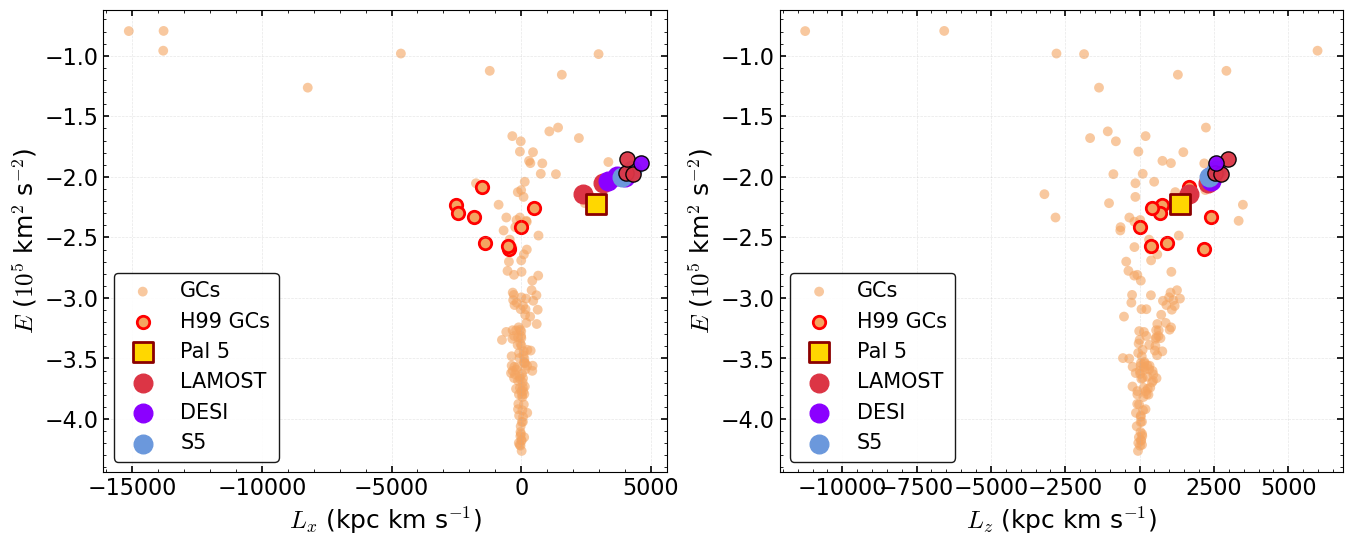

In [279]:
# ========== 绘图 ==========
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ========== 左图: Lx - E ==========
# 球状星团（背景）
ax1.scatter(Lx_GC, actions_cluster["E"]/1e5, c='#F4A460', s=50, alpha=0.6, 
            edgecolors='none', label='GCs', zorder=1)
ax1.scatter(df_gc["Lx"], df_gc["E/1e5"], c='#F4A460', s=80, 
            edgecolors='red', linewidths=2, label='H99 GCs')

pal5_idx = np.where(name_gc == "Pal 5")[0]
if len(pal5_idx) == 0:
    # 如果没找到完全匹配，尝试模糊匹配
    pal5_idx = [i for i, name in enumerate(name_gc) if "Pal 5" in name or "PAL 5" in name.upper()]

if len(pal5_idx) > 0:
    pal5_idx = pal5_idx[0]
    has_pal5 = True
else:
    has_pal5 = False

if has_pal5:
    ax1.scatter(Lx_GC[pal5_idx], actions_cluster["E"][pal5_idx]/1e5, 
               marker='s', s=200, c='#FFD700', edgecolors='darkred', 
               linewidths=2, zorder=10, label='Pal 5')


# 三个survey的星（框内的）
# LAMOST
Lx_L = sample_L[:,1]*sample_L[:,5] - sample_L[:,2]*sample_L[:,4]
E_L = pot_total.potential(pos_dg) + 0.5*np.sqrt(sample_dg[:, 3]**2+sample_dg[:, 4]**2+sample_dg[:, 5]**2)
ax1.scatter(Lx_L[mask_in_L], actions_L["E"][mask_in_L]*1e-5, 
           s=180, c='#DC3545', 
           label='LAMOST', zorder=3)

# DESI
Lx_D = sample_D[:,1]*sample_D[:,5] - sample_D[:,2]*sample_D[:,4]
ax1.scatter(Lx_D[mask_in_D], actions_D["E"][mask_in_D]*1e-5, 
           s=180, c='#8B00FF', 
           label='DESI', zorder=3)

# S5
Lx_S = sample_S[:,1]*sample_S[:,5] - sample_S[:,2]*sample_S[:,4]
ax1.scatter(Lx_S[mask_in_S], actions_S["E"][mask_in_S]*1e-5, 
           s=180, c='#6B98DC',  
           label='S5', zorder=3)

# 框外的星（加黑框）
if np.any(mask_out_L):
    ax1.scatter(Lx_L[mask_out_L], actions_L["E"][mask_out_L]*1e-5, 
               s=120, facecolors='#DC3545', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

if np.any(mask_out_D):
    ax1.scatter(Lx_D[mask_out_D], actions_D["E"][mask_out_D]*1e-5, 
               s=120, facecolors='#8B00FF', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

if np.any(mask_out_S):
    ax1.scatter(Lx_S[mask_out_S], actions_S["E"][mask_out_S]*1e-5, 
               s=120, facecolors='#6B98DC', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

ax1.tick_params(labelsize=16, direction='in', which='both', top=True, right=True)
ax1.legend(fontsize=15, frameon=True, loc='best', framealpha=0.9, edgecolor='black')
ax1.set_xlabel(r'$L_x$ (kpc km s$^{-1}$)', fontsize=18)
ax1.set_ylabel(r'$E$ ($10^5$ km$^2$ s$^{-2}$)', fontsize=18)
#ax1.set_xlim(-2000,3000)
ax1.grid(alpha=0.3, linestyle='--', linewidth=0.5)

# ========== 右图: Lz - E ==========
# 球状星团（背景）
ax2.scatter(Lz_GC, actions_cluster["E"]/1e5, c='#F4A460', s=50, alpha=0.6,
            edgecolors='none', label='GCs', zorder=1)
ax2.scatter(df_gc["JP"], df_gc["E/1e5"], c='#F4A460', s=80, 
            edgecolors='red', linewidths=2, label='H99 GCs')
if has_pal5:
    ax2.scatter(actions_cluster["JP"][pal5_idx], actions_cluster["E"][pal5_idx]/1e5, 
               marker='s', s=200, c='#FFD700', edgecolors='darkred', 
               linewidths=2, zorder=10, label='Pal 5')

# 三个survey的星（框内的）
# LAMOST
ax2.scatter(actions_L["JP"][mask_in_L], actions_L["E"][mask_in_L]*1e-5, 
           s=180, c='#DC3545', 
           label='LAMOST', zorder=3)

# DESI
ax2.scatter(actions_D["JP"][mask_in_D], actions_D["E"][mask_in_D]*1e-5, 
           s=180, c='#8B00FF', 
           label='DESI', zorder=3)

# S5
ax2.scatter(actions_S["JP"][mask_in_S], actions_S["E"][mask_in_S]*1e-5, 
           s=180, c='#6B98DC',  
           label='S5', zorder=3)

# 框外的星（加黑框）
if np.any(mask_out_L):
    ax2.scatter(actions_L["JP"][mask_out_L], actions_L["E"][mask_out_L]*1e-5, 
               s=120, facecolors='#DC3545', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

if np.any(mask_out_D):
    ax2.scatter(actions_D["JP"][mask_out_D], actions_D["E"][mask_out_D]*1e-5, 
               s=120, facecolors='#8B00FF', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

if np.any(mask_out_S):
    ax2.scatter(actions_S["JP"][mask_out_S], actions_S["E"][mask_out_S]*1e-5, 
               s=120, facecolors='#6B98DC', edgecolors='black', 
               linewidths=1, alpha=0.95, zorder=5)

ax2.tick_params(labelsize=16, direction='in', which='both', top=True, right=True)
ax2.legend(fontsize=15, frameon=True, loc='best', framealpha=0.9, edgecolor='black')
ax2.set_xlabel(r'$L_z$ (kpc km s$^{-1}$)', fontsize=18)
ax2.set_ylabel(r'$E$ ($10^5$ km$^2$ s$^{-2}$)', fontsize=18)
ax2.grid(alpha=0.3, linestyle='--', linewidth=0.5)
plt.savefig("/home/zyh/stream/palomar5_sibling/plot/LE.png", dpi=200, bbox_inches='tight')
plt.show()

In [63]:
alphaM_L = data_L["alpha_M"]
# alphaM_S = data_S["alpha50"]
alphaM_D = data_D["ALPHAFE"]

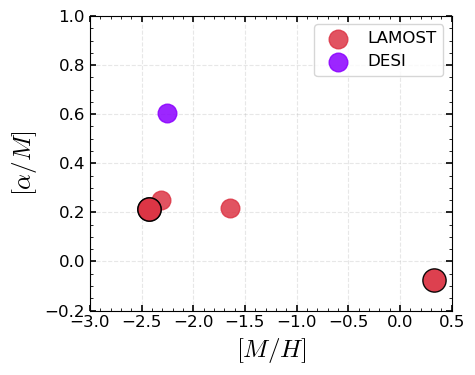

In [64]:
# ========== 创建图形 ==========
fig, ax = plt.subplots(figsize=(5,4))

# ========== 绘制框内的成员星 ==========
# LAMOST
if np.any(mask_in_L):
    ax.scatter(MH_L[mask_in_L], alphaM_L[mask_in_L],
              s=180, c='#DC3545', alpha=0.85,
              label='LAMOST', zorder=3)

# DESI
if np.any(mask_in_D):
    ax.scatter(MH_D[mask_in_D], alphaM_D[mask_in_D],
              s=180, c='#8B00FF', alpha=0.85,
              label='DESI', zorder=3)

# ========== 绘制框外的星（黑色粗边框）==========
if np.any(mask_out_L):
    ax.scatter(MH_L[mask_out_L], alphaM_L[mask_out_L],
              s=280, facecolors='#DC3545', edgecolors='black',
              linewidths=1, alpha=0.95, zorder=5)

if np.any(mask_out_D):
    ax.scatter(MH_D[mask_out_D], alphaM_D[mask_out_D],
              s=280, facecolors='#8B00FF', edgecolors='black',
              linewidths=1, alpha=0.95, zorder=5)

# ========== 图设置 ==========
ax.set_xlabel(r'$[M/H]$', fontsize=18)
ax.set_ylabel(r'$[\alpha/M]$', fontsize=18)
ax.tick_params(labelsize=12, direction='in', which='both')
ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax.legend(fontsize=12, loc='upper right')
ax.set_xlim(-3.0, 0.5)
ax.set_ylim(-0.2, 1)

# 统计信息
MH_all_in = np.concatenate([MH_L[mask_in_L], MH_D[mask_in_D]])
alpha_all_in = np.concatenate([alphaM_L[mask_in_L], alphaM_D[mask_in_D]])

plt.tight_layout()
#plt.savefig("/home/zyh/stream/palomar5_sibling/plot/MH_alpha.png", dpi=200, bbox_inches='tight')
plt.show()

In [65]:
H99_gc = ["E3", "NGC 4590", "NGC 5024", "NGC 5272", "NGC 6981","NGC 5904"]
MH_gc = [-0.89, -2.07, -1.93, -1.60, -1.48, -1.32]
aM_gc = [0.3, 0.35, 0.4, 0.35, 0.33, 0.33]

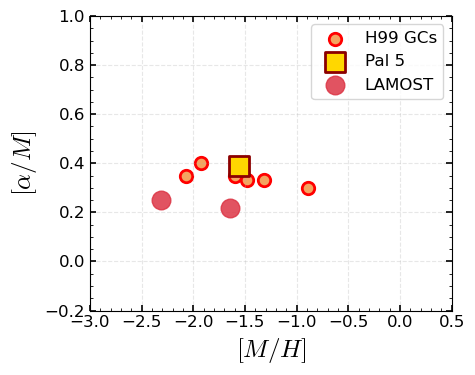

In [69]:
# ========== 创建图形 ==========
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(MH_gc, aM_gc, c='#F4A460', s=80, 
            edgecolors='red', linewidths=2, label='H99 GCs')
ax.scatter(-1.56, 0.39, 
               marker='s', s=200, c='#FFD700', edgecolors='darkred', 
               linewidths=2, zorder=10, label='Pal 5')
# palomar 5 from https://www.aanda.org/articles/aa/full_html/2017/05/aa29872-16/aa29872-16.html

# ========== 绘制框内的成员星 ==========
# LAMOST
if np.any(mask_in_L):
    ax.scatter(MH_L[mask_in_L], alphaM_L[mask_in_L],
              s=180, c='#DC3545', alpha=0.85,
              label='LAMOST', zorder=3)

# DESI
#if np.any(mask_in_D):
#    ax.scatter(MH_D[mask_in_D], alphaM_D[mask_in_D],
#              s=180, c='#8B00FF', alpha=0.85,
#              label='DESI', zorder=3)

# ========== 绘制框外的星（黑色粗边框）==========
#if np.any(mask_out_L):
#    ax.scatter(MH_L[mask_out_L], alphaM_L[mask_out_L],
#              s=180, facecolors='#DC3545', edgecolors='black',
#              linewidths=1, alpha=0.95, zorder=5)


# ========== 图设置 ==========
ax.set_xlabel(r'$[M/H]$', fontsize=18)
ax.set_ylabel(r'$[\alpha/M]$', fontsize=18)
ax.tick_params(labelsize=12, direction='in', which='both')
ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax.legend(fontsize=12, loc='upper right')
ax.set_xlim(-3.0, 0.5)
ax.set_ylim(-0.2, 1)

# 统计信息
MH_all_in = np.concatenate([MH_L[mask_in_L], MH_D[mask_in_D]])
alpha_all_in = np.concatenate([alphaM_L[mask_in_L], alphaM_D[mask_in_D]])

plt.tight_layout()
plt.savefig("/home/zyh/stream/palomar5_sibling/plot/MH_alpha.png", dpi=200, bbox_inches='tight')
plt.show()

The average eccentricity is 0.41007620096206665,with back 
The average pericenter is 10.403636932373047
The average apocenter is 24.86748504638672
The average eccentricity is 0.5408836603164673,with back 
The average pericenter is 6.988872528076172
The average apocenter is 23.456008911132812
The average eccentricity is 0.3010609447956085,with back 
The average pericenter is 13.487462997436523
The average apocenter is 25.106639862060547
The average eccentricity is 0.38514113426208496,with back 
The average pericenter is 11.185547828674316
The average apocenter is 25.198566436767578
The average eccentricity is 0.373579740524292,with back 
The average pericenter is 12.132268905639648
The average apocenter is 26.60296630859375
The average eccentricity is 0.3041512072086334,with back 
The average pericenter is 10.510777473449707
The average apocenter is 19.699159622192383
The average eccentricity is 0.2198641002178192,with back 
The average pericenter is 12.868436813354492
The average apoce

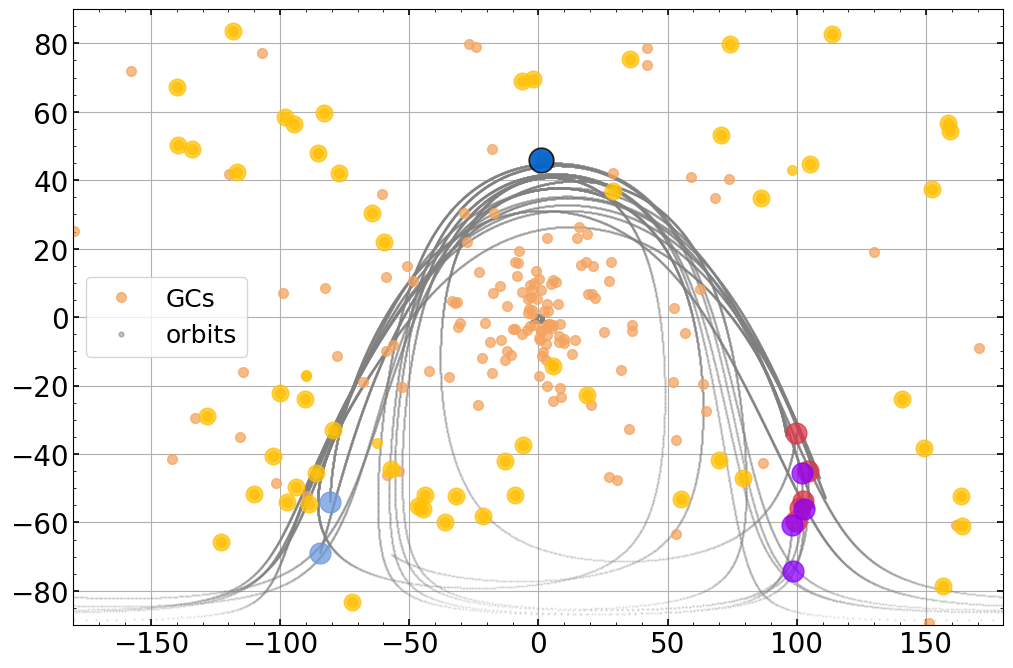

[[  7.868394   -5.0973644 -13.305268   59.62832   263.05118    37.129658 ]
 [  7.8729825  -5.0770903 -13.302397   59.468224  263.15466    37.407738 ]
 [  7.877559   -5.056808  -13.299503   59.30791   263.2578     37.685974 ]
 ...
 [  9.041662   -6.309847  -15.95506    83.68751   204.13086    20.022827 ]
 [  9.048106   -6.2941136 -15.953507   83.55656   204.22209    20.258533 ]
 [  9.05454    -6.278373  -15.951938   83.42546   204.31314    20.494299 ]]


In [189]:
llbb_mem = guc.radec_to_lb(ra_all,
                           dec_all,degree=True)

llbb_mem_D = guc.radec_to_lb(ra_D, dec_D,degree=True)
llbb_mem_L = guc.radec_to_lb(ra_L, dec_L,degree=True)
llbb_mem_S = guc.radec_to_lb(ra_S, dec_S,degree=True)

agama.setUnits(mass=1, length=1, velocity=1)
pot_bulge = agama.Potential(type='Dehnen', scaleRadius=1.0, gamma=1.0, mass=2e10)
pot_disk = agama.Potential(type='MiyamotoNagai', scaleRadius=3.0, scaleHeight=0.3, mass=5e10)
pot_halo = agama.Potential(type='NFW', scaleRadius=15.0, mass=1e12)#5.5e11
pot_total = agama.Potential(pot_bulge, pot_disk, pot_halo)

fig_r = plt.figure( figsize=(12, 8))
ax_r = fig_r.add_subplot(111)
ax_r.grid("on")

rcd_lbdr = []
rcd_lbd = []

rcd_orb = []
rcd_orb_m = []
rcd_t = []
rcd_t_m = []
for i_mem in range(len(ra_all)):
    init_condition =  [sample_A[i_mem,0] ,sample_A[i_mem,1], sample_A[i_mem,2], 
                       sample_A[i_mem,3], sample_A[i_mem,4], sample_A[i_mem,5]]

    t, orb = agama.orbit(potential=pot_total, ic = init_condition,
                         time= 2.*pot_total.Tcirc(init_condition), trajsize=10000)

    t_m, orb_m = agama.orbit(potential=pot_total, ic=init_condition,
                             time= -2. * pot_total.Tcirc(init_condition), trajsize=10000)

    output = Table()
    output["X"] = orb[:, 0]
    output["Y"] = orb[:, 1]
    output["Z"] = orb[:, 2]
    output["VX"] = orb[:, 3]
    output["VY"] = orb[:, 4]
    output["VZ"] = orb[:, 5]
    output["t"] = t
    rcd_t.append(t)
    rcd_orb.append(orb)

    output_r = Table()
    output_r["X"] = orb_m[:, 0]
    output_r["Y"] = orb_m[:, 1]
    output_r["Z"] = orb_m[:, 2]
    output_r["VX"] = orb_m[:, 3]
    output_r["VY"] = orb_m[:, 4]
    output_r["VZ"] = orb_m[:, 5]
    output_r["t"] = t_m
    rcd_t_m.append(t_m)
    rcd_orb_m.append(orb_m)


    lbd_L = guc.XYZ_to_lbd(8.34-orb[:,0], orb[:,1], orb[:,2],degree=True)
    output["ll"] = lbd_L[:,0]
    output["bb"] = lbd_L[:,1]
    output["dd"] = lbd_L[:,2]
    lbd_L[:, 0] = (lbd_L[:,0]+180)%360-180
    lbd_L[:, :2] = np.deg2rad(lbd_L[:,:2])

    lbdr_L = guc.XYZ_to_lbd(8.34 - orb_m[:, 0], orb_m[:, 1], orb_m[:, 2], degree=True)
    output_r["ll"] = lbdr_L[:,0]
    output_r["bb"] = lbdr_L[:,1]
    output_r["dd"] = lbdr_L[:,2]
    lbdr_L[:, 0] = (lbdr_L[:, 0] + 180) % 360 - 180
    
    rcd_lbdr.append(lbdr_L)
    rcd_lbd.append(lbd_L)

    ax_r.plot(lbd_L[:,0], lbd_L[:,1],'.',color="gray",ms=1,alpha=0.25)
    ax_r.plot(lbdr_L[:,0], lbdr_L[:,1],'.',color="gray",ms=1,alpha=0.25)

    max_orbit = np.max(np.sqrt(output["X"]**2+output["Y"]**2+output["Z"]**2))
    min_orbit = np.min(np.sqrt(output["X"]**2+output["Y"]**2+output["Z"]**2))
    ecc_tmp =  (max_orbit-min_orbit)/(max_orbit+min_orbit)

    max_orbit_r = np.max(np.sqrt(output_r["X"]**2+output_r["Y"]**2+output_r["Z"]**2))
    min_orbit_r = np.min(np.sqrt(output_r["X"]**2+output_r["Y"]**2+output_r["Z"]**2))
    ecc_tmp_r = (max_orbit_r-min_orbit_r)/(max_orbit_r+min_orbit_r)
    ecc = 0.5*(ecc_tmp+ecc_tmp_r)
    apo_center = 0.5*(max_orbit+max_orbit_r)
    per_center = 0.5*(min_orbit+min_orbit_r)

    ax_r.plot([800], [100],'.',color="#DC3545",ms=10,alpha=0.5)
    ax_r.plot([800], [100],'.',color="gray",ms=10,alpha=0.5)
    print(f"The average eccentricity is {np.mean(ecc)},with back ")
    print(f"The average pericenter is {per_center}")
    print(f"The average apocenter is {apo_center}")

ind_fornax = name_dg== "Ursa_Minor"#"Sculptor" #"Ursa_Minor"#"Sculptor" #"Carina" # "Sculptor" # "Fornax"
init_condition_fornax =  [sample_dg[ind_fornax,0][0], sample_dg[ind_fornax,1][0], sample_dg[ind_fornax,2][0], 
                          sample_dg[ind_fornax,3][0], sample_dg[ind_fornax,4][0], sample_dg[ind_fornax,5][0]]
t, orb_fornax = agama.orbit(potential=pot_total, ic = init_condition_fornax,
                     time= 2.*pot_total.Tcirc(init_condition_fornax), trajsize=10000)

t_m, orb_m_fornax = agama.orbit(potential=pot_total, ic=init_condition_fornax,
                         time= -2. * pot_total.Tcirc(init_condition_fornax), trajsize=10000)

lbd_L_fornax = guc.XYZ_to_lbd(8.34-orb_fornax[:,0], orb_fornax[:,1], orb_fornax[:,2],degree=True)
lbd_L_fornax[:, 0] = (lbd_L_fornax[:,0]+180)%360-180

    
ax_r.plot(((llbb_mem_L[:, 0] + 180) % 360 - 180), (llbb_mem_L[:, 1]), 'o', color="#DC3545", ms=15,alpha=0.75)
ax_r.plot(((llbb_mem_D[:, 0] + 180) % 360 - 180), (llbb_mem_D[:, 1]), 'o', color="#8B00FF", ms=15,alpha=0.75)
ax_r.plot(((llbb_mem_S[:, 0] + 180) % 360 - 180), (llbb_mem_S[:, 1]), 'o', color='#6B98DC', ms=15,alpha=0.75)

d_lim = 20
ind_gc_distant = np.sqrt((xyz_gc[:,0]-8.34)**2+xyz_gc[:,0]**2+xyz_gc[:,2]**2)>d_lim
ax_r.plot(((llbb_gc[:, 0] + 180) % 360 - 180), (llbb_gc[:, 1]), 'o', color='#F4A460', label="GCs",ms=7,alpha=0.75)

ind_GC_tmp = pal5_idx
ax_r.plot(((llbb_gc[:, 0][ind_GC_tmp] + 180) % 360 - 180), (llbb_gc[:, 1][ind_GC_tmp]), 'o', color="k", ms=18,alpha=0.75)
ax_r.plot(((llbb_gc[:, 0][ind_GC_tmp] + 180) % 360 - 180), (llbb_gc[:, 1][ind_GC_tmp]), 'o', color="#007BFF", ms=15,alpha=0.75)
ind_dg_distant = np.sqrt((xyz_dg[1:,0]-8.34)**2+xyz_dg[1:,0]**2+xyz_dg[1:,2]**2)>d_lim
ax_r.plot(((llbb_dg[1:, 0][ind_dg_distant] + 180) % 360 - 180), (llbb_dg[1:, 1][ind_dg_distant]), 'o', color="#FFC107", ms=12,alpha=0.75)
ax_r.plot(((llbb_dg[1:, 0] + 180) % 360 - 180), (llbb_dg[1:, 1]), 'o', color="#FFC107", ms=7,alpha=0.75)


ax_r.plot([800], [100],'.',color="gray",ms=7,alpha=0.5, label="orbits")
ax_r.legend(fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.show()

print(orb)



In [191]:
llbb_gc[35]

array([ 0.85131946, 45.85965095])

In [259]:
rcd_lbdr = []
rcd_lbd = []

rcd_orb = []
rcd_orb_m = []
rcd_t = []
rcd_t_m = []

pot_bulge = agama.Potential(type='Dehnen', scaleRadius=1.0, gamma=1.0, mass=2e10)
pot_disk = agama.Potential(type='MiyamotoNagai', scaleRadius=3.0, scaleHeight=0.3, mass=5e10)
pot_halo = agama.Potential(type='NFW', scaleRadius=15.0, mass=1.2e12)#5.5e11
pot_total = agama.Potential(pot_bulge, pot_disk, pot_halo)


for i_mem in range(len(ra_all)):
    init_condition =  [sample_A[i_mem,0] ,sample_A[i_mem,1], sample_A[i_mem,2], 
                       sample_A[i_mem,3], sample_A[i_mem,4], sample_A[i_mem,5]]

    t, orb = agama.orbit(potential=pot_total, ic = init_condition,
                         time= 2.*pot_total.Tcirc(init_condition), trajsize=10000)

    t_m, orb_m = agama.orbit(potential=pot_total, ic=init_condition,
                             time= -2. * pot_total.Tcirc(init_condition), trajsize=10000)

    output = Table()
    output["X"] = orb[:, 0]
    output["Y"] = orb[:, 1]
    output["Z"] = orb[:, 2]
    output["VX"] = orb[:, 3]
    output["VY"] = orb[:, 4]
    output["VZ"] = orb[:, 5]
    output["t"] = t
    rcd_t.append(t)
    rcd_orb.append(orb)

    output_r = Table()
    output_r["X"] = orb_m[:, 0]
    output_r["Y"] = orb_m[:, 1]
    output_r["Z"] = orb_m[:, 2]
    output_r["VX"] = orb_m[:, 3]
    output_r["VY"] = orb_m[:, 4]
    output_r["VZ"] = orb_m[:, 5]
    output_r["t"] = t_m
    rcd_t_m.append(t_m)
    rcd_orb_m.append(orb_m)


    lbd_L = guc.XYZ_to_lbd(8.34-orb[:,0], orb[:,1], orb[:,2],degree=True)
    output["ll"] = lbd_L[:,0]
    output["bb"] = lbd_L[:,1]
    output["dd"] = lbd_L[:,2]
    lbd_L[:, 0] = (lbd_L[:,0]+180)%360-180
    lbd_L[:, :2] = np.deg2rad(lbd_L[:,:2])

    lbdr_L = guc.XYZ_to_lbd(8.34 - orb_m[:, 0], orb_m[:, 1], orb_m[:, 2], degree=True)
    output_r["ll"] = lbdr_L[:,0]
    output_r["bb"] = lbdr_L[:,1]
    output_r["dd"] = lbdr_L[:,2]
    lbdr_L[:, 0] = (lbdr_L[:, 0] + 180) % 360 - 180
    # lbdr_L[:, :2] = np.deg2rad(lbdr_L[:, :2])
    
    rcd_lbdr.append(lbdr_L)
    rcd_lbd.append(lbd_L)

    ax_r.plot(lbd_L[:,0], lbd_L[:,1],'.',color="gray",ms=1,alpha=0.25)
    ax_r.plot(lbdr_L[:,0], lbdr_L[:,1],'.',color="gray",ms=1,alpha=0.25)

    max_orbit = np.max(np.sqrt(output["X"]**2+output["Y"]**2+output["Z"]**2))
    min_orbit = np.min(np.sqrt(output["X"]**2+output["Y"]**2+output["Z"]**2))
    ecc_tmp =  (max_orbit-min_orbit)/(max_orbit+min_orbit)

    max_orbit_r = np.max(np.sqrt(output_r["X"]**2+output_r["Y"]**2+output_r["Z"]**2))
    min_orbit_r = np.min(np.sqrt(output_r["X"]**2+output_r["Y"]**2+output_r["Z"]**2))
    ecc_tmp_r = (max_orbit_r-min_orbit_r)/(max_orbit_r+min_orbit_r)
    ecc = 0.5*(ecc_tmp+ecc_tmp_r)
    apo_center = 0.5*(max_orbit+max_orbit_r)
    per_center = 0.5*(min_orbit+min_orbit_r)

    ax_r.plot([800], [100],'.',color="#DC3545",ms=10,alpha=0.5)
    ax_r.plot([800], [100],'.',color="gray",ms=10,alpha=0.5)
    print(f"The average eccentricity is {np.mean(ecc)},with back ")
    print(f"The average pericenter is {per_center}")
    print(f"The average apocenter is {apo_center}")

The average eccentricity is 0.40851372480392456,with back 
The average pericenter is 9.710126876831055
The average apocenter is 23.122844696044922
The average eccentricity is 0.5479694604873657,with back 
The average pericenter is 6.501278400421143
The average apocenter is 22.26349639892578
The average eccentricity is 0.2756524085998535,with back 
The average pericenter is 12.819913864135742
The average apocenter is 22.577220916748047
The average eccentricity is 0.37801989912986755,with back 
The average pericenter is 10.480944633483887
The average apocenter is 23.22092056274414
The average eccentricity is 0.3548802137374878,with back 
The average pericenter is 11.467841148376465
The average apocenter is 24.084754943847656
The average eccentricity is 0.3139355778694153,with back 
The average pericenter is 9.737746238708496
The average apocenter is 18.649517059326172
The average eccentricity is 0.22174739837646484,with back 
The average pericenter is 11.977731704711914
The average apoce

In [178]:
sample_gc, actions_gc = calc_actions(ra_gc, 
                              dec_gc,
                              dist_gc,
                              pmra_gc, 
                              pmdec_gc,
                              RV_gc)

In [179]:
def integrate_gc_orbits(sample_gc, pot_total, R_sun=8.34, trajsize=10000, plot=False):
    import numpy as np
    from astropy.table import Table

    rcd_lbd, rcd_lbdr = [], []
    ecc_list, apo_list, peri_list = [], [], []

    for i in range(len(sample_gc)):
        init_condition = sample_gc[i, :6]

        # forward & backward orbit integration
        t, orb = agama.orbit(potential=pot_total, ic=init_condition,
                             time=2.*pot_total.Tcirc(init_condition), trajsize=trajsize)
        t_m, orb_m = agama.orbit(potential=pot_total, ic=init_condition,
                                 time=-2.*pot_total.Tcirc(init_condition), trajsize=trajsize)

        # 转换为银河坐标
        lbd_L = guc.XYZ_to_lbd(R_sun - orb[:,0], orb[:,1], orb[:,2], degree=True)
        lbdr_L = guc.XYZ_to_lbd(R_sun - orb_m[:,0], orb_m[:,1], orb_m[:,2], degree=True)

        # 调整经度范围
        lbd_L[:,0] = (lbd_L[:,0] + 180) % 360 - 180
        lbdr_L[:,0] = (lbdr_L[:,0] + 180) % 360 - 180

        rcd_lbd.append(lbd_L)
        rcd_lbdr.append(lbdr_L)

        # 计算偏心率等轨道参数
        r = np.sqrt(orb[:,0]**2 + orb[:,1]**2 + orb[:,2]**2)
        r_r = np.sqrt(orb_m[:,0]**2 + orb_m[:,1]**2 + orb_m[:,2]**2)

        ecc = 0.5*((r.max()-r.min())/(r.max()+r.min()) + (r_r.max()-r_r.min())/(r_r.max()+r_r.min()))
        apo = 0.5*(r.max() + r_r.max())
        peri = 0.5*(r.min() + r_r.min())

        ecc_list.append(ecc)
        apo_list.append(apo)
        peri_list.append(peri)

        if plot:
            ax_r.plot(lbd_L[:,0], lbd_L[:,1], '.', color='gray', ms=1, alpha=0.25)
            ax_r.plot(lbdr_L[:,0], lbdr_L[:,1], '.', color='gray', ms=1, alpha=0.25)

    return np.array(ecc_list), np.array(peri_list), np.array(apo_list), rcd_lbd, rcd_lbdr


In [180]:
llbb_gctarget = guc.radec_to_lb(ra_target,
                           dec_target,degree=True)

GCecc: 0.389
GCperi: 8.174 kpc
GCapo: 18.562 kpc


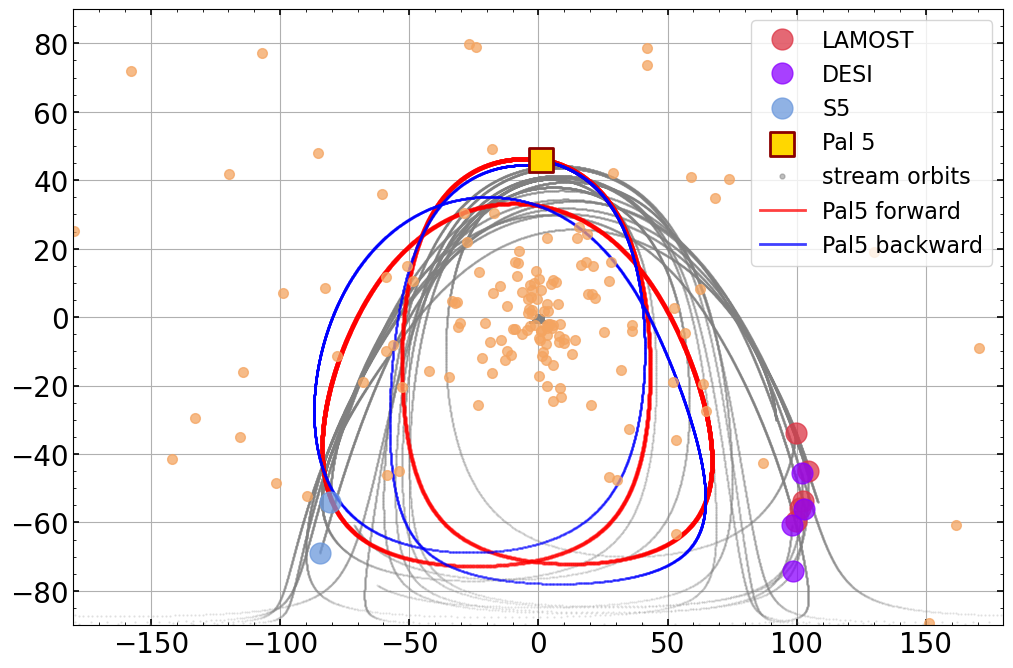

[[  7.868394   -5.0973644 -13.305268   59.62832   263.05118    37.129658 ]
 [  7.872385   -5.0797305 -13.302771   59.46652   263.1558     37.409664 ]
 [  7.876365   -5.06209   -13.300254   59.304527  263.2601     37.6898   ]
 ...
 [  8.689271   -5.7108574 -15.105661   89.09951   214.62134    18.4408   ]
 [  8.695238   -5.69647   -15.104417   88.95723   214.7147     18.692802 ]
 [  8.701196   -5.682076  -15.103156   88.814804  214.80786    18.944857 ]]


In [243]:

fig_r = plt.figure( figsize=(12, 8))
ax_r = fig_r.add_subplot(111)
ax_r.grid("on")

agama.setUnits(mass=1, length=1, velocity=1)
pot_bulge = agama.Potential(type='Dehnen', scaleRadius=1.0, gamma=1.0, mass=2e10)
pot_disk = agama.Potential(type='MiyamotoNagai', scaleRadius=3.0, scaleHeight=0.3, mass=5e10)
pot_halo = agama.Potential(type='NFW', scaleRadius=15.0, mass=1.2e12)#5.5e11
pot_total = agama.Potential(pot_bulge, pot_disk, pot_halo)

rcd_lbdr = []
rcd_lbd = []

rcd_orb = []
rcd_orb_m = []
rcd_t = []
rcd_t_m = []
for i_mem in range(len(ra_all)):
    init_condition =  [sample_A[i_mem,0] ,sample_A[i_mem,1], sample_A[i_mem,2], 
                       sample_A[i_mem,3], sample_A[i_mem,4], sample_A[i_mem,5]]

    t, orb = agama.orbit(potential=pot_total, ic = init_condition,
                         time= 2.*pot_total.Tcirc(init_condition), trajsize=10000)

    t_m, orb_m = agama.orbit(potential=pot_total, ic=init_condition,
                             time= -2. * pot_total.Tcirc(init_condition), trajsize=10000)

    output = Table()
    output["X"] = orb[:, 0]
    output["Y"] = orb[:, 1]
    output["Z"] = orb[:, 2]
    output["VX"] = orb[:, 3]
    output["VY"] = orb[:, 4]
    output["VZ"] = orb[:, 5]
    output["t"] = t
    rcd_t.append(t)
    rcd_orb.append(orb)

    output_r = Table()
    output_r["X"] = orb_m[:, 0]
    output_r["Y"] = orb_m[:, 1]
    output_r["Z"] = orb_m[:, 2]
    output_r["VX"] = orb_m[:, 3]
    output_r["VY"] = orb_m[:, 4]
    output_r["VZ"] = orb_m[:, 5]
    output_r["t"] = t_m
    rcd_t_m.append(t_m)
    rcd_orb_m.append(orb_m)


    lbd_L = guc.XYZ_to_lbd(8.34-orb[:,0], orb[:,1], orb[:,2],degree=True)
    output["ll"] = lbd_L[:,0]
    output["bb"] = lbd_L[:,1]
    output["dd"] = lbd_L[:,2]
    lbd_L[:, 0] = (lbd_L[:,0]+180)%360-180
    lbd_L[:, :2] = np.deg2rad(lbd_L[:,:2])

    lbdr_L = guc.XYZ_to_lbd(8.34 - orb_m[:, 0], orb_m[:, 1], orb_m[:, 2], degree=True)
    output_r["ll"] = lbdr_L[:,0]
    output_r["bb"] = lbdr_L[:,1]
    output_r["dd"] = lbdr_L[:,2]
    lbdr_L[:, 0] = (lbdr_L[:, 0] + 180) % 360 - 180
    # lbdr_L[:, :2] = np.deg2rad(lbdr_L[:, :2])
    
    rcd_lbdr.append(lbdr_L)
    rcd_lbd.append(lbd_L)

    ax_r.plot(lbd_L[:,0], lbd_L[:,1],'.',color="gray",ms=1,alpha=0.25)
    ax_r.plot(lbdr_L[:,0], lbdr_L[:,1],'.',color="gray",ms=1,alpha=0.25)

    max_orbit = np.max(np.sqrt(output["X"]**2+output["Y"]**2+output["Z"]**2))
    min_orbit = np.min(np.sqrt(output["X"]**2+output["Y"]**2+output["Z"]**2))
    ecc_tmp =  (max_orbit-min_orbit)/(max_orbit+min_orbit)

    max_orbit_r = np.max(np.sqrt(output_r["X"]**2+output_r["Y"]**2+output_r["Z"]**2))
    min_orbit_r = np.min(np.sqrt(output_r["X"]**2+output_r["Y"]**2+output_r["Z"]**2))
    ecc_tmp_r = (max_orbit_r-min_orbit_r)/(max_orbit_r+min_orbit_r)
    ecc = 0.5*(ecc_tmp+ecc_tmp_r)
    apo_center = 0.5*(max_orbit+max_orbit_r)
    per_center = 0.5*(min_orbit+min_orbit_r)

    ax_r.plot([800], [100],'.',color="#DC3545",ms=10,alpha=0.5)
    ax_r.plot([800], [100],'.',color="gray",ms=10,alpha=0.5)


# === 计算 GC 轨道 ===
init_condition_gc = sample_gc[pal5_idx]   # 如果只有一个 GC
# 若 sample_gc 有多个 GC，可改成 for 循环

t_gc, orb_gc = agama.orbit(potential=pot_total, ic=init_condition_gc,
                           time=2.*pot_total.Tcirc(init_condition_gc), trajsize=10000)
t_gc_m, orb_gc_m = agama.orbit(potential=pot_total, ic=init_condition_gc,
                               time=-2.*pot_total.Tcirc(init_condition_gc), trajsize=10000)

# === 转换到银河坐标系 ===
lbd_L_fornax = guc.XYZ_to_lbd(8.34 - orb_gc[:,0], orb_gc[:,1], orb_gc[:,2], degree=True)
lbdr_L_fornax = guc.XYZ_to_lbd(8.34 - orb_gc_m[:,0], orb_gc_m[:,1], orb_gc_m[:,2], degree=True)

# 经度调到 [-180, 180]
lbd_L_fornax[:,0] = (lbd_L_fornax[:,0] + 180) % 360 - 180
lbdr_L_fornax[:,0] = (lbdr_L_fornax[:,0] + 180) % 360 - 180

# === 绘制轨迹 ===
ax_r.plot(lbd_L_fornax[:,0], lbd_L_fornax[:,1], '.', color='r', ms=4, alpha=0.25)
ax_r.plot(lbdr_L_fornax[:,0], lbdr_L_fornax[:,1], '.', color='b', ms=2, alpha=0.25)

# === （可选）计算 GC 轨道参数 ===
r_gc = np.sqrt(orb_gc[:,0]**2 + orb_gc[:,1]**2 + orb_gc[:,2]**2)
r_gc_m = np.sqrt(orb_gc_m[:,0]**2 + orb_gc_m[:,1]**2 + orb_gc_m[:,2]**2)

ecc_gc = 0.5 * ((r_gc.max() - r_gc.min())/(r_gc.max() + r_gc.min()) +
                (r_gc_m.max() - r_gc_m.min())/(r_gc_m.max() + r_gc_m.min()))
apo_gc = 0.5 * (r_gc.max() + r_gc_m.max())
peri_gc = 0.5 * (r_gc.min() + r_gc_m.min())

print(f"GCecc: {ecc_gc:.3f}")
print(f"GCperi: {peri_gc:.3f} kpc")
print(f"GCapo: {apo_gc:.3f} kpc")

llbb_mem = guc.radec_to_lb(ra_all,
                           dec_all,degree=True)

llbb_mem_D = guc.radec_to_lb(ra_D, dec_D,degree=True)
llbb_mem_L = guc.radec_to_lb(ra_L, dec_L,degree=True)
llbb_mem_S = guc.radec_to_lb(ra_S, dec_S,degree=True)

    
ax_r.plot(((llbb_mem_L[:, 0] + 180) % 360 - 180), (llbb_mem_L[:, 1]), 'o', color="#DC3545", ms=15,alpha=0.75,label="LAMOST")
ax_r.plot(((llbb_mem_D[:, 0] + 180) % 360 - 180), (llbb_mem_D[:, 1]), 'o', color="#8B00FF", ms=15,alpha=0.75,label="DESI")
ax_r.plot(((llbb_mem_S[:, 0] + 180) % 360 - 180), (llbb_mem_S[:, 1]), 'o', color="#6B98DC", ms=15,alpha=0.75,label="S5")


d_lim = 20
ind_gc_distant = np.sqrt((xyz_gc[:,0]-8.34)**2+xyz_gc[:,0]**2+xyz_gc[:,2]**2)>d_lim
# ax_r.plot(((llbb_gc[:, 0][ind_gc_distant] + 180) % 360 - 180), (llbb_gc[:, 1][ind_gc_distant]), 'ko', ms=12,alpha=0.75)
ax_r.plot(((llbb_gc[:, 0] + 180) % 360 - 180), (llbb_gc[:, 1]), 'o', color='#F4A460', ms=7,alpha=0.75)

ax_r.scatter(((llbb_gc[:, 0][ind_GC_tmp] + 180) % 360 - 180), (llbb_gc[:, 1][ind_GC_tmp]), marker='s', s=300, c='#FFD700', edgecolors='darkred', 
               linewidths=2, zorder=10, label='Pal 5')


ax_r.plot([800], [100],'.',color="gray",ms=7,alpha=0.5, label="stream orbits")
# ax_r.plot([800], [100],'.',color="#DC3545",ms=7,alpha=0.5, label="look forward")

ax_r.plot([800, 801], [100, 100], '-', color='r', linewidth=2, alpha=0.75, label="Pal5 forward")
ax_r.plot([800, 801], [100, 100], '-', color='b', linewidth=2, alpha=0.75, label="Pal5 backward")
ax_r.legend(fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.show()

print(orb)



In [185]:
pal5_idx

35

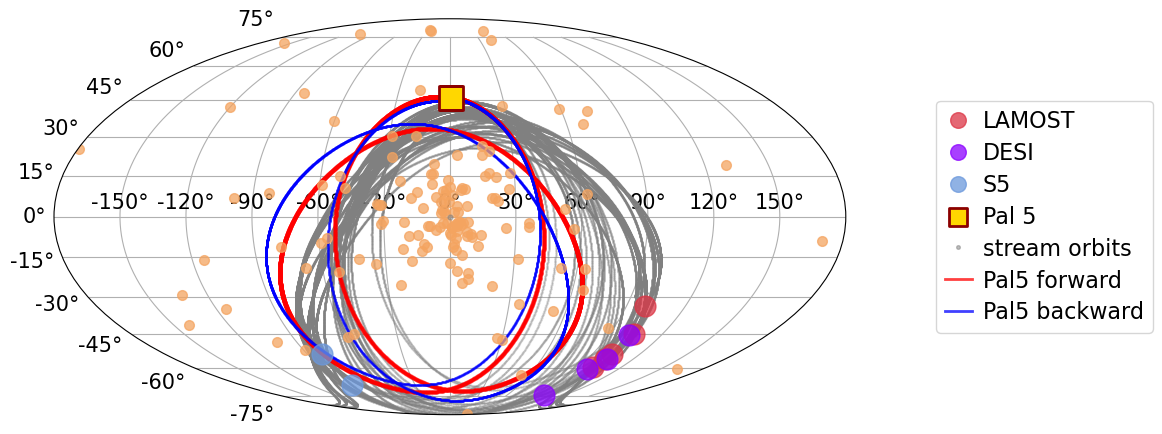

In [244]:
# === 创建 Mollweide 投影图 ===
fig_r = plt.figure(figsize=(12, 10))
ax_r = fig_r.add_subplot(111, projection='mollweide')
ax_r.grid(True)

rcd_lbdr, rcd_lbd, rcd_orb, rcd_orb_m, rcd_t, rcd_t_m = [], [], [], [], [], []

# === 循环画 member 轨道 ===
for i_mem in range(len(ra_all)):
    init_condition = sample_A[i_mem, :6]

    # 正反向轨道
    t, orb = agama.orbit(potential=pot_total, ic=init_condition,
                         time=2.*pot_total.Tcirc(init_condition), trajsize=10000)
    t_m, orb_m = agama.orbit(potential=pot_total, ic=init_condition,
                             time=-2.*pot_total.Tcirc(init_condition), trajsize=10000)

    # === 转换到银河坐标 ===
    lbd_L = guc.XYZ_to_lbd(8.34 - orb[:,0], orb[:,1], orb[:,2], degree=True)
    lbdr_L = guc.XYZ_to_lbd(8.34 - orb_m[:,0], orb_m[:,1], orb_m[:,2], degree=True)

    # 转换经度范围 & 弧度制
    lbd_L[:,0] = np.deg2rad((lbd_L[:,0] + 180) % 360 - 180)
    lbd_L[:,1] = np.deg2rad(lbd_L[:,1])
    lbdr_L[:,0] = np.deg2rad((lbdr_L[:,0] + 180) % 360 - 180)
    lbdr_L[:,1] = np.deg2rad(lbdr_L[:,1])

    # 保存 & 绘制
    rcd_lbd.append(lbd_L)
    rcd_lbdr.append(lbdr_L)
    ax_r.plot(lbd_L[:,0], lbd_L[:,1], '.', color="gray", ms=1, alpha=0.25)
    ax_r.plot(lbdr_L[:,0], lbdr_L[:,1], '.', color="gray", ms=1, alpha=0.25)


# GC 轨道也要转换
ax_r.plot(np.deg2rad(lbd_L_fornax[:,0]), np.deg2rad(lbd_L_fornax[:,1]), '.', color='r', ms=4, alpha=0.25)
ax_r.plot(np.deg2rad(lbdr_L_fornax[:,0]), np.deg2rad(lbdr_L_fornax[:,1]), '.', color='b', ms=2, alpha=0.25)

# 观测数据点
ax_r.plot(np.deg2rad((llbb_mem_L[:, 0] + 180) % 360 - 180), np.deg2rad(llbb_mem_L[:, 1]), 'o', color="#DC3545", ms=15, alpha=0.75, label="LAMOST")
ax_r.plot(np.deg2rad((llbb_mem_D[:, 0] + 180) % 360 - 180), np.deg2rad(llbb_mem_D[:, 1]), 'o', color="#8B00FF", ms=15, alpha=0.75, label="DESI")
ax_r.plot(np.deg2rad((llbb_mem_S[:, 0] + 180) % 360 - 180), np.deg2rad(llbb_mem_S[:, 1]), 'o', color="#6B98DC", ms=15, alpha=0.75, label="S5")

# 球状星团
ax_r.plot(np.deg2rad((llbb_gc[:, 0] + 180) % 360 - 180), np.deg2rad(llbb_gc[:, 1]), 'o', color='#F4A460', ms=7, alpha=0.75)
ax_r.scatter(np.deg2rad((llbb_gc[:, 0][ind_GC_tmp] + 180) % 360 - 180), np.deg2rad(llbb_gc[:, 1][ind_GC_tmp]), marker='s', s=300, c='#FFD700', edgecolors='darkred', linewidths=2, zorder=10, label='Pal 5')

# 图例（虚拟点位置也需要转换，或者放在投影范围外）
ax_r.plot([0], [0], '.', color="gray", ms=7, alpha=0.5, label="stream orbits")
ax_r.plot([0], [0], '-', color='r', linewidth=2, alpha=0.75, label="Pal5 forward")
ax_r.plot([0], [0], '-', color='b', linewidth=2, alpha=0.75, label="Pal5 backward")

ax_r.legend(fontsize=16,bbox_to_anchor=(1.1, 0.5), loc='center left',frameon=True, markerscale=0.75, labelspacing=0.4, 
           handlelength=1.2, handletextpad=0.5)
plt.tight_layout()
#plt.savefig("/home/zyh/stream/palomar5_sibling/plot/orbit.png", dpi=200, bbox_inches='tight')
plt.show()

mass =  5.0 ×1e11 Msun --> e = 0.178, r_peri = 13.42 kpc, r_apo = 19.22 kpc
mass =  6.0 ×1e11 Msun --> e = 0.218, r_peri = 12.16 kpc, r_apo = 18.95 kpc
mass =  7.0 ×1e11 Msun --> e = 0.256, r_peri = 11.14 kpc, r_apo = 18.80 kpc
mass =  8.0 ×1e11 Msun --> e = 0.289, r_peri = 10.32 kpc, r_apo = 18.71 kpc
mass =  9.0 ×1e11 Msun --> e = 0.318, r_peri = 9.64 kpc, r_apo = 18.65 kpc
mass = 10.0 ×1e11 Msun --> e = 0.345, r_peri = 9.07 kpc, r_apo = 18.61 kpc
mass = 11.0 ×1e11 Msun --> e = 0.368, r_peri = 8.59 kpc, r_apo = 18.58 kpc
mass = 12.0 ×1e11 Msun --> e = 0.389, r_peri = 8.17 kpc, r_apo = 18.56 kpc
mass = 13.0 ×1e11 Msun --> e = 0.407, r_peri = 7.81 kpc, r_apo = 18.54 kpc
mass = 14.0 ×1e11 Msun --> e = 0.424, r_peri = 7.49 kpc, r_apo = 18.53 kpc
mass = 15.0 ×1e11 Msun --> e = 0.440, r_peri = 7.20 kpc, r_apo = 18.52 kpc
mass = 16.0 ×1e11 Msun --> e = 0.455, r_peri = 6.94 kpc, r_apo = 18.52 kpc
mass = 17.0 ×1e11 Msun --> e = 0.468, r_peri = 6.71 kpc, r_apo = 18.51 kpc
mass = 18.0 ×1e11 Msu

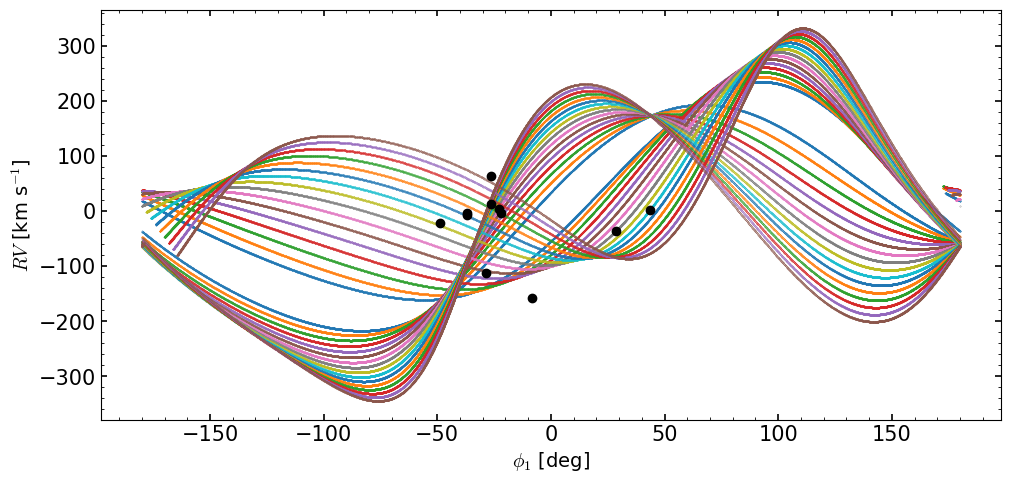

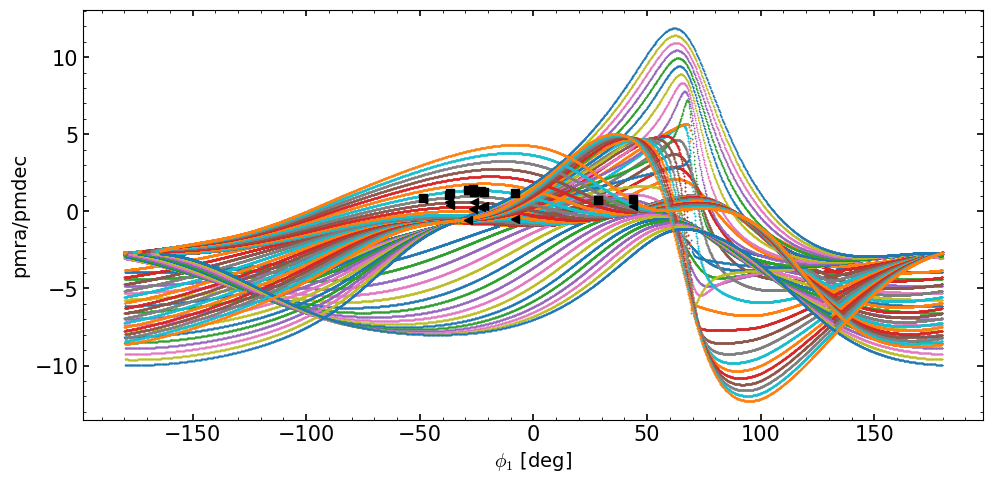

In [258]:
mass_range = np.linspace(5,20,16)
fig_rv = plt.figure(figsize=(10,5))
ax_rv = fig_rv.add_axes([0.05,0.15,0.9,0.82])
fig_pm = plt.figure(figsize=(10,5))
ax_pm = fig_pm.add_axes([0.05,0.15,0.9,0.82])

# ind_GC_tmp  Pyxis
def orbit_to_obs(orb_tmp):
    xyz_pyxis_sun = orb_tmp[:,:3]*1.0
    xyz_pyxis_sun[:,0] = 8.34 - xyz_pyxis_sun[:,0]
    uvw_pyxis_sun = orb_tmp[:,3:]*1.0 
    uvw_pyxis_sun[:,0] = -uvw_pyxis_sun[:,0]-U_Sun
    uvw_pyxis_sun[:,1] = uvw_pyxis_sun[:,1]-V_LSR-V_Sun
    uvw_pyxis_sun[:,2] = uvw_pyxis_sun[:,2] - W_Sun
    
    lbd_pyxis = guc.XYZ_to_lbd(xyz_pyxis_sun[:,0],xyz_pyxis_sun[:,1],xyz_pyxis_sun[:,2],degree=True)
    radec_pyxis_tmp = guc.lb_to_radec(lbd_pyxis[:,0], lbd_pyxis[:,1], degree=True)
    vrpmllpmbb_pyxis = guc.vxvyvz_to_vrpmllpmbb(uvw_pyxis_sun[:,0],uvw_pyxis_sun[:,1],uvw_pyxis_sun[:,2],lbd_pyxis[:,0],lbd_pyxis[:,1],lbd_pyxis[:,2],XYZ=False, degree=True)
    pmrapmdec_pyxis = guc.pmllpmbb_to_pmrapmdec(vrpmllpmbb_pyxis[:,1],vrpmllpmbb_pyxis[:,2],lbd_pyxis[:,0],lbd_pyxis[:,1], degree=True)
    return lbd_pyxis, radec_pyxis_tmp, vrpmllpmbb_pyxis, pmrapmdec_pyxis


init_condition_pal5 = POS_VEL_cluster[ind_GC_tmp,:]
agama.setUnits(mass=1, length=1, velocity=1)

for i_mass in range(16):
    mass_tmp = mass_range[i_mass]
    pot_bulge = agama.Potential(type='Dehnen', scaleRadius=1.0, gamma=1.0, mass=2e10)
    pot_disk = agama.Potential(type='MiyamotoNagai', scaleRadius=3.0, scaleHeight=0.3, mass=5e10)
    pot_halo = agama.Potential(type='NFW', scaleRadius=15.0, mass=mass_tmp*1e11)
    pot_total = agama.Potential(pot_bulge, pot_disk, pot_halo)
    
    # ===== 正向轨道 =====
    t_pyxis, orb_pyxis = agama.orbit(
        potential=pot_total, 
        ic=init_condition_pal5,
        time=2*pot_total.Tcirc(init_condition_pal5),
        trajsize=10000
    )

    # ===== 反向轨道 =====
    t_pyxis_m, orb_pyxis_m = agama.orbit(
        potential=pot_total, 
        ic=init_condition_pal5,
        time=-2*pot_total.Tcirc(init_condition_pal5),
        trajsize=10000
    )

    # ===== 计算 r(t) =====
    r_gc = np.sqrt(orb_pyxis[:,0]**2 + orb_pyxis[:,1]**2 + orb_pyxis[:,2]**2)
    r_gc_m = np.sqrt(orb_pyxis_m[:,0]**2 + orb_pyxis_m[:,1]**2 + orb_pyxis_m[:,2]**2)

    # ===== 偏心率、近日点、远日点 =====
    ecc_tmp = (r_gc.max() - r_gc.min()) / (r_gc.max() + r_gc.min())
    ecc_tmp_m = (r_gc_m.max() - r_gc_m.min()) / (r_gc_m.max() + r_gc_m.min())
    ecc = 0.5 * (ecc_tmp + ecc_tmp_m)
    r_peri = 0.5 * (r_gc.min() + r_gc_m.min())
    r_apo = 0.5 * (r_gc.max() + r_gc_m.max())

    print(f"mass = {mass_tmp:>4.1f} ×1e11 Msun --> e = {ecc:.3f}, r_peri = {r_peri:.2f} kpc, r_apo = {r_apo:.2f} kpc")

    # ===== 投影到观测坐标 =====
    lbd_pyxis, radec_pyxis_tmp, vrpmllpmbb_pyxis, pmrapmdec_pyxis = orbit_to_obs(orb_pyxis)
    
    C_pyxis = coord.SkyCoord(
        ra=radec_pyxis_tmp[:,0]*u.deg, dec=radec_pyxis_tmp[:,1]*u.deg,
        pm_ra_cosdec=pmrapmdec_pyxis[:,0]*u.mas/u.yr,
        pm_dec=pmrapmdec_pyxis[:,1]*u.mas/u.yr
    )
    C_pyxis_fr = C_pyxis.transform_to(frame)
    Pyxis_phi1 = C_pyxis_fr.phi1.deg
    
    # 绘图（保留原样）
    ax_rv.plot(Pyxis_phi1, vrpmllpmbb_pyxis[:,0], '.', label=f"{mass_tmp:.1f}", ms=0.5)
    ax_pm.plot(Pyxis_phi1, pmrapmdec_pyxis[:,0], '<', label=f"{mass_tmp:.1f}", ms=0.5)
    ax_pm.plot(Pyxis_phi1, pmrapmdec_pyxis[:,1], 's', ms=0.5)

RV1_all = np.concatenate([RV_L, RV_D, RV_S])

ax_rv.plot(phi1_all, RV1_all, 'ko')
ax_rv.set_xlabel(r'$\phi_1$ [deg]', fontsize=14)
ax_rv.set_ylabel(r'$RV$ [km s$^{-1}$]', fontsize=14)
#ax_rv.set_xlim([-25,80])
#ax_rv.set_ylim([-50,150])

pmra1_all=np.concatenate([pmra_L, pmra_D, pmra_S])
pmdec1_all=np.concatenate([pmdec_L, pmdec_D, pmdec_S])

ax_pm.plot(phi1_all, pmra1_all, 'k<')
ax_pm.plot(phi1_all, pmdec1_all, 'ks')
ax_pm.set_xlabel(r'$\phi_1$ [deg]', fontsize=14)
ax_pm.set_ylabel(r'pmra/pmdec', fontsize=14)
#ax_pm.set_xlim([-25,80])
#ax_pm.set_ylim([-1,3])
plt.show()


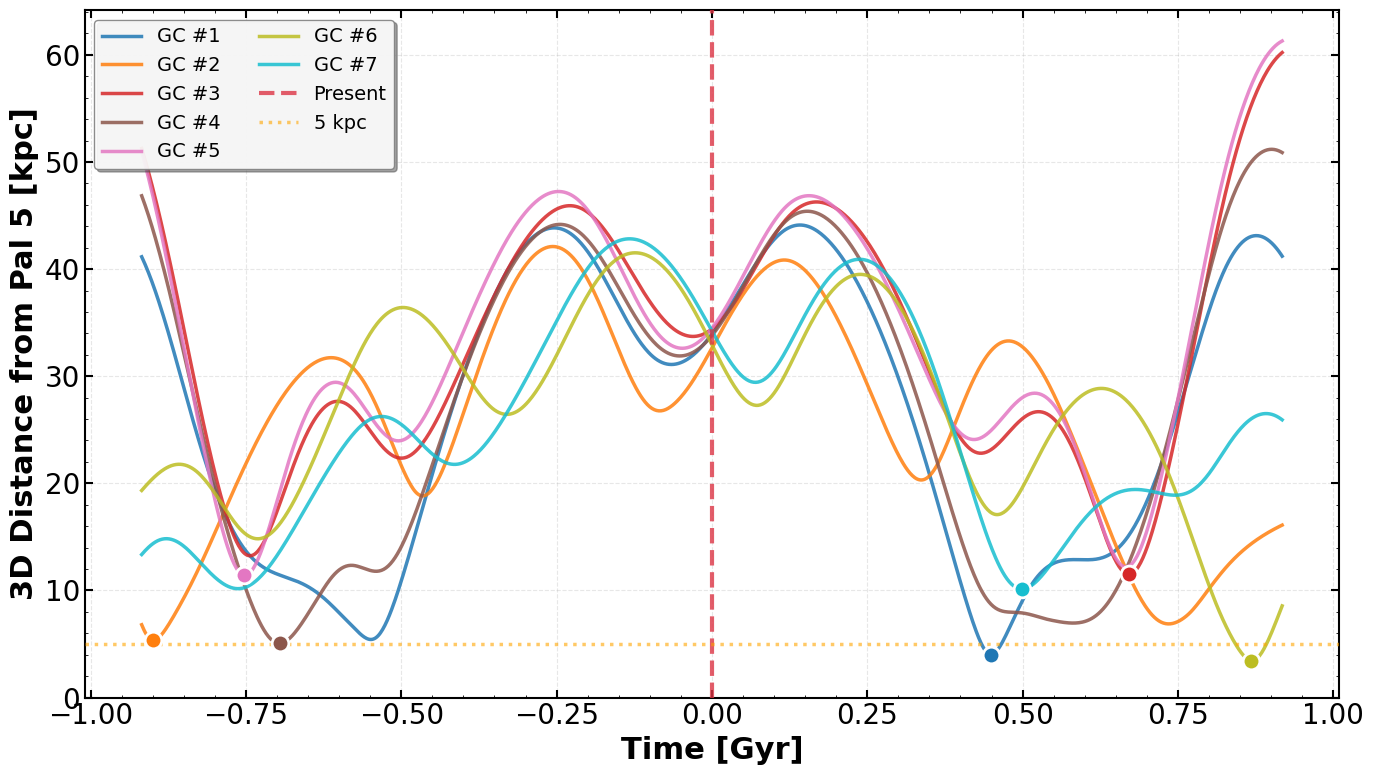

In [105]:
# ============================================================
# Pal 5 与星流成员的轨道相位分析
# ============================================================
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)

# 首先需要拼接 GC 的前向和后向轨道
orb_gc_full = np.vstack([orb_gc_m[::-1], orb_gc[1:]])
t_gc_full = np.concatenate([t_gc_m[::-1], t_gc[1:]])

# 使用更美观的配色方案
# 方案1：使用 tab10 颜色
colors_sample = plt.cm.tab10(np.linspace(0, 1, len(ra_all)))

# 方案2：或使用手动指定的优雅配色
# colors_sample = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

from scipy.interpolate import interp1d

for member_idx in range(len(ra_all)):
    init_condition = sample_A[member_idx, :6]
    
    # 正反向轨道
    t, orb = agama.orbit(potential=pot_total, ic=init_condition,
                         time=2.*pot_total.Tcirc(init_condition), trajsize=10000)
    t_m, orb_m = agama.orbit(potential=pot_total, ic=init_condition,
                             time=-2.*pot_total.Tcirc(init_condition), trajsize=10000)
    
    # 拼接星流成员的前向和后向轨道
    orb_stream_full = np.vstack([orb_m[::-1], orb[1:]])
    t_stream_full = np.concatenate([t_m[::-1], t[1:]])
    
    # 计算与 Pal 5 的距离随时间变化
    # 在共同时间网格上插值
    t_min = max(t_gc_full[0], t_stream_full[0])
    t_max = min(t_gc_full[-1], t_stream_full[-1])
    t_common = np.linspace(t_min, t_max, 1000)
    
    # 插值 Pal 5
    gc_x_interp = interp1d(t_gc_full, orb_gc_full[:,0], kind='cubic')(t_common)
    gc_y_interp = interp1d(t_gc_full, orb_gc_full[:,1], kind='cubic')(t_common)
    gc_z_interp = interp1d(t_gc_full, orb_gc_full[:,2], kind='cubic')(t_common)
    
    # 插值星流成员
    stream_x_interp = interp1d(t_stream_full, orb_stream_full[:,0], kind='cubic')(t_common)
    stream_y_interp = interp1d(t_stream_full, orb_stream_full[:,1], kind='cubic')(t_common)
    stream_z_interp = interp1d(t_stream_full, orb_stream_full[:,2], kind='cubic')(t_common)
    
    # 计算3D距离
    dist_3d = np.sqrt((gc_x_interp - stream_x_interp)**2 + 
                      (gc_y_interp - stream_y_interp)**2 + 
                      (gc_z_interp - stream_z_interp)**2)
    
    # 绘制距离演化曲线 - 更粗、更明显
    ax.plot(t_common, dist_3d, '-', color=colors_sample[member_idx], lw=2.5, 
            alpha=0.85, label=f'GC #{member_idx+1}')
    
    # 标记最小距离点 - 更大、更明显
    min_idx = np.argmin(dist_3d)
    ax.plot(t_common[min_idx], dist_3d[min_idx], 'o', 
            color=colors_sample[member_idx], ms=12, mec='white', mew=2, zorder=10)

# 标记当前时刻 - 改为更明显的样式
ax.axvline(0, color='#DC3545', ls='--', lw=3, alpha=0.8, label='Present', zorder=5)
ax.axhline(5, color='#FFA500', ls=':', lw=2.5, alpha=0.6, label='5 kpc', zorder=5)

# 设置坐标轴范围，让图更紧凑
ax.set_ylim([0, None])  # y轴从0开始

ax.set_xlabel('Time [Gyr]', fontsize=22, fontweight='bold')
ax.set_ylabel('3D Distance from Pal 5 [kpc]', fontsize=22, fontweight='bold')

# 图例放在外面或优化位置
ax.legend(fontsize=14, loc='upper left', ncol=2, framealpha=0.9, 
          edgecolor='gray', fancybox=True, shadow=True)

ax.tick_params(labelsize=18, width=1.5, length=6)

# 加粗坐标轴边框
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig("/home/zyh/stream/palomar5_sibling/plot/distance_evolution.png", dpi=300, bbox_inches='tight')
plt.show()

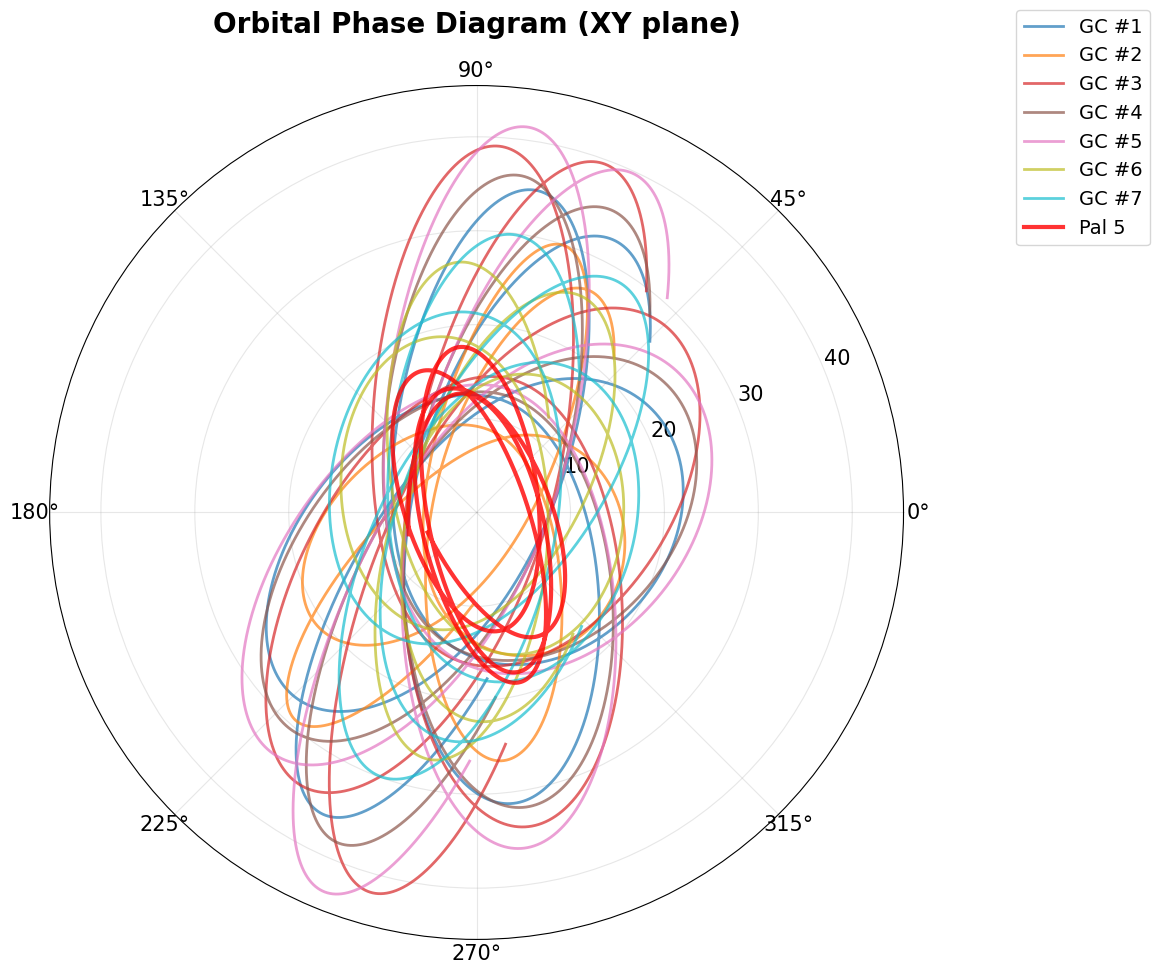

In [107]:
# ============================================================
# 方案2：轨道相位关系 - 极坐标
# ============================================================
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='polar')

colors_sample = plt.cm.tab10(np.linspace(0, 1, len(ra_all)))

for member_idx in range(len(ra_all)):
    init_condition = sample_A[member_idx, :6]
    
    t, orb = agama.orbit(potential=pot_total, ic=init_condition,
                         time=2.*pot_total.Tcirc(init_condition), trajsize=10000)
    t_m, orb_m = agama.orbit(potential=pot_total, ic=init_condition,
                             time=-2.*pot_total.Tcirc(init_condition), trajsize=10000)
    
    orb_full = np.vstack([orb_m[::-1], orb[1:]])
    t_full = np.concatenate([t_m[::-1], t[1:]])
    
    # 计算轨道半径和角度
    r = np.sqrt(orb_full[:,0]**2 + orb_full[:,1]**2)
    theta = np.arctan2(orb_full[:,1], orb_full[:,0])
    
    ax.plot(theta, r, '-', color=colors_sample[member_idx], lw=2, 
            alpha=0.7, label=f'GC #{member_idx+1}')

# Pal 5 轨道
r_gc = np.sqrt(orb_gc_full[:,0]**2 + orb_gc_full[:,1]**2)
theta_gc = np.arctan2(orb_gc_full[:,1], orb_gc_full[:,0])
ax.plot(theta_gc, r_gc, '-', color='red', lw=3, alpha=0.8, label='Pal 5')

ax.set_title('Orbital Phase Diagram (XY plane)', fontsize=20, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

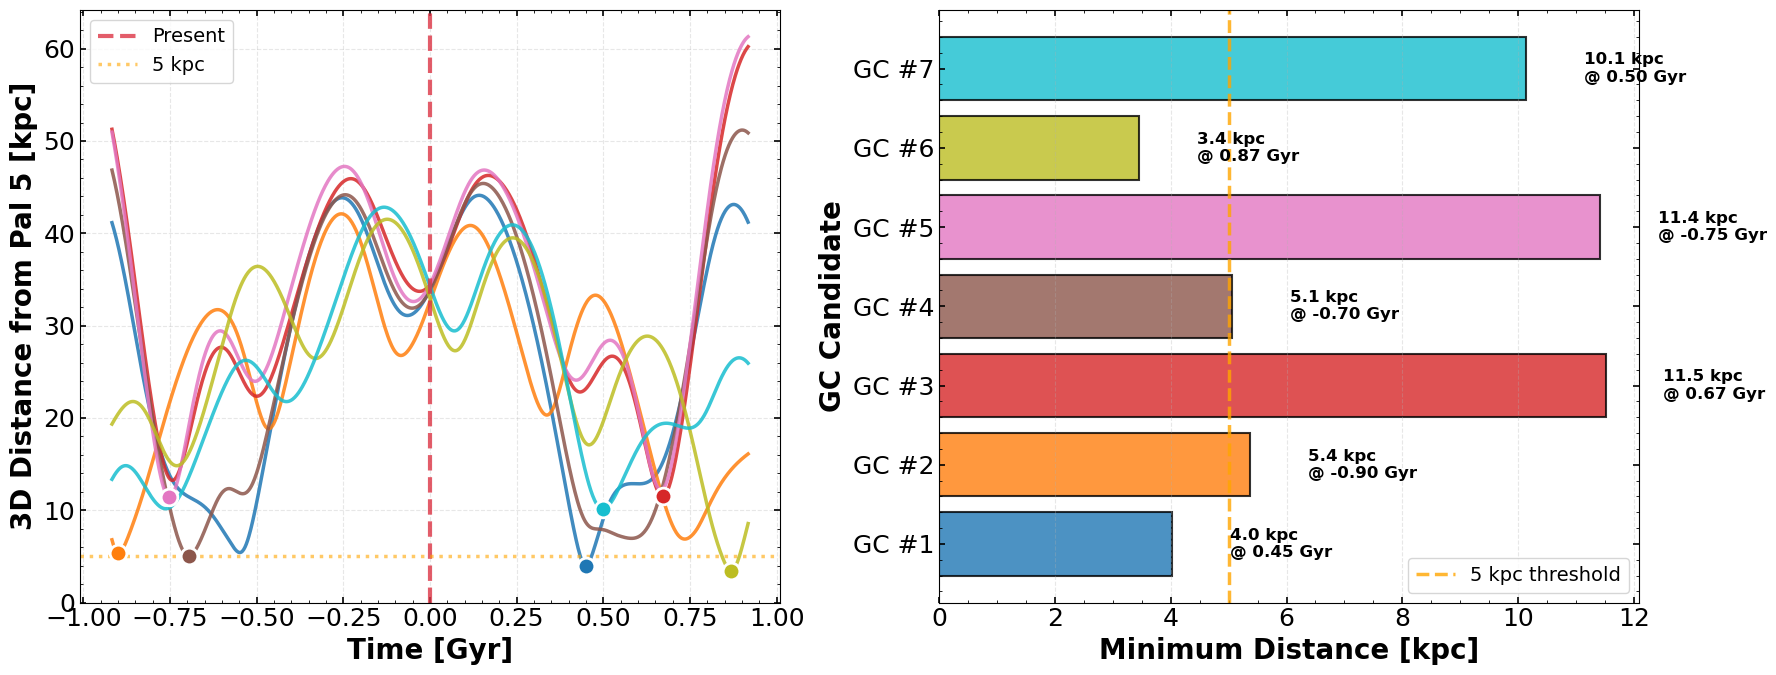

In [108]:
# ============================================================
# 方案3：组合图
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 左图：距离演化（简化版）
ax1 = axes[0]
ax1.grid(True, alpha=0.3, linestyle='--')

orb_gc_full = np.vstack([orb_gc_m[::-1], orb_gc[1:]])
t_gc_full = np.concatenate([t_gc_m[::-1], t_gc[1:]])

colors_sample = plt.cm.tab10(np.linspace(0, 1, len(ra_all)))

min_distances = []
min_times = []
gc_names = []

from scipy.interpolate import interp1d

for member_idx in range(len(ra_all)):
    init_condition = sample_A[member_idx, :6]
    
    t, orb = agama.orbit(potential=pot_total, ic=init_condition,
                         time=2.*pot_total.Tcirc(init_condition), trajsize=10000)
    t_m, orb_m = agama.orbit(potential=pot_total, ic=init_condition,
                             time=-2.*pot_total.Tcirc(init_condition), trajsize=10000)
    
    orb_stream_full = np.vstack([orb_m[::-1], orb[1:]])
    t_stream_full = np.concatenate([t_m[::-1], t[1:]])
    
    t_min = max(t_gc_full[0], t_stream_full[0])
    t_max = min(t_gc_full[-1], t_stream_full[-1])
    t_common = np.linspace(t_min, t_max, 1000)
    
    gc_x_interp = interp1d(t_gc_full, orb_gc_full[:,0], kind='cubic')(t_common)
    gc_y_interp = interp1d(t_gc_full, orb_gc_full[:,1], kind='cubic')(t_common)
    gc_z_interp = interp1d(t_gc_full, orb_gc_full[:,2], kind='cubic')(t_common)
    
    stream_x_interp = interp1d(t_stream_full, orb_stream_full[:,0], kind='cubic')(t_common)
    stream_y_interp = interp1d(t_stream_full, orb_stream_full[:,1], kind='cubic')(t_common)
    stream_z_interp = interp1d(t_stream_full, orb_stream_full[:,2], kind='cubic')(t_common)
    
    dist_3d = np.sqrt((gc_x_interp - stream_x_interp)**2 + 
                      (gc_y_interp - stream_y_interp)**2 + 
                      (gc_z_interp - stream_z_interp)**2)
    
    ax1.plot(t_common, dist_3d, '-', color=colors_sample[member_idx], lw=2.5, 
            alpha=0.85)
    
    min_idx = np.argmin(dist_3d)
    ax1.plot(t_common[min_idx], dist_3d[min_idx], 'o', 
            color=colors_sample[member_idx], ms=12, mec='white', mew=2, zorder=10)
    
    min_distances.append(dist_3d[min_idx])
    min_times.append(t_common[min_idx])
    gc_names.append(f'GC #{member_idx+1}')

ax1.axvline(0, color='#DC3545', ls='--', lw=3, alpha=0.8, label='Present')
ax1.axhline(5, color='#FFA500', ls=':', lw=2.5, alpha=0.6, label='5 kpc')

ax1.set_xlabel('Time [Gyr]', fontsize=20, fontweight='bold')
ax1.set_ylabel('3D Distance from Pal 5 [kpc]', fontsize=20, fontweight='bold')
ax1.set_ylim([0, None])
ax1.tick_params(labelsize=18)
ax1.legend(fontsize=14)

# 右图：最小距离统计
ax2 = axes[1]
bars = ax2.barh(gc_names, min_distances, color=colors_sample, alpha=0.8, edgecolor='black', linewidth=1.5)

# 标记5kpc阈值
ax2.axvline(5, color='#FFA500', ls='--', lw=2.5, alpha=0.8, label='5 kpc threshold')

ax2.set_xlabel('Minimum Distance [kpc]', fontsize=20, fontweight='bold')
ax2.set_ylabel('GC Candidate', fontsize=20, fontweight='bold')
ax2.tick_params(labelsize=18)
ax2.legend(fontsize=14)
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# 在柱子上标注具体数值
for i, (bar, dist, t_min) in enumerate(zip(bars, min_distances, min_times)):
    ax2.text(dist + 1, i, f'{dist:.1f} kpc\n@ {t_min:.2f} Gyr', 
            va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

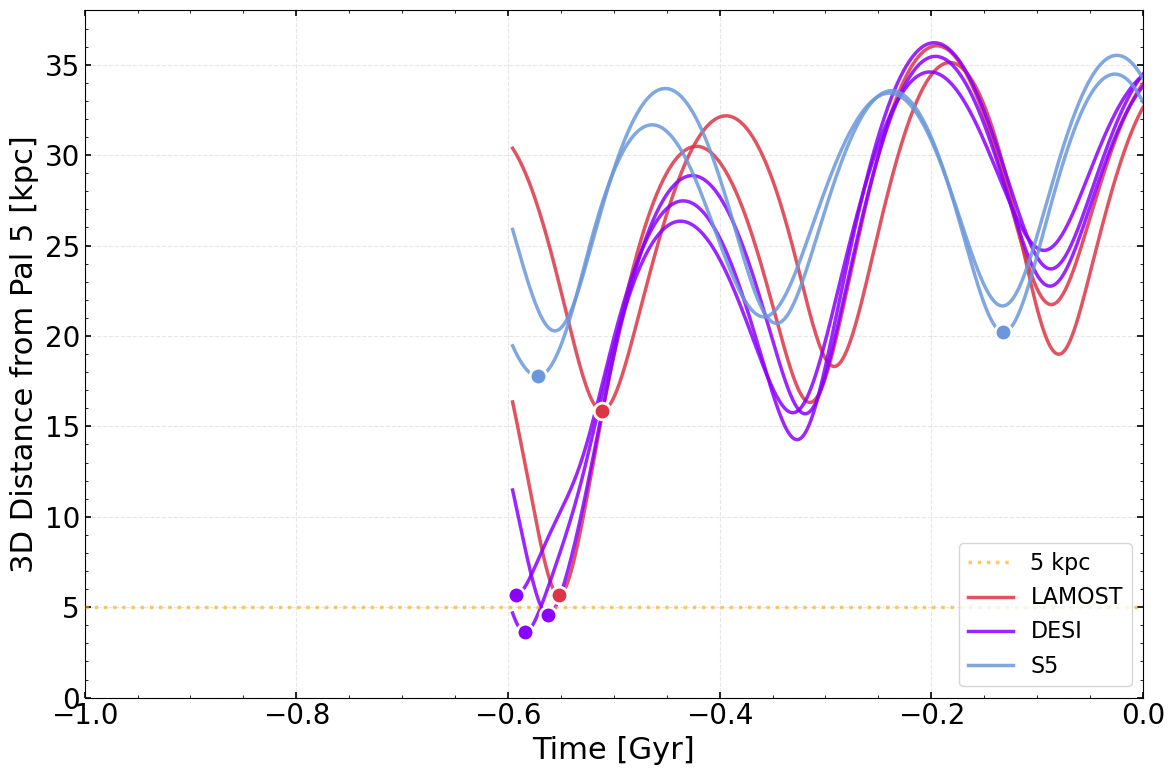

In [250]:
# ============================================================
# Pal 5 与星流成员的轨道相位分析 - 只看过去
# ============================================================
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)

init_condition_gc = sample_gc[pal5_idx]   # 如果只有一个 GC
# 若 sample_gc 有多个 GC，可改成 for 循环

t_gc_past, orb_gc_past = agama.orbit(potential=pot_total, ic=init_condition_gc,
                               time=-4.*pot_total.Tcirc(init_condition_gc), trajsize=10000)


# 前2个：LAMOST - 红色系
# 中间3个：DESI - 紫色系  
# 最后2个：S5 - 蓝色系

colors_sample = [
    '#DC3545',  # GC #1 - LAMOST 
    '#DC3545',  # GC #2 - LAMOST 
    '#8B00FF',  # GC #3 - DESI 
    '#8B00FF',  # GC #4 - DESI 
    '#8B00FF',  # GC #5 - DESI 
    '#6B98DC',  # GC #6 - S5 
    '#6B98DC',  # GC #7 - S5 
]

from scipy.interpolate import interp1d

for member_idx in range(len(ra_all)):
    init_condition = sample_A[member_idx, :6]
    
    # 只计算后向轨道（过去）
    t_m, orb_m = agama.orbit(potential=pot_total, ic=init_condition,
                             time=-4.*pot_total.Tcirc(init_condition), trajsize=10000)
    
    # 反转时间序列，让过去的时间为负
    t_stream = t_m[::-1]
    orb_stream = orb_m[::-1]
    
    # 计算与 Pal 5 的距离随时间变化
    # 只使用后向（过去）部分
    t_gc_past = t_gc_m[::-1]
    orb_gc_past = orb_gc_m[::-1]
    
    # 在共同时间网格上插值
    t_min = max(t_gc_past[0], t_stream[0])
    t_max = min(t_gc_past[-1], t_stream[-1])
    t_common = np.linspace(t_min, t_max, 1000)
    
    # 插值 Pal 5
    gc_x_interp = interp1d(t_gc_past, orb_gc_past[:,0], kind='cubic')(t_common)
    gc_y_interp = interp1d(t_gc_past, orb_gc_past[:,1], kind='cubic')(t_common)
    gc_z_interp = interp1d(t_gc_past, orb_gc_past[:,2], kind='cubic')(t_common)
    
    # 插值星流成员
    stream_x_interp = interp1d(t_stream, orb_stream[:,0], kind='cubic')(t_common)
    stream_y_interp = interp1d(t_stream, orb_stream[:,1], kind='cubic')(t_common)
    stream_z_interp = interp1d(t_stream, orb_stream[:,2], kind='cubic')(t_common)
    
    # 计算3D距离
    dist_3d = np.sqrt((gc_x_interp - stream_x_interp)**2 + 
                      (gc_y_interp - stream_y_interp)**2 + 
                      (gc_z_interp - stream_z_interp)**2)
    
    # 绘制距离演化曲线 
    ax.plot(t_common, dist_3d, '-', color=colors_sample[member_idx], lw=2.5, 
            alpha=0.85)
    
    # 标记最小距离点 
    min_idx = np.argmin(dist_3d)
    ax.plot(t_common[min_idx], dist_3d[min_idx], 'o', 
            color=colors_sample[member_idx], ms=12, mec='white', mew=2, zorder=10)

# 标记当前时刻
ax.axhline(5, color='#FFA500', ls=':', lw=2.5, alpha=0.6, label='5 kpc', zorder=5)

# 手动添加图例
ax.plot([0], [0], '-', color='#DC3545', lw=2.5, alpha=0.85, label='LAMOST')
ax.plot([0], [0], '-', color='#8B00FF', lw=2.5, alpha=0.85, label='DESI')
ax.plot([0], [0], '-', color='#6B98DC', lw=2.5, alpha=0.85, label='S5')

# 只显示过去的时间范围
ax.set_xlim([-1.0, 0])   # 从最早到现在
ax.set_ylim([0, None])  # y轴从0开始

ax.set_xlabel('Time [Gyr]', fontsize=22)
ax.set_ylabel('3D Distance from Pal 5 [kpc]', fontsize=22)

# 图例优化
ax.legend(fontsize=16,loc="lower right")


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig("/home/zyh/stream/palomar5_sibling/plot/distance_evolution_past.png", dpi=300, bbox_inches='tight')
plt.show()

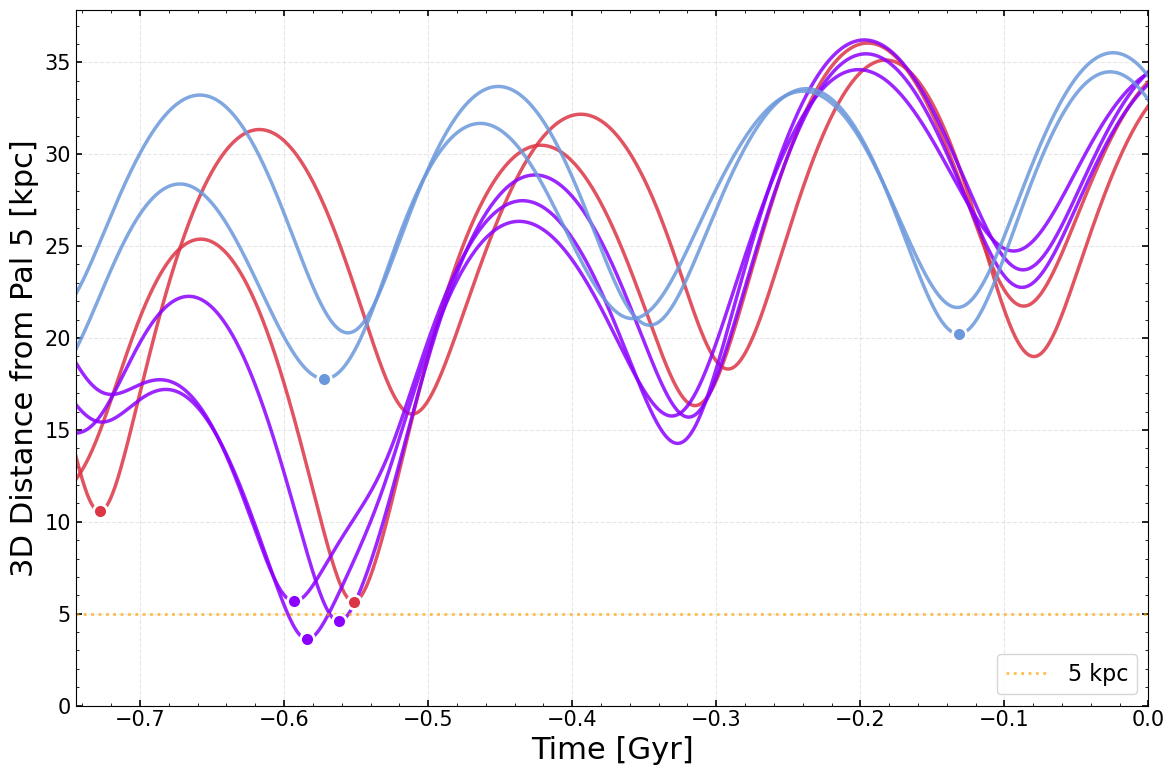

In [256]:
from scipy.interpolate import interp1d

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)

past_factor = 2.5       # 想更长就再加大，比如 10、12
trajsize    = 20000     # 采样点也要加密，避免插值抖动

init_condition_gc = sample_gc[pal5_idx]

# 1) 只算一次 Pal 5 的“更长”过去轨道；注意：别再覆盖它！
t_gc_past, orb_gc_past = agama.orbit(
    potential=pot_total, ic=init_condition_gc,
    time=-past_factor * pot_total.Tcirc(init_condition_gc),
    trajsize=trajsize
)
# 让时间递增（负到 0）
t_gc_past  = t_gc_past[::-1]
orb_gc_past = orb_gc_past[::-1]

# 为 GC 轨道建插值器（线性更稳）
fx_gc = interp1d(t_gc_past, orb_gc_past[:,0], kind='linear', bounds_error=False, fill_value=np.nan)
fy_gc = interp1d(t_gc_past, orb_gc_past[:,1], kind='linear', bounds_error=False, fill_value=np.nan)
fz_gc = interp1d(t_gc_past, orb_gc_past[:,2], kind='linear', bounds_error=False, fill_value=np.nan)

# 颜色表（保持你的顺序）
colors_sample = ['#DC3545','#DC3545','#8B00FF','#8B00FF','#8B00FF','#6B98DC','#6B98DC']

for member_idx in range(len(ra_all)):
    init_condition = sample_A[member_idx, :6]

    # 2) 成员也用同样的 past_factor & trajsize
    t_m, orb_m = agama.orbit(
        potential=pot_total, ic=init_condition,
        time=-past_factor * pot_total.Tcirc(init_condition),
        trajsize=trajsize
    )
    t_stream   = t_m[::-1]
    orb_stream = orb_m[::-1]

    # 共同时间区间（只取过去，<=0）
    t_min = max(np.nanmin(t_gc_past), np.nanmin(t_stream))
    t_max = min(np.nanmax(t_gc_past), np.nanmax(t_stream), 0.0)
    if not np.isfinite(t_min) or not np.isfinite(t_max) or (t_max <= t_min):
        continue

    t_common = np.linspace(t_min, t_max, 2000)

    # 成员插值器
    fx_st = interp1d(t_stream, orb_stream[:,0], kind='linear', bounds_error=False, fill_value=np.nan)
    fy_st = interp1d(t_stream, orb_stream[:,1], kind='linear', bounds_error=False, fill_value=np.nan)
    fz_st = interp1d(t_stream, orb_stream[:,2], kind='linear', bounds_error=False, fill_value=np.nan)

    # 3D 距离
    x_gc, y_gc, z_gc = fx_gc(t_common), fy_gc(t_common), fz_gc(t_common)
    x_st, y_st, z_st = fx_st(t_common), fy_st(t_common), fz_st(t_common)
    dist_3d = np.sqrt((x_gc-x_st)**2 + (y_gc-y_st)**2 + (z_gc-z_st)**2)

    # 画
    ax.plot(t_common, dist_3d, '-', color=colors_sample[member_idx % len(colors_sample)], lw=2.5, alpha=0.85)
    i0 = np.nanargmin(dist_3d)
    ax.plot(t_common[i0], dist_3d[i0], 'o', color=colors_sample[member_idx % len(colors_sample)],
            ms=10, mec='white', mew=2, zorder=10)

# 参考线与坐标轴
ax.axhline(5, color='#FFA500', ls=':', lw=2.0, alpha=0.7, label='5 kpc')
ax.set_xlim(t_common[0], 0.0)   # 如果 past_factor 足够大，会显示到 -1；不够就继续加大 past_factor
ax.set_ylim(bottom=0)

ax.set_xlabel('Time [Gyr]', fontsize=22)
ax.set_ylabel('3D Distance from Pal 5 [kpc]', fontsize=22)
ax.legend(fontsize=16, loc="lower right")
plt.tight_layout(); plt.show()


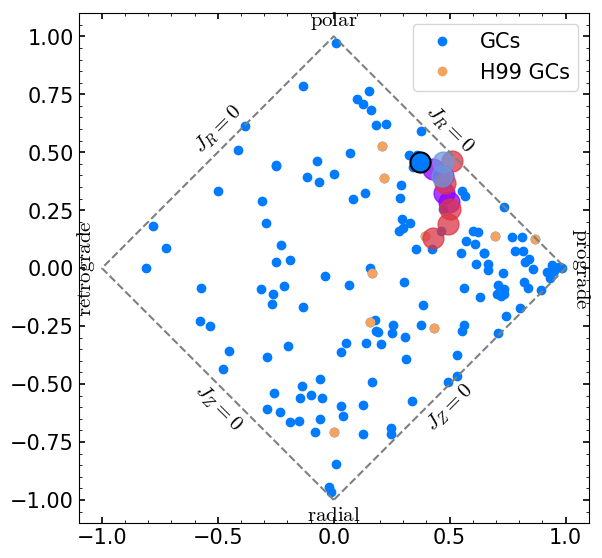

In [157]:
Jtot_D = np.abs(actions_D["JP"])+actions_D["JR"]+actions_D["JZ"]
Jtot_L = np.abs(actions_L["JP"])+actions_L["JR"]+actions_L["JZ"]
Jtot_S = np.abs(actions_S["JP"])+actions_S["JR"]+actions_S["JZ"]
Jtot_h99 = np.abs(df_gc["JP"])+df_gc["JR"]+df_gc["JZ"]

fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.075,0.075,0.85,0.85])
plt.plot(actions_cluster["JP"]/Jtot_cluster,(actions_cluster["JZ"]-actions_cluster["JR"])/Jtot_cluster,'o',color="#007BFF", label="GCs")
plt.plot(df_gc["JP"]/Jtot_h99,(df_gc["JZ"]-df_gc["JR"])/Jtot_h99,'o', c='#F4A460', label='H99 GCs')
#plt.plot(actions_L["JP"][ind_L_yes]/Jtot_L[ind_L_yes],(actions_L["JZ"][ind_L_yes]-actions_L["JR"][ind_L_yes])/Jtot_L[ind_L_yes],'o',color="#DC3545",ms=15,alpha=0.75)
plt.plot(actions_D["JP"]/Jtot_D,(actions_D["JZ"]-actions_D["JR"])/Jtot_D,'o',color="#8B00FF",ms=15,alpha=0.75)
plt.plot(actions_L["JP"]/Jtot_L,(actions_L["JZ"]-actions_L["JR"])/Jtot_L,'o',color="#DC3545",ms=15,alpha=0.75)
plt.plot(actions_S["JP"]/Jtot_S,(actions_S["JZ"]-actions_S["JR"])/Jtot_S,'o',color="#6B98DC",ms=15,alpha=0.75)
plt.plot(actions_cluster["JP"][pal5_idx]/Jtot_cluster[pal5_idx],(actions_cluster["JZ"][pal5_idx]-actions_cluster["JR"][pal5_idx])/Jtot_cluster[pal5_idx],'o',ms=15,color="k")
plt.plot(actions_cluster["JP"][pal5_idx]/Jtot_cluster[pal5_idx],(actions_cluster["JZ"][pal5_idx]-actions_cluster["JR"][pal5_idx])/Jtot_cluster[pal5_idx],'o',ms=12,color="#007BFF")
plt.plot([0,-1,0,1,0],[-1,0,1,0,-1],'--',color="gray")
plt.axis([-1.05,1.05,-1.05,1.05])
plt.axis("scaled")
# plt.axis("off")
plt.text(0,-1.02,r"$\mathrm{radial}$",ha="center", va="top",fontsize=15)
plt.text(0,1.02,r"$\mathrm{polar}$",ha="center", va="bottom",fontsize=15)
plt.text(-1.02,0,r"$\mathrm{retrograde}$",va="center", ha="right",fontsize=15,rotation="vertical")
plt.text(1.02,0,r"$\mathrm{prograde}$",va="center", ha="left",fontsize=15,rotation=-90)

plt.text(-0.5,0.6,"$J_R=0$",va="center", ha="center",fontsize=15,rotation=45)
plt.text(0.5,0.6,"$J_R=0$",va="center", ha="center",fontsize=15,rotation=-45)
plt.text(-0.5,-0.6,"$J_Z=0$",va="center", ha="center",fontsize=15,rotation=-45)
plt.text(0.5,-0.6,"$J_Z=0$",va="center", ha="center",fontsize=15,rotation=45)
plt.legend()
plt.show()

In [150]:
pal5_idx

35

In [125]:
rcd_lbdr = []
rcd_lbd = []
rcd_orb = []
rcd_orb_m = []
rcd_t = []
rcd_t_m = []

# 用于存储偏心率
ecc_list = []

for i_mem in range(len(ra_all)):
    init_condition = [sample_A[i_mem,0], sample_A[i_mem,1], sample_A[i_mem,2], 
                      sample_A[i_mem,3], sample_A[i_mem,4], sample_A[i_mem,5]]
    
    t, orb = agama.orbit(potential=pot_total, ic=init_condition,
                         time=2.*pot_total.Tcirc(init_condition), trajsize=10000)
    t_m, orb_m = agama.orbit(potential=pot_total, ic=init_condition,
                             time=-2.*pot_total.Tcirc(init_condition), trajsize=10000)
    
    output = Table()
    output["X"] = orb[:, 0]
    output["Y"] = orb[:, 1]
    output["Z"] = orb[:, 2]
    output["VX"] = orb[:, 3]
    output["VY"] = orb[:, 4]
    output["VZ"] = orb[:, 5]
    output["t"] = t
    rcd_t.append(t)
    rcd_orb.append(orb)
    
    output_r = Table()
    output_r["X"] = orb_m[:, 0]
    output_r["Y"] = orb_m[:, 1]
    output_r["Z"] = orb_m[:, 2]
    output_r["VX"] = orb_m[:, 3]
    output_r["VY"] = orb_m[:, 4]
    output_r["VZ"] = orb_m[:, 5]
    output_r["t"] = t_m
    rcd_t_m.append(t_m)
    rcd_orb_m.append(orb_m)
    
    # 计算轨道参数
    max_orbit = np.max(np.sqrt(output["X"]**2 + output["Y"]**2 + output["Z"]**2))
    min_orbit = np.min(np.sqrt(output["X"]**2 + output["Y"]**2 + output["Z"]**2))
    ecc_tmp = (max_orbit - min_orbit) / (max_orbit + min_orbit)
    
    max_orbit_r = np.max(np.sqrt(output_r["X"]**2 + output_r["Y"]**2 + output_r["Z"]**2))
    min_orbit_r = np.min(np.sqrt(output_r["X"]**2 + output_r["Y"]**2 + output_r["Z"]**2))
    ecc_tmp_r = (max_orbit_r - min_orbit_r) / (max_orbit_r + min_orbit_r)
    
    ecc = 0.5 * (ecc_tmp + ecc_tmp_r)
    ecc_list.append(ecc)

# 计算平均值和标准差
mean_ecc = np.mean(ecc_list)
std_ecc = np.std(ecc_list)

print(f"Eccentricity: {mean_ecc:.3f} ± {std_ecc:.3f}")

Eccentricity: 0.470 ± 0.073


In [128]:
print("=== Orbital Parameters for All Candidates ===")
print(f"{'GC':<6} {'T_circ [Gyr]':<15} {'Eccentricity':<15} {'Survey':<10}")
print("-" * 50)

ecc_list = []
period_list = []

for i_mem in range(len(ra_all)):
    init_condition = sample_A[i_mem, :6]
    
    # 轨道周期
    T_circ = pot_total.Tcirc(init_condition)
    period_list.append(T_circ)
    
    # 计算轨道
    t, orb = agama.orbit(potential=pot_total, ic=init_condition,
                         time=2.*pot_total.Tcirc(init_condition), trajsize=10000)
    t_m, orb_m = agama.orbit(potential=pot_total, ic=init_condition,
                             time=-2.*pot_total.Tcirc(init_condition), trajsize=10000)
    
    # 计算偏心率
    r = np.sqrt(orb[:, 0]**2 + orb[:, 1]**2 + orb[:, 2]**2)
    r_m = np.sqrt(orb_m[:, 0]**2 + orb_m[:, 1]**2 + orb_m[:, 2]**2)
    
    max_orbit = np.max(r)
    min_orbit = np.min(r)
    ecc_tmp = (max_orbit - min_orbit) / (max_orbit + min_orbit)
    
    max_orbit_m = np.max(r_m)
    min_orbit_m = np.min(r_m)
    ecc_tmp_m = (max_orbit_m - min_orbit_m) / (max_orbit_m + min_orbit_m)
    
    ecc = 0.5 * (ecc_tmp + ecc_tmp_m)
    ecc_list.append(ecc)
    
    # 确定巡天
    if i_mem < 2:
        survey = 'LAMOST'
    elif i_mem < 5:
        survey = 'DESI'
    else:
        survey = 'S5'
    
    print(f"#{i_mem+1:<5} {T_circ:<15.3f} {ecc:<15.3f} {survey:<10}")

# 比较 Pal 5
init_condition_pal5 = sample_gc[35]
T_circ_pal5 = pot_total.Tcirc(init_condition_pal5)

t_p, orb_p = agama.orbit(potential=pot_total, ic=init_condition_pal5,
                         time=2.*pot_total.Tcirc(init_condition_pal5), trajsize=10000)
t_p_m, orb_p_m = agama.orbit(potential=pot_total, ic=init_condition_pal5,
                             time=-2.*pot_total.Tcirc(init_condition_pal5), trajsize=10000)

r_p = np.sqrt(orb_p[:, 0]**2 + orb_p[:, 1]**2 + orb_p[:, 2]**2)
r_p_m = np.sqrt(orb_p_m[:, 0]**2 + orb_p_m[:, 1]**2 + orb_p_m[:, 2]**2)

ecc_pal5 = 0.5 * ((np.max(r_p) - np.min(r_p)) / (np.max(r_p) + np.min(r_p)) +
                  (np.max(r_p_m) - np.min(r_p_m)) / (np.max(r_p_m) + np.min(r_p_m)))

print("-" * 50)
print(f"Pal 5 {T_circ_pal5:<15.3f} {ecc_pal5:<15.3f} {'Reference':<10}")

print("\n=== Summary ===")
print(f"Candidates: T_circ = {np.mean(period_list):.3f} ± {np.std(period_list):.3f} Gyr")
print(f"Candidates: ecc = {np.mean(ecc_list):.3f} ± {np.std(ecc_list):.3f}")
print(f"Pal 5:      T_circ = {T_circ_pal5:.3f} Gyr")
print(f"Pal 5:      ecc = {ecc_pal5:.3f}")

=== Orbital Parameters for All Candidates ===
GC     T_circ [Gyr]    Eccentricity    Survey    
--------------------------------------------------
#1     0.738           0.496           LAMOST    
#2     0.591           0.562           LAMOST    
#3     0.883           0.486           DESI      
#4     0.784           0.497           DESI      
#5     0.889           0.526           DESI      
#6     0.583           0.371           S5        
#7     0.664           0.351           S5        
--------------------------------------------------
Pal 5 0.459           0.198           Reference 

=== Summary ===
Candidates: T_circ = 0.733 ± 0.118 Gyr
Candidates: ecc = 0.470 ± 0.073
Pal 5:      T_circ = 0.459 Gyr
Pal 5:      ecc = 0.198


In [144]:
# 优化pot_halo

import sys
sys.path.append('/home/zyh/stream/palomar5_sibling/')
# 导入优化模块
from optimize_halo_mass import (
    optimize_halo_mass, 
    plot_optimization_results,
    print_optimization_summary,
    create_potential
)

pal5_idx = [i for i, gc in enumerate(extracted_gcs) if 'Pal 5' in gc['Name'].upper()][0]
pal5_data = extracted_gcs[pal5_idx]

print(f"\nPal 5 参数:")
print(f"  RA: {pal5_data['RA']:.4f}°")
print(f"  Dec: {pal5_data['Dec']:.4f}°")
print(f"  Distance: {pal5_data['Distance']:.2f} kpc")
print(f"  RV: {pal5_data['HRV']:.2f} km/s")
print(f"  pmRA: {pal5_data['pmRA']:.4f} mas/yr")
print(f"  pmDE: {pal5_data['pmDE']:.4f} mas/yr")

IndexError: list index out of range


Best halo mass by median min-distance: 12.00 ×1e11 Msun
  median(min dist) = 5.671 kpc
  mean(min dist)   = 10.485 kpc
  count(<= 5.0 kpc) = 2
  median time of closest approach (past) = -0.562 Gyr


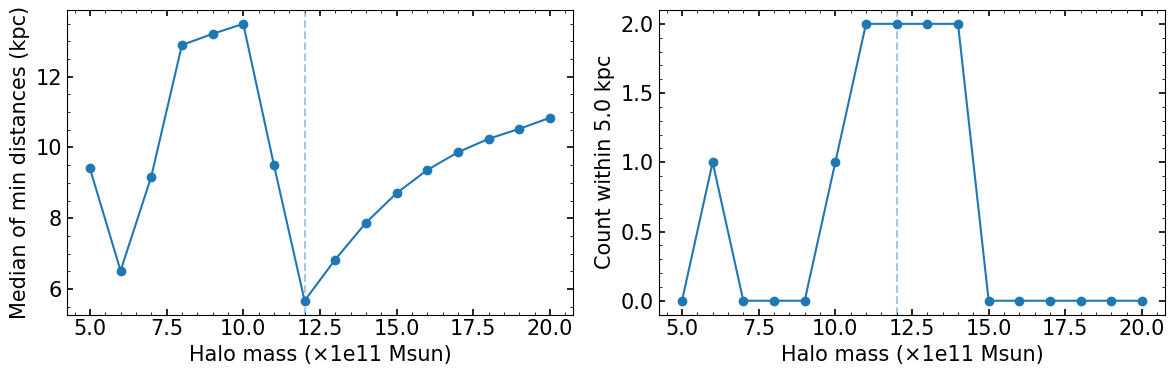

In [242]:
from scipy.interpolate import interp1d

# ===== 可调参数 =====
trajsize = 10000
t_factor = 2.0          # 过去积分时长，单位：Tcirc 倍数
n_tgrid  = 1000         # 公共时间网格采样点
dist_thresh = 5.0       # 判定“接近”的阈值（kpc）

# ===== 结果收集器 =====
mass_list = []
median_min_dist = []
mean_min_dist = []
count_within_thresh = []
best_times_median = []

for mass_tmp in mass_range:
    # --- 势能（与你上面的一致）---
    pot_bulge = agama.Potential(type='Dehnen', scaleRadius=1.0, gamma=1.0, mass=2e10)
    pot_disk  = agama.Potential(type='MiyamotoNagai', scaleRadius=3.0, scaleHeight=0.3, mass=5e10)
    pot_halo  = agama.Potential(type='NFW', scaleRadius=15.0, mass=mass_tmp*1e11)
    pot_total = agama.Potential(pot_bulge, pot_disk, pot_halo)

    # --- Pal 5 中心轨道（只要过去部分）---
    t_gc_m, orb_gc_m = agama.orbit(
        potential=pot_total, ic=init_condition_pal5,
        time=-t_factor * pot_total.Tcirc(init_condition_pal5),
        trajsize=trajsize
    )
    # 反转为递增时间（负 -> 0）
    t_gc_past  = t_gc_m[::-1]
    xyz_gc_past = orb_gc_m[::-1, :3]

    # --- 为插值准备函数（线性更稳）---
    fx_gc = interp1d(t_gc_past, xyz_gc_past[:,0], kind='linear', bounds_error=False, fill_value=np.nan)
    fy_gc = interp1d(t_gc_past, xyz_gc_past[:,1], kind='linear', bounds_error=False, fill_value=np.nan)
    fz_gc = interp1d(t_gc_past, xyz_gc_past[:,2], kind='linear', bounds_error=False, fill_value=np.nan)

    # --- 对所有成员计算最近距离 ---
    min_dists = []
    t_at_min  = []

    for member_idx in range(len(ra_all)):
        init_condition = sample_A[member_idx, :6]

        # 该成员的过去轨道
        t_m, orb_m = agama.orbit(
            potential=pot_total, ic=init_condition,
            time=-t_factor * pot_total.Tcirc(init_condition),
            trajsize=trajsize
        )
        t_stream = t_m[::-1]
        xyz_stream = orb_m[::-1, :3]

        # 与 GC 过去轨道的时间重叠区间（只取过去，<=0）
        t_min = max(np.nanmin(t_gc_past), np.nanmin(t_stream))
        t_max = min(np.nanmax(t_gc_past), np.nanmax(t_stream), 0.0)
        if not np.isfinite(t_min) or not np.isfinite(t_max) or (t_max <= t_min):
            # 无重叠，跳过
            min_dists.append(np.nan)
            t_at_min.append(np.nan)
            continue

        t_common = np.linspace(t_min, t_max, n_tgrid)

        # 插值 GC 与 成员
        fx_st = interp1d(t_stream, xyz_stream[:,0], kind='linear', bounds_error=False, fill_value=np.nan)
        fy_st = interp1d(t_stream, xyz_stream[:,1], kind='linear', bounds_error=False, fill_value=np.nan)
        fz_st = interp1d(t_stream, xyz_stream[:,2], kind='linear', bounds_error=False, fill_value=np.nan)

        x_gc = fx_gc(t_common); y_gc = fy_gc(t_common); z_gc = fz_gc(t_common)
        x_st = fx_st(t_common); y_st = fy_st(t_common); z_st = fz_st(t_common)

        # 3D 距离
        dist = np.sqrt((x_gc-x_st)**2 + (y_gc-y_st)**2 + (z_gc-z_st)**2)
        # 排除 NaN
        mask = np.isfinite(dist)
        if not np.any(mask):
            min_dists.append(np.nan); t_at_min.append(np.nan); continue

        i0 = np.nanargmin(dist)
        min_dists.append(dist[i0])
        t_at_min.append(t_common[i0])

    min_dists = np.array(min_dists, dtype=float)
    t_at_min  = np.array(t_at_min, dtype=float)

    # --- 该势能下的汇总指标 ---
    mass_list.append(mass_tmp)
    median_min_dist.append(np.nanmedian(min_dists))
    mean_min_dist.append(np.nanmean(min_dists))
    count_within_thresh.append(np.nansum(min_dists <= dist_thresh))
    best_times_median.append(np.nanmedian(t_at_min))

# ===== 选出“最佳势能” =====
# 准则1：使成员最近距离的“中位数”最小
best_idx = int(np.nanargmin(median_min_dist))
best_mass = mass_list[best_idx]
print(f"\nBest halo mass by median min-distance: {best_mass:.2f} ×1e11 Msun")
print(f"  median(min dist) = {median_min_dist[best_idx]:.3f} kpc")
print(f"  mean(min dist)   = {mean_min_dist[best_idx]:.3f} kpc")
print(f"  count(<= {dist_thresh} kpc) = {count_within_thresh[best_idx]}")
print(f"  median time of closest approach (past) = {best_times_median[best_idx]:.3f} Gyr")

# （可选）画诊断图：质量 vs 指标
fig2, ax2 = plt.subplots(1,2, figsize=(12,4), sharex=True)
ax2[0].plot(mass_list, median_min_dist, 'o-')
ax2[0].set_xlabel('Halo mass (×1e11 Msun)'); ax2[0].set_ylabel('Median of min distances (kpc)')
ax2[0].axvline(best_mass, ls='--', alpha=0.4)
ax2[1].plot(mass_list, count_within_thresh, 'o-')
ax2[1].set_xlabel('Halo mass (×1e11 Msun)'); ax2[1].set_ylabel(f'Count within {dist_thresh} kpc')
ax2[1].axvline(best_mass, ls='--', alpha=0.4)
plt.tight_layout(); plt.show()
